In [36]:
!pip install seaborn

In [37]:
import json
from dataclasses import dataclass
from datetime import datetime
import torch
import torch.nn as nn
import re
import numpy as np
from typing import List, Dict, Any, Optional, Union, Tuple, Set
from enum import Enum
import math
import seaborn as sns
from pathlib import Path
import traceback
import time
import glob
import os

data_folder = "data/"
jsons_path = "data/*.json"

Création de la classe FullCellInfo récupérant l'ensmeble des informations d'une cellule 

In [38]:
@dataclass
class FullCellInfo:
    """Structure complète d'une cellule Excel avec les informations disponibles dans le JSON Univer"""
    # Contenu (disponible dans le JSON)
    raw_value: Any = ""
    cell_type: int = 0  # 1=text, 2=number, 3=formula (inféré)
    formula: str = ""   # "f" - formule si présente (avec = au début)
    
    # Position
    row: int = 0
    col: int = 0
    sheet_id: str = "default"
    sheet_name: str = ""
    
    # Style complet (basé sur le format Univer optimisé)
    style_id: str = ""  # Peut être vide si pas de style
    
    # Formatage de texte
    bold: bool = False          # "bl": 1
    italic: bool = False        # "it": 1  
    underline: bool = False     # "ul": {"s": 1}
    strike: bool = False        # "st": {"s": 1}
    font_size: float = 11.0     # "fs": size (défaut Calibri 11)
    font_family: str = "Calibri" # "ff": family
    
    # Couleurs
    text_color: str = "#000000"     # "cl": {"rgb": "#color"}
    background_color: str = "#FFFFFF"  # "bg": {"rgb": "#color"}
    
    # Bordures
    border_top: int = 0      # "bd": {"t": {"s": value, "cl": {"rgb": "#color"}}}
    border_bottom: int = 0   # "bd": {"b": {"s": value, "cl": {"rgb": "#color"}}}
    border_left: int = 0     # "bd": {"l": {"s": value, "cl": {"rgb": "#color"}}}
    border_right: int = 0    # "bd": {"r": {"s": value, "cl": {"rgb": "#color"}}}
    border_color: str = "#000000"
    
    # Alignement
    horizontal_align: int = 0  # "ht": 1=left, 2=center, 3=right, 4=justify
    vertical_align: int = 0    # "vt": 1=top, 2=center, 3=bottom
    text_wrap: bool = False    # "tb": 3
    
    # Rotation/Transformation
    text_rotation: int = 0     # "tr": {"a": angle, "v": 0}
    
    # Format de nombre
    number_format: str = "General"  # "n": {"pattern": "format"}
    
    # Fusion de cellules (disponible via mergeData)
    is_merged: bool = False
    merge_range: Tuple[int, int, int, int] = (0, 0, 0, 0)  # (startRow, endRow, startCol, endCol)
    
    # Métadonnées de feuille
    sheet_hidden: bool = False
    sheet_tab_color: str = ""
    sheet_zoom: float = 1.0
    sheet_show_gridlines: bool = True
    
    # Métadonnées de ligne/colonne
    row_height: Optional[float] = None
    row_hidden: bool = False
    col_width: Optional[int] = None
    col_hidden: bool = False
    
    # Volets figés
    freeze_start_row: int = -1
    freeze_start_col: int = -1
    
    def __post_init__(self):
        """Post-processing après création"""
        # Le type est défini par "t" dans le JSON ou inféré du contenu
        if self.cell_type == 0:  # Si pas de type défini
            if self.formula:
                self.cell_type = 3
            elif isinstance(self.raw_value, (int, float)):
                self.cell_type = 2
            elif isinstance(self.raw_value, str) and self.raw_value.strip():
                self.cell_type = 1


Classe pour générer les FullCellInfo à partir d'un json

In [39]:
class ExcelParser:
    """Parse les fichiers Excel JSON Univer en structures FullCellInfo"""
    
    @staticmethod
    def parse_excel_json(excel_data: Dict) -> List['FullCellInfo']:
        """Convertit JSON Excel Univer en liste de FullCellInfo"""
        cells = []  
        
        styles = excel_data.get('styles', {})
        
        for sheet_id, sheet_info in excel_data.get('sheets', {}).items():
            sheet_name = sheet_info.get('name', "")
            cell_data = sheet_info.get('cellData', {})
            merge_data = sheet_info.get('mergeData', [])
            row_data = sheet_info.get('rowData', {})
            column_data = sheet_info.get('columnData', {})
            freeze_info = sheet_info.get('freeze', {})
            
            # Métadonnées de feuille
            sheet_hidden = bool(sheet_info.get('hidden', 0))
            sheet_tab_color = sheet_info.get('tabColor', "")
            sheet_zoom = sheet_info.get('zoomRatio', 1.0)
            sheet_show_gridlines = bool(sheet_info.get('showGridlines', 1))
            
            # Informations de volets figés
            freeze_start_row = freeze_info.get('startRow', -1)
            freeze_start_col = freeze_info.get('startColumn', -1)
            
            # Créer un mapping des cellules fusionnées
            merge_map = ExcelParser._create_merge_map(merge_data)
            
            for row_str, row_cells in cell_data.items():
                row = int(row_str)
                
                # Informations de ligne
                row_info = row_data.get(row_str, {})
                row_height = row_info.get('h')
                row_hidden = bool(row_info.get('hd', 0))
                
                for col_str, cell_info in row_cells.items():
                    col = int(col_str)
                    
                    # Informations de colonne
                    col_info = column_data.get(col_str, {})
                    col_width = col_info.get('w')
                    col_hidden = bool(col_info.get('hd', 0))
                    
                    # Extraire les informations de style
                    style_id = cell_info.get('s', '')
                    style = styles.get(style_id, {}) if style_id else {}
                    
                    # Vérifier si cette cellule fait partie d'une fusion
                    merge_info = merge_map.get((row, col), None)
                    
                    cell = FullCellInfo(
                        raw_value=cell_info.get('v', ''),
                        cell_type=cell_info.get('t', 0),
                        formula=cell_info.get('f', ''),
                        row=row,
                        col=col,
                        sheet_id=sheet_id,
                        sheet_name=sheet_name,
                        style_id=style_id,
                        is_merged=merge_info is not None,
                        merge_range=merge_info if merge_info else (0, 0, 0, 0),
                        sheet_hidden=sheet_hidden,
                        sheet_tab_color=sheet_tab_color,
                        sheet_zoom=sheet_zoom,
                        sheet_show_gridlines=sheet_show_gridlines,
                        row_height=row_height,
                        row_hidden=row_hidden,
                        col_width=col_width,
                        col_hidden=col_hidden,
                        freeze_start_row=freeze_start_row,
                        freeze_start_col=freeze_start_col,
                        **ExcelParser._parse_style(style)
                    )
                    
                    cells.append(cell)  
        
        return cells
    
    @staticmethod
    def _create_merge_map(merge_data: List[Dict]) -> Dict[Tuple[int, int], Tuple[int, int, int, int]]:
        """Crée un mapping des cellules fusionnées"""
        merge_map = {}
        
        for merge in merge_data:
            start_row = merge['startRow']
            end_row = merge['endRow'] 
            start_col = merge['startColumn']
            end_col = merge['endColumn']
            
            # Marquer toutes les cellules dans cette plage comme fusionnées
            for row in range(start_row, end_row + 1):
                for col in range(start_col, end_col + 1):
                    merge_map[(row, col)] = (start_row, end_row, start_col, end_col)
        
        return merge_map
    
    @staticmethod
    def _parse_style(style: Dict) -> Dict:
        """Parse les informations de style basé sur le format Univer optimisé"""
        parsed = {
            'bold': bool(style.get('bl', 0)),
            'italic': bool(style.get('it', 0)),
            'font_size': float(style.get('fs', 11.0)),
            'font_family': style.get('ff', 'Calibri'),
            'text_wrap': bool(style.get('tb', 0) == 3),  # tb: 3 = wrap
        }
        
        # Underline - structure: "ul": {"s": 1}
        ul_info = style.get('ul', {})
        if isinstance(ul_info, dict):
            parsed['underline'] = bool(ul_info.get('s', 0))
        else:
            parsed['underline'] = bool(ul_info)
        
        # Strike - structure: "st": {"s": 1}
        st_info = style.get('st', {})
        if isinstance(st_info, dict):
            parsed['strike'] = bool(st_info.get('s', 0))
        else:
            parsed['strike'] = bool(st_info)
        
        # Couleurs
        if 'cl' in style:  # text color
            parsed['text_color'] = style['cl'].get('rgb', '#000000')
        if 'bg' in style:  # background color
            parsed['background_color'] = style['bg'].get('rgb', '#FFFFFF')
            
        # Bordures - structure: "bd": {"t": {"s": 8, "cl": {"rgb": "#000000"}}}
        borders = style.get('bd', {})
        parsed.update({
            'border_top': borders.get('t', {}).get('s', 0),
            'border_bottom': borders.get('b', {}).get('s', 0),
            'border_left': borders.get('l', {}).get('s', 0),
            'border_right': borders.get('r', {}).get('s', 0),
        })
        
        # Couleur de bordure (prendre la première trouvée)
        border_color = "#000000"
        for border_side in ['t', 'b', 'l', 'r']:
            if border_side in borders and 'cl' in borders[border_side]:
                border_color = borders[border_side]['cl'].get('rgb', '#000000')
                break
        parsed['border_color'] = border_color
        
        # Alignement (mapping exact du convertisseur)
        parsed.update({
            'horizontal_align': style.get('ht', 0),  # 1=left, 2=center, 3=right, 4=justify
            'vertical_align': style.get('vt', 0),    # 1=top, 2=center, 3=bottom
        })
        
        # Rotation/Transformation - "tr": {"a": angle, "v": 0}
        tr_info = style.get('tr', {})
        if isinstance(tr_info, dict):
            parsed['text_rotation'] = tr_info.get('a', 0)  # angle
        else:
            parsed['text_rotation'] = 0
        
        # Format de nombre - structure: "n": {"pattern": "format"}
        number_info = style.get('n', {})
        if isinstance(number_info, dict):
            parsed['number_format'] = number_info.get('pattern', 'General')
        else:
            parsed['number_format'] = 'General'
        
        return parsed

Tokenisation d'un classeur : [POS:1,0][TYPE:TEXT][STYLE:B,I,BG:#4470C4][VALUE:Map brief][MERGE:1,2,0,6][LAYOUT:RH:25.2,CW:150]

In [40]:
class ExcelDataProcessor:
    """Classe pour préparer les données Excel pour l'entraînement de transformers"""
    
    @staticmethod
    def cells_to_text_sequence(cells: List[FullCellInfo], include_empty_cells: bool = False) -> str:
        """Convertit une liste de cellules en séquence de texte pour l'entraînement"""
        sequences = []
        
        # Regrouper par feuille et position
        sheets = {}
        for cell in cells:
            if cell.sheet_name not in sheets:
                sheets[cell.sheet_name] = []
            sheets[cell.sheet_name].append(cell)
        
        for sheet_name, sheet_cells in sheets.items():
            # Trier par position (row, col)
            sheet_cells.sort(key=lambda c: (c.row, c.col))
            
            # Métadonnées de feuille enrichies
            sheet_meta = f"[SHEET:{sheet_name}"
            if sheet_cells:
                first_cell = sheet_cells[0]
                if first_cell.sheet_hidden:
                    sheet_meta += ",HIDDEN"
                if first_cell.sheet_tab_color:
                    sheet_meta += f",TAB:{first_cell.sheet_tab_color}"
                if first_cell.sheet_zoom != 1.0:
                    sheet_meta += f",ZOOM:{first_cell.sheet_zoom}"
                if not first_cell.sheet_show_gridlines:
                    sheet_meta += ",NO_GRID"
                if first_cell.freeze_start_row >= 0 or first_cell.freeze_start_col >= 0:
                    sheet_meta += f",FREEZE:{first_cell.freeze_start_row},{first_cell.freeze_start_col}"
            sheet_meta += "]"
            
            sheet_text = sheet_meta
            for cell in sheet_cells:
                if not include_empty_cells and not cell.raw_value and not cell.is_merged and not cell.style_id:
                    continue
                cell_repr = ExcelDataProcessor._cell_to_token(cell)
                sheet_text += f" {cell_repr}"
            
            sequences.append(sheet_text)
        
        return " [SHEET_END] ".join(sequences)
    
    @staticmethod
    def _cell_to_token(cell: FullCellInfo) -> str:
        """Convertit une cellule en token enrichi pour le transformer"""
        # Format: [POS:row,col][TYPE:t][STYLE:...][VALUE:...][MERGE:...][ROW/COL:...]
        pos = f"[POS:{cell.row},{cell.col}]"
        
        # Type de cellule
        type_map = {0: "EMPTY", 1: "TEXT", 2: "NUMBER", 3: "FORMULA"}
        cell_type = f"[TYPE:{type_map.get(cell.cell_type, 'UNKNOWN')}]"
        
        # Style simplifié pour le token
        style_parts = []
        if cell.bold: style_parts.append("B")
        if cell.italic: style_parts.append("I") 
        if cell.underline: style_parts.append("U")
        if cell.strike: style_parts.append("S")
        if cell.background_color != "#FFFFFF": 
            style_parts.append(f"BG:{cell.background_color}")
        if cell.text_rotation != 0: 
            style_parts.append(f"ROT:{cell.text_rotation}")
        if any([cell.border_top, cell.border_bottom, cell.border_left, cell.border_right]):
            style_parts.append("BORDER")
        if cell.horizontal_align != 0:
            align_map = {1: "LEFT", 2: "CENTER", 3: "RIGHT", 4: "JUSTIFY"}
            style_parts.append(f"ALIGN:{align_map.get(cell.horizontal_align, 'UNKNOWN')}")
        if cell.text_wrap:
            style_parts.append("WRAP")
        if cell.font_size != 11.0:
            style_parts.append(f"SIZE:{cell.font_size}")
        if cell.font_family != "Calibri":
            style_parts.append(f"FONT:{cell.font_family}")
        
        style = f"[STYLE:{','.join(style_parts)}]" if style_parts else "[STYLE:NONE]"
        
        # Valeur (formule ou valeur)
        if cell.formula:
            # Formule avec = au début selon le convertisseur
            formula_clean = cell.formula.lstrip('=')
            value = f"[FORMULA:={formula_clean}]"
        else:
            value = f"[VALUE:{cell.raw_value}]"
        
        # Ajout information de fusion
        merge = ""
        if cell.is_merged:
            sr, er, sc, ec = cell.merge_range
            merge = f"[MERGE:{sr},{er},{sc},{ec}]"
        
        # Informations de ligne/colonne si non-standard
        layout = ""
        layout_parts = []
        if cell.row_height is not None:
            layout_parts.append(f"RH:{cell.row_height}")
        if cell.row_hidden:
            layout_parts.append("ROW_HIDDEN")
        if cell.col_width is not None:
            layout_parts.append(f"CW:{cell.col_width}")
        if cell.col_hidden:
            layout_parts.append("COL_HIDDEN")
        
        if layout_parts:
            layout = f"[LAYOUT:{','.join(layout_parts)}]"
        
        return f"{pos}{cell_type}{style}{value}{merge}{layout}"
    
    @staticmethod
    def extract_workbook_metadata(cells: List[FullCellInfo]) -> Dict[str, Any]:
        """Extrait les métadonnées complètes du classeur"""
        if not cells:
            return {}
        
        sheet_metadata = {}
        
        for cell in cells:
            if cell.sheet_name not in sheet_metadata:
                sheet_metadata[cell.sheet_name] = {
                    'sheet_id': cell.sheet_id,
                    'hidden': cell.sheet_hidden,
                    'tab_color': cell.sheet_tab_color,
                    'zoom': cell.sheet_zoom,
                    'show_gridlines': cell.sheet_show_gridlines,
                    'freeze_panes': (cell.freeze_start_row, cell.freeze_start_col) if cell.freeze_start_row >= 0 or cell.freeze_start_col >= 0 else None,
                    'cell_count': 0,
                    'merged_count': 0,
                    'formula_count': 0,
                    'styles_used': set(),
                    'max_row': 0,
                    'max_col': 0,
                    'custom_row_heights': 0,
                    'custom_col_widths': 0,
                    'hidden_rows': 0,
                    'hidden_cols': 0
                }
            
            meta = sheet_metadata[cell.sheet_name]
            meta['cell_count'] += 1
            meta['max_row'] = max(meta['max_row'], cell.row)
            meta['max_col'] = max(meta['max_col'], cell.col)
            
            if cell.is_merged:
                meta['merged_count'] += 1
            if cell.formula:
                meta['formula_count'] += 1
            if cell.style_id:
                meta['styles_used'].add(cell.style_id)
            if cell.row_height is not None:
                meta['custom_row_heights'] += 1
            if cell.col_width is not None:
                meta['custom_col_widths'] += 1
            if cell.row_hidden:
                meta['hidden_rows'] += 1
            if cell.col_hidden:
                meta['hidden_cols'] += 1
        
        # Convertir les sets en listes pour la sérialisation
        for meta in sheet_metadata.values():
            meta['styles_used'] = list(meta['styles_used'])
        
        return {
            'sheets': sheet_metadata,
            'total_cells': len(cells),
            'total_sheets': len(sheet_metadata),
            'total_merged_cells': sum(meta['merged_count'] for meta in sheet_metadata.values()),
            'total_formulas': sum(meta['formula_count'] for meta in sheet_metadata.values()),
            'total_styles': len(set(cell.style_id for cell in cells if cell.style_id))
        }

Embedder depuis FullCellInfo : 

In [75]:
@dataclass
class EmbeddingConfig:
    """Configuration pour l'embedder Excel"""
    # Dimensions
    embedding_dim: int = 256
    position_embedding_dim: int = 24
    type_embedding_dim: int = 16
    
    # Vocabulaires fixes
    max_position: int = 1000  # pour row/col
    max_value_length: int = 100
    max_font_size: int = 72
    
    # Couleurs (nombre de couleurs possibles)
    color_vocab_size: int = 100
    
    # Alignements, bordures, etc.
    align_vocab_size: int = 5
    border_vocab_size: int = 10
    font_vocab_size: int = 20

class ExcelCellEmbedder(nn.Module):
    """Embedder direct pour FullCellInfo avec dimensions corrigées"""
    
    def __init__(self, config: EmbeddingConfig):
        super().__init__()
        self.config = config
        
        # Position et Type
        self.row_embedding = nn.Embedding(config.max_position, config.position_embedding_dim)
        self.col_embedding = nn.Embedding(config.max_position, config.position_embedding_dim)
        self.type_embedding = nn.Embedding(4, config.type_embedding_dim)
        
        # Contenu (valeur/formule)
        self.value_encoder = ValueEncoder(config)
        
        # Formatage booléen
        self.bool_embedding = nn.Embedding(2, 8)
        
        # Police
        self.font_size_embedding = nn.Embedding(config.max_font_size + 1, 16)
        self.font_family_embedding = nn.Embedding(config.font_vocab_size, 32)
        
        # Couleurs
        self.color_embedding = nn.Embedding(config.color_vocab_size, 24)
        
        # Alignement
        self.align_h_embedding = nn.Embedding(config.align_vocab_size, 16)
        self.align_v_embedding = nn.Embedding(config.align_vocab_size, 16)
        self.rotation_embedding = nn.Embedding(361, 16)
        
        # Bordures
        self.border_embedding = nn.Embedding(config.border_vocab_size, 16)
        
        # Fusion
        self.merge_encoder = MergeEncoder(config)
        
        # CALCUL CORRECT DES DIMENSIONS
        total_dim = (
            2 * config.position_embedding_dim +    # row(32) + col(32) = 64
            config.type_embedding_dim +            # type = 16
            self.value_encoder.output_dim +        # value = 256
            4 * 8 +                                # 4 bools = 32
            16 + 32 +                              # font_size + font_family = 48
            2 * 24 +                               # 2 colors = 48
            2 * 16 + 8 + 16 +                     # align_h + align_v + wrap + rotation = 56
            4 * 16 +                               # 4 borders = 64
            self.merge_encoder.output_dim          # merge = 32
        )  # Total = 64+16+256+32+48+48+56+64+32 = 616
        
        print(f"Total dimension avant projection: {total_dim}")
        
        # Projection finale
        self.projection = nn.Linear(total_dim, config.embedding_dim)
        self.layer_norm = nn.LayerNorm(config.embedding_dim)
        
        # Vocabulaires pour la conversion
        self._build_vocabularies()
    
    def _calculate_total_dim(self) -> int:
        """Calcule la dimension totale avant projection"""
        return (
            2 * self.config.position_embedding_dim +
            self.config.type_embedding_dim +
            self.value_encoder.output_dim +
            4 * 8 +                    # bools
            16 + 32 +                  # font
            2 * 24 +                   # colors
            2 * 16 + 8 + 16 +         # alignment
            4 * 16 +                   # borders
            32                         # merge (fixed size)
        )
    
    def _build_vocabularies(self):
        """Construit les vocabulaires de conversion"""
        self.font_families = [
            "Calibri", "Arial", "Times New Roman", "Helvetica", "Verdana",
            "Georgia", "Courier New", "Tahoma", "Comic Sans MS", "Impact"
        ]
        self.font_family_to_id = {font: i for i, font in enumerate(self.font_families)}
    
    def forward(self, cells: Union['FullCellInfo', List['FullCellInfo']]) -> torch.Tensor:
        if not isinstance(cells, list):
            cells = [cells]
        
        embeddings = []
        
        for cell in cells:
            # Position
            row_emb = self.row_embedding(torch.clamp(torch.tensor(cell.row), 0, self.config.max_position - 1))
            col_emb = self.col_embedding(torch.clamp(torch.tensor(cell.col), 0, self.config.max_position - 1))
            
            # Type
            type_emb = self.type_embedding(torch.tensor(cell.cell_type))
            
            # Contenu
            value_emb = self.value_encoder(cell)
            
            # Formatage booléen
            bold_emb = self.bool_embedding(torch.tensor(int(cell.bold)))
            italic_emb = self.bool_embedding(torch.tensor(int(cell.italic)))
            underline_emb = self.bool_embedding(torch.tensor(int(cell.underline)))
            strike_emb = self.bool_embedding(torch.tensor(int(cell.strike)))
            
            # Police
            font_size = min(int(cell.font_size), self.config.max_font_size)
            font_size_emb = self.font_size_embedding(torch.tensor(font_size))
            
            font_id = self.font_family_to_id.get(cell.font_family, 0)
            font_family_emb = self.font_family_embedding(torch.tensor(font_id))
            
            # Couleurs
            text_color_id = self._color_to_id(cell.text_color)
            bg_color_id = self._color_to_id(cell.background_color)
            text_color_emb = self.color_embedding(torch.tensor(text_color_id))
            bg_color_emb = self.color_embedding(torch.tensor(bg_color_id))
            
            # Alignement
            align_h_emb = self.align_h_embedding(torch.tensor(cell.horizontal_align))
            align_v_emb = self.align_v_embedding(torch.tensor(cell.vertical_align))
            wrap_emb = self.bool_embedding(torch.tensor(int(cell.text_wrap)))
            rotation = min(abs(cell.text_rotation), 360)
            rotation_emb = self.rotation_embedding(torch.tensor(rotation))
            
            # Bordures
            border_top_emb = self.border_embedding(torch.tensor(self._border_to_id(cell.border_top)))
            border_bottom_emb = self.border_embedding(torch.tensor(self._border_to_id(cell.border_bottom)))
            border_left_emb = self.border_embedding(torch.tensor(self._border_to_id(cell.border_left)))
            border_right_emb = self.border_embedding(torch.tensor(self._border_to_id(cell.border_right)))
            
            # Fusion
            merge_emb = self.merge_encoder(cell)
            
            # Concaténer tous les embeddings
            cell_embedding = torch.cat([
                row_emb, col_emb, type_emb, value_emb,
                bold_emb, italic_emb, underline_emb, strike_emb,
                font_size_emb, font_family_emb,
                text_color_emb, bg_color_emb,
                align_h_emb, align_v_emb, wrap_emb, rotation_emb,
                border_top_emb, border_bottom_emb, border_left_emb, border_right_emb,
                merge_emb
            ], dim=0)
            
            embeddings.append(cell_embedding)
        
        # Stack et projeter
        batch_embeddings = torch.stack(embeddings)
        projected = self.projection(batch_embeddings)
        normalized = self.layer_norm(projected)
        
        return normalized.squeeze(0) if len(cells) == 1 else normalized
    
    def _color_to_id(self, color: str) -> int:
        """Convertit une couleur hex en ID"""
        if not color or color == "#FFFFFF":
            return 0
        try:
            hex_val = int(color.replace("#", ""), 16)
            return (hex_val % (self.config.color_vocab_size - 1)) + 1
        except:
            return 0
    
    def _border_to_id(self, border_style: int) -> int:
        """Convertit un style de bordure en ID"""
        border_map = {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 7: 5, 8: 6, 13: 7}
        return border_map.get(border_style, 0)

@dataclass
class EmbeddingConfig:
    """Configuration pour l'embedder Excel - CORRIGÉE"""
    # Dimensions principales
    embedding_dim: int = 256
    position_embedding_dim: int = 32
    type_embedding_dim: int = 16
    
    # Vocabulaires fixes
    max_position: int = 1000
    max_font_size: int = 72
    color_vocab_size: int = 100
    align_vocab_size: int = 5
    border_vocab_size: int = 10
    font_vocab_size: int = 20
    
    # AJOUT : Paramètres pour ValueEncoder
    max_value_tokens: int = 8
    value_token_dim: int = 32
    value_vocab_size: int = 10000

class ValueEncoder(nn.Module):
    """Encodeur spécialisé pour les valeurs de cellules - CORRIGÉ"""
    
    def __init__(self, config: EmbeddingConfig):
        super().__init__()
        self.config = config
        self.max_tokens = config.max_value_tokens  # FIXÉ
        self.token_dim = config.value_token_dim    # FIXÉ
        self.output_dim = self.max_tokens * self.token_dim  # 8 * 32 = 256D
        
        # Tokenizer simple
        self.vocab_size = config.value_vocab_size  # FIXÉ
        self.token_embedding = nn.Embedding(self.vocab_size, self.token_dim)
        
        # Embeddings spéciaux
        self.mask_token_id = 1000
        self.pad_token_id = 0
        self.unk_token_id = 1
        self.number_token_id = 2
        self.formula_start_id = 3
        
        # Encodeur de position pour les tokens
        self.token_position_embedding = nn.Embedding(self.max_tokens, self.token_dim)
        
        # Classification du type de contenu
        self.content_type_embedding = nn.Embedding(4, self.token_dim)
        
    def forward(self, cell: 'FullCellInfo', mask_content: bool = False) -> torch.Tensor:
        """Encode la valeur en séquence de tokens"""
        if mask_content:
            tokens = [self.mask_token_id] * self.max_tokens
            content_type = 0
        elif cell.formula:
            tokens = self._tokenize_formula(cell.formula)
            content_type = 3  # FORMULA
        elif cell.raw_value and cell.cell_type == 2:  # Number
            tokens = self._tokenize_number(cell.raw_value)
            content_type = 2  # NUMBER
        elif cell.raw_value and cell.cell_type == 1:  # Text
            tokens = self._tokenize_text(str(cell.raw_value))
            content_type = 1  # TEXT
        else:
            tokens = [self.pad_token_id] * self.max_tokens
            content_type = 0  # EMPTY
        
        # Padding/truncation à max_tokens
        if len(tokens) > self.max_tokens:
            tokens = tokens[:self.max_tokens]
        else:
            tokens.extend([self.pad_token_id] * (self.max_tokens - len(tokens)))
        
        # Convertir en embeddings
        token_ids = torch.tensor(tokens)
        token_embs = self.token_embedding(token_ids)  # [max_tokens, token_dim]
        
        # Ajouter encodage positionnel
        positions = torch.arange(self.max_tokens)
        pos_embs = self.token_position_embedding(positions)
        
        # Ajouter type de contenu à chaque token
        content_type_emb = self.content_type_embedding(torch.tensor(content_type))
        content_type_emb = content_type_emb.unsqueeze(0).expand(self.max_tokens, -1)
        
        # Combiner
        combined_embs = token_embs + pos_embs + content_type_emb  # [max_tokens, token_dim]
        
        # Aplatir pour la sortie
        return combined_embs.flatten()  # [max_tokens * token_dim] = [256]
    
    def _tokenize_text(self, text: str) -> List[int]:
        """Tokenise le texte (version simplifiée)"""
        words = text.lower().split()[:self.max_tokens]
        tokens = []
        for word in words:
            token_id = (hash(word) % (self.vocab_size - 10)) + 10
            tokens.append(token_id)
        return tokens
    
    def _tokenize_number(self, value: Any) -> List[int]:
        """Tokenise un nombre"""
        try:
            num_str = str(float(value))
            tokens = [self.number_token_id]
            for char in num_str[:self.max_tokens-1]:
                if char.isdigit():
                    tokens.append(ord(char) - ord('0') + 4)
                elif char == '.':
                    tokens.append(14)
                elif char == '-':
                    tokens.append(15)
            return tokens
        except:
            return [self.unk_token_id]
    
    def _tokenize_formula(self, formula: str) -> List[int]:
        """Tokenise une formule Excel"""
        tokens = [self.formula_start_id]
        # Simplification pour l'exemple
        char_tokens = [ord(c) % 100 + 100 for c in formula[:self.max_tokens-1]]
        tokens.extend(char_tokens)
        return tokens

        
class MergeEncoder(nn.Module):
    """Encodeur pour les informations de fusion"""
    
    def __init__(self, config: EmbeddingConfig):
        super().__init__()
        self.output_dim = 32
        
        # Embeddings pour les coordonnées de fusion
        self.merge_coord_embedding = nn.Embedding(config.max_position, 8)
        self.merge_projection = nn.Linear(4 * 8, self.output_dim)
        self.no_merge_embedding = nn.Parameter(torch.randn(self.output_dim))
    
    def forward(self, cell: 'FullCellInfo') -> torch.Tensor:
        """Encode les informations de fusion"""
        if not cell.is_merged:
            return self.no_merge_embedding
        
        sr, er, sc, ec = cell.merge_range
        
        # Limiter les coordonnées
        sr = min(sr, self.merge_coord_embedding.num_embeddings - 1)
        er = min(er, self.merge_coord_embedding.num_embeddings - 1)
        sc = min(sc, self.merge_coord_embedding.num_embeddings - 1)
        ec = min(ec, self.merge_coord_embedding.num_embeddings - 1)
        
        # Embeddings des coordonnées
        sr_emb = self.merge_coord_embedding(torch.tensor(sr))
        er_emb = self.merge_coord_embedding(torch.tensor(er))
        sc_emb = self.merge_coord_embedding(torch.tensor(sc))
        ec_emb = self.merge_coord_embedding(torch.tensor(ec))
        
        # Concaténer et projeter
        merge_vec = torch.cat([sr_emb, er_emb, sc_emb, ec_emb])
        return self.merge_projection(merge_vec)

class ExcelSheetEmbedder(nn.Module):
    """Embedder pour des feuilles entières"""
    
    def __init__(self, config: EmbeddingConfig):
        super().__init__()
        self.cell_embedder = ExcelCellEmbedder(config)
        self.position_encoder = PositionalEncoder(config.embedding_dim)
        
    def forward(self, cells: List['FullCellInfo'], max_cells: Optional[int] = None) -> torch.Tensor:
        """
        Embed une feuille entière
        
        Args:
            cells: Liste de cellules
            max_cells: Nombre maximum de cellules (pour padding)
            
        Returns:
            Tensor [num_cells, embedding_dim] ou [max_cells, embedding_dim]
        """
        # Trier par position
        sorted_cells = sorted(cells, key=lambda c: (c.row, c.col))
        
        if max_cells:
            # Padding ou troncature
            if len(sorted_cells) > max_cells:
                sorted_cells = sorted_cells[:max_cells]
            elif len(sorted_cells) < max_cells:
                # Créer des cellules vides pour le padding
                empty_cell = self._create_empty_cell()
                sorted_cells.extend([empty_cell] * (max_cells - len(sorted_cells)))
        
        # Embedder toutes les cellules
        cell_embeddings = self.cell_embedder(sorted_cells)
        
        # Ajouter l'encodage positionnel
        positioned_embeddings = self.position_encoder(cell_embeddings)
        
        return positioned_embeddings
    
    def _create_empty_cell(self) -> 'FullCellInfo':
        """Crée une cellule vide pour le padding"""
        # Retourner une cellule avec toutes les valeurs par défaut
        # Cette implémentation dépend de votre classe FullCellInfo
        pass

class PositionalEncoder(nn.Module):
    """Encodage positionnel pour les séquences de cellules"""
    
    def __init__(self, embedding_dim: int, max_length: int = 10000):
        super().__init__()
        
        pe = torch.zeros(max_length, embedding_dim)
        position = torch.arange(0, max_length).unsqueeze(1).float()
        
        div_term = torch.exp(torch.arange(0, embedding_dim, 2).float() *
                           -(np.log(10000.0) / embedding_dim))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        self.register_buffer('pe', pe)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Ajoute l'encodage positionnel"""
        seq_len = x.size(0)
        return x + self.pe[:seq_len]

# Exemple d'utilisation
if __name__ == "__main__":
    # Configuration
    config = EmbeddingConfig(
        embedding_dim=256,
        position_embedding_dim=32
    )
    
    # Créer l'embedder
    embedder = ExcelCellEmbedder(config)
    
    # Simuler une cellule (remplacer par votre vraie classe FullCellInfo)
    from dataclasses import dataclass
    from typing import Tuple
    
    @dataclass 
    class MockFullCellInfo:
        raw_value: str = "Hello"
        cell_type: int = 1
        formula: str = ""
        row: int = 5
        col: int = 3
        bold: bool = True
        italic: bool = False
        underline: bool = False
        strike: bool = False
        font_size: float = 12.0
        font_family: str = "Arial"
        text_color: str = "#FF0000"
        background_color: str = "#FFFFFF"
        horizontal_align: int = 1
        vertical_align: int = 0
        text_wrap: bool = False
        text_rotation: int = 0
        border_top: int = 1
        border_bottom: int = 0
        border_left: int = 0
        border_right: int = 0
        is_merged: bool = False
        merge_range: Tuple[int, int, int, int] = (0, 0, 0, 0)
    
    # Créer une cellule test
    cell = MockFullCellInfo()
    
    # Obtenir l'embedding
    with torch.no_grad():
        embedding = embedder(cell)
        print(f"Embedding shape: {embedding.shape}")
        print(f"Embedding (premiers 10 éléments): {embedding[:10]}")
        
        # Test avec plusieurs cellules
        cells = [cell, cell, cell]
        batch_embedding = embedder(cells)
        print(f"Batch embedding shape: {batch_embedding.shape}")
        
        # Nombre de paramètres
        total_params = sum(p.numel() for p in embedder.parameters())
        print(f"Nombre total de paramètres: {total_params:,}")

Total dimension avant projection: 616
Embedding shape: torch.Size([256])
Embedding (premiers 10 éléments): tensor([-0.2624,  0.6277, -0.1341, -0.0217, -1.5651, -1.6880, -0.9782,  1.3257,
        -1.0761,  0.7506])
Batch embedding shape: torch.Size([3, 256])
Nombre total de paramètres: 562,320


Création du Graph Embedding

In [76]:
class EdgeType(Enum):
    """Types d'arêtes dans le graphe Excel"""
    # Relations spatiales
    SAME_ROW = "same_row"
    SAME_COL = "same_col"
    ADJACENT_RIGHT = "adjacent_right"
    ADJACENT_DOWN = "adjacent_down"
    ADJACENT_DIAG = "adjacent_diag"
    
    # Relations de distance
    NEAR_2 = "near_2"      # Distance 2
    NEAR_3 = "near_3"      # Distance 3
    NEAR_5 = "near_5"      # Distance 5
    FAR = "far"            # Distance > 5
    
    # Relations de dépendance
    FORMULA_REF = "formula_ref"           # A1 référence B1 dans une formule
    FORMULA_RANGE = "formula_range"       # Formule utilise une plage (A1:B5)
    FORMULA_INDIRECT = "formula_indirect" # Référence indirecte (INDIRECT, etc.)
    CROSS_SHEET_REF = "cross_sheet_ref"   # Référence entre feuilles (Sheet2!A1)
    
    # Relations structurelles
    MERGED_CELL = "merged_cell"      # Cellules fusionnées
    SAME_STYLE = "same_style"        # Même style appliqué
    SAME_VALUE_TYPE = "same_value_type"  # Même type de valeur
    
    # Relations de feuille
    SAME_SHEET = "same_sheet"        # Appartiennent à la même feuille
    CROSS_SHEET = "cross_sheet"      # Appartiennent à des feuilles différentes
    
    # Relations de plage
    RANGE_START = "range_start"      # Début de plage
    RANGE_END = "range_end"          # Fin de plage
    RANGE_MEMBER = "range_member"    # Membre d'une plage

@dataclass
class GraphEdge:
    """Représente une arête dans le graphe Excel"""
    source_idx: int           # Index de la cellule source
    target_idx: int           # Index de la cellule cible
    edge_type: EdgeType       # Type de relation
    weight: float = 1.0       # Poids de l'arête
    metadata: Dict[str, Any] = None  # Métadonnées additionnelles
    
    def __post_init__(self):
        if self.metadata is None:
            self.metadata = {}

@dataclass
class ExcelGraph:
    """Représente le graphe Excel avec cellules et arêtes"""
    cell_embeddings: torch.Tensor      # [num_cells, embedding_dim]
    edge_embeddings: torch.Tensor      # [num_edges, edge_embedding_dim]
    edge_indices: torch.Tensor         # [2, num_edges] - format PyG
    edge_types: List[EdgeType]         # Type de chaque arête
    edge_weights: torch.Tensor         # [num_edges] - poids des arêtes
    cell_positions: List[Tuple[int, int]]  # [(row, col)] positions originales
    
    @property
    def num_nodes(self) -> int:
        return self.cell_embeddings.size(0)
    
    @property
    def num_edges(self) -> int:
        return self.edge_embeddings.size(0)

class ExcelGraphBuilder:
    """Construit le graphe de relations entre cellules Excel"""
    
    def __init__(self, 
                 max_distance: int = 5,
                 include_spatial: bool = True,
                 include_formula_deps: bool = True,
                 include_structural: bool = True,
                 include_sheet_relations: bool = True,
                 same_style_threshold: float = 0.8,
                 cross_sheet_weight: float = 0.3):
        """
        Args:
            max_distance: Distance maximale pour les arêtes spatiales
            include_spatial: Inclure les relations spatiales
            include_formula_deps: Inclure les dépendances de formules
            include_structural: Inclure les relations structurelles
            include_sheet_relations: Inclure les relations de feuille
            same_style_threshold: Seuil pour considérer des styles similaires
            cross_sheet_weight: Poids pour les relations inter-feuilles
        """
        self.max_distance = max_distance
        self.include_spatial = include_spatial
        self.include_formula_deps = include_formula_deps
        self.include_structural = include_structural
        self.include_sheet_relations = include_sheet_relations
        self.same_style_threshold = same_style_threshold
        self.cross_sheet_weight = cross_sheet_weight
    
    def build_graph(self, cells: List['FullCellInfo']) -> Tuple[List[GraphEdge], Dict[Tuple[str, int, int], int]]:
        """
        Construit le graphe de relations entre cellules
        
        Args:
            cells: Liste des cellules Excel
            
        Returns:
            Tuple[edges, position_to_index_map] - position inclut maintenant sheet_name
        """
        edges = []
        
        # Créer un mapping (sheet, row, col) -> index
        pos_to_idx = {(cell.sheet_name, cell.row, cell.col): i for i, cell in enumerate(cells)}
        
        # 1. Relations de feuille (en premier pour établir le contexte)
        if self.include_sheet_relations:
            edges.extend(self._build_sheet_relation_edges(cells, pos_to_idx))
        
        # 2. Relations spatiales (seulement dans la même feuille)
        if self.include_spatial:
            edges.extend(self._build_spatial_edges(cells, pos_to_idx))
        
        # 3. Relations de dépendance (formules - incluant cross-sheet)
        if self.include_formula_deps:
            edges.extend(self._build_formula_dependency_edges(cells, pos_to_idx))
        
        # 4. Relations structurelles
        if self.include_structural:
            edges.extend(self._build_structural_edges(cells, pos_to_idx))
        
        return edges, pos_to_idx
    
    def _build_sheet_relation_edges(self, cells: List['FullCellInfo'], pos_to_idx: Dict) -> List[GraphEdge]:
        """Construit les arêtes basées sur l'appartenance aux feuilles"""
        edges = []
        
        # Grouper les cellules par feuille
        sheets = {}
        for i, cell in enumerate(cells):
            if cell.sheet_name not in sheets:
                sheets[cell.sheet_name] = []
            sheets[cell.sheet_name].append(i)
        
        # Relations intra-feuille (SAME_SHEET)
        for sheet_name, cell_indices in sheets.items():
            for i in range(len(cell_indices)):
                for j in range(i + 1, len(cell_indices)):
                    idx_i, idx_j = cell_indices[i], cell_indices[j]
                    edges.append(GraphEdge(
                        idx_i, idx_j, 
                        EdgeType.SAME_SHEET, 
                        weight=1.0,
                        metadata={'sheet_name': sheet_name}
                    ))
        
        # Relations inter-feuilles (CROSS_SHEET)
        sheet_names = list(sheets.keys())
        for i in range(len(sheet_names)):
            for j in range(i + 1, len(sheet_names)):
                sheet_i, sheet_j = sheet_names[i], sheet_names[j]
                cells_i, cells_j = sheets[sheet_i], sheets[sheet_j]
                
                # Connecter toutes les cellules entre feuilles différentes
                # (peut être coûteux - limiter si nécessaire)
                for cell_idx_i in cells_i[:10]:  # Limiter à 10 cellules par feuille
                    for cell_idx_j in cells_j[:10]:
                        edges.append(GraphEdge(
                            cell_idx_i, cell_idx_j,
                            EdgeType.CROSS_SHEET,
                            weight=self.cross_sheet_weight,
                            metadata={
                                'sheet_i': sheet_i,
                                'sheet_j': sheet_j
                            }
                        ))
        
        return edges
    
    def _build_spatial_edges(self, cells: List['FullCellInfo'], pos_to_idx: Dict) -> List[GraphEdge]:
        """Construit les arêtes basées sur les relations spatiales (dans la même feuille uniquement)"""
        edges = []
        
        # Grouper par feuille pour éviter les relations spatiales inter-feuilles
        sheets = {}
        for i, cell in enumerate(cells):
            if cell.sheet_name not in sheets:
                sheets[cell.sheet_name] = []
            sheets[cell.sheet_name].append((i, cell))
        
        # Construire les relations spatiales pour chaque feuille séparément
        for sheet_name, sheet_cells in sheets.items():
            for i, (idx_i, cell_i) in enumerate(sheet_cells):
                for j, (idx_j, cell_j) in enumerate(sheet_cells):
                    if i >= j:  # Éviter les doublons
                        continue
                    
                    row_i, col_i = cell_i.row, cell_i.col
                    row_j, col_j = cell_j.row, cell_j.col
                    
                    # Distance Manhattan
                    distance = abs(row_i - row_j) + abs(col_i - col_j)
                    
                    if distance > self.max_distance:
                        # Relation "far" (même feuille)
                        edges.append(GraphEdge(
                            idx_i, idx_j, EdgeType.FAR, 
                            weight=1.0/distance,
                            metadata={'sheet_name': sheet_name}
                        ))
                        continue
                    
                    # Relations spécifiques
                    if row_i == row_j and col_i != col_j:
                        # Même ligne
                        edges.append(GraphEdge(
                            idx_i, idx_j, EdgeType.SAME_ROW, 
                            weight=1.0,
                            metadata={'sheet_name': sheet_name, 'row': row_i}
                        ))
                        
                        # Adjacent horizontal
                        if abs(col_i - col_j) == 1:
                            edges.append(GraphEdge(idx_i, idx_j, EdgeType.ADJACENT_RIGHT, weight=1.0))
                    
                    elif col_i == col_j and row_i != row_j:
                        # Même colonne
                        edges.append(GraphEdge(
                            idx_i, idx_j, EdgeType.SAME_COL, 
                            weight=1.0,
                            metadata={'sheet_name': sheet_name, 'col': col_i}
                        ))
                        
                        # Adjacent vertical
                        if abs(row_i - row_j) == 1:
                            edges.append(GraphEdge(idx_i, idx_j, EdgeType.ADJACENT_DOWN, weight=1.0))
                    
                    elif distance == 2 and abs(row_i - row_j) == 1 and abs(col_i - col_j) == 1:
                        # Adjacent diagonal
                        edges.append(GraphEdge(idx_i, idx_j, EdgeType.ADJACENT_DIAG, weight=0.7))
                    
                    # Relations de distance
                    elif distance == 2:
                        edges.append(GraphEdge(idx_i, idx_j, EdgeType.NEAR_2, weight=0.5))
                    elif distance == 3:
                        edges.append(GraphEdge(idx_i, idx_j, EdgeType.NEAR_3, weight=0.3))
                    elif distance <= 5:
                        edges.append(GraphEdge(idx_i, idx_j, EdgeType.NEAR_5, weight=0.1))
        
        return edges
    
    def _build_formula_dependency_edges(self, cells: List['FullCellInfo'], pos_to_idx: Dict) -> List[GraphEdge]:
        """Construit les arêtes basées sur les dépendances de formules (incluant cross-sheet)"""
        edges = []
        
        for i, cell in enumerate(cells):
            if not cell.formula:
                continue
            
            # Parser les références dans la formule
            references = self._parse_formula_references(cell.formula, cell.sheet_name)
            
            for ref in references:
                if ref['type'] == 'cell':
                    # Référence à une cellule (même feuille ou autre)
                    target_pos = (ref['sheet'], ref['row'], ref['col'])
                    if target_pos in pos_to_idx:
                        j = pos_to_idx[target_pos]
                        edge_type = EdgeType.CROSS_SHEET_REF if ref['sheet'] != cell.sheet_name else EdgeType.FORMULA_REF
                        weight = 0.8 if ref['sheet'] != cell.sheet_name else 1.0
                        
                        edges.append(GraphEdge(
                            i, j, edge_type, 
                            weight=weight,
                            metadata={
                                'formula_ref': ref['text'],
                                'source_sheet': cell.sheet_name,
                                'target_sheet': ref['sheet']
                            }
                        ))
                
                elif ref['type'] == 'range':
                    # Référence à une plage
                    start_row, start_col = ref['start_row'], ref['start_col']
                    end_row, end_col = ref['end_row'], ref['end_col']
                    
                    for row in range(start_row, end_row + 1):
                        for col in range(start_col, end_col + 1):
                            target_pos = (ref['sheet'], row, col)
                            if target_pos in pos_to_idx:
                                j = pos_to_idx[target_pos]
                                edge_type = EdgeType.CROSS_SHEET_REF if ref['sheet'] != cell.sheet_name else EdgeType.FORMULA_RANGE
                                weight = 0.4 if ref['sheet'] != cell.sheet_name else 0.5
                                
                                edges.append(GraphEdge(
                                    i, j, edge_type,
                                    weight=weight,
                                    metadata={
                                        'formula_range': ref['text'],
                                        'source_sheet': cell.sheet_name,
                                        'target_sheet': ref['sheet']
                                    }
                                ))
                
                elif ref['type'] == 'indirect':
                    # Référence indirecte (plus complexe à analyser)
                    edges.append(GraphEdge(
                        i, i, EdgeType.FORMULA_INDIRECT, 
                        weight=0.3,
                        metadata={'indirect_ref': ref['text']}
                    ))
        
        return edges
    
    def _parse_formula_references(self, formula: str, current_sheet: str) -> List[Dict[str, Any]]:
        """Parse les références dans une formule Excel (incluant cross-sheet)"""
        references = []
        
        # Pattern pour les références cross-sheet (Sheet1!A1, 'Sheet Name'!A1)
        cross_sheet_pattern = r"(?:'([^']+)'|([^!\s]+))!(\$?[A-Z]+\$?\d+)"
        cross_sheet_matches = re.finditer(cross_sheet_pattern, formula.upper())
        
        for match in cross_sheet_matches:
            sheet_name_quoted, sheet_name_simple, cell_ref = match.groups()
            sheet_name = sheet_name_quoted or sheet_name_simple
            
            # Parser la référence de cellule
            cell_match = re.match(r'\$?([A-Z]+)\$?(\d+)', cell_ref)
            if cell_match:
                col_str, row_str = cell_match.groups()
                col = self._col_str_to_num(col_str)
                row = int(row_str) - 1
                
                references.append({
                    'type': 'cell',
                    'sheet': sheet_name,
                    'row': row,
                    'col': col,
                    'text': match.group(0)
                })
        
        # Pattern pour les plages cross-sheet (Sheet1!A1:B5)
        cross_sheet_range_pattern = r"(?:'([^']+)'|([^!\s]+))!(\$?[A-Z]+\$?\d+:\$?[A-Z]+\$?\d+)"
        cross_sheet_range_matches = re.finditer(cross_sheet_range_pattern, formula.upper())
        
        for match in cross_sheet_range_matches:
            sheet_name_quoted, sheet_name_simple, range_ref = match.groups()
            sheet_name = sheet_name_quoted or sheet_name_simple
            
            # Parser la plage
            range_match = re.match(r'\$?([A-Z]+)\$?(\d+):\$?([A-Z]+)\$?(\d+)', range_ref)
            if range_match:
                start_col_str, start_row_str, end_col_str, end_row_str = range_match.groups()
                start_col = self._col_str_to_num(start_col_str)
                start_row = int(start_row_str) - 1
                end_col = self._col_str_to_num(end_col_str)
                end_row = int(end_row_str) - 1
                
                references.append({
                    'type': 'range',
                    'sheet': sheet_name,
                    'start_row': start_row,
                    'start_col': start_col,
                    'end_row': end_row,
                    'end_col': end_col,
                    'text': match.group(0)
                })
        
        # Pattern pour les références locales (A1, A1:B5 sans nom de feuille)
        # Retirer d'abord les références cross-sheet pour éviter les doublons
        formula_local = formula.upper()
        for match in re.finditer(cross_sheet_pattern, formula_local):
            formula_local = formula_local.replace(match.group(0), "")
        for match in re.finditer(cross_sheet_range_pattern, formula_local):
            formula_local = formula_local.replace(match.group(0), "")
        
        # Références de cellules locales
        cell_pattern = r'\$?([A-Z]+)\$?(\d+)'
        cell_matches = re.finditer(cell_pattern, formula_local)
        
        for match in cell_matches:
            col_str, row_str = match.groups()
            col = self._col_str_to_num(col_str)
            row = int(row_str) - 1
            references.append({
                'type': 'cell',
                'sheet': current_sheet,
                'row': row,
                'col': col,
                'text': match.group(0)
            })
        
        # Plages locales
        range_pattern = r'\$?([A-Z]+)\$?(\d+):\$?([A-Z]+)\$?(\d+)'
        range_matches = re.finditer(range_pattern, formula_local)
        
        for match in range_matches:
            start_col_str, start_row_str, end_col_str, end_row_str = match.groups()
            start_col = self._col_str_to_num(start_col_str)
            start_row = int(start_row_str) - 1
            end_col = self._col_str_to_num(end_col_str)
            end_row = int(end_row_str) - 1
            
            references.append({
                'type': 'range',
                'sheet': current_sheet,
                'start_row': start_row,
                'start_col': start_col,
                'end_row': end_row,
                'end_col': end_col,
                'text': match.group(0)
            })
        
        # Fonctions indirectes
        indirect_pattern = r'INDIRECT\s*\([^)]+\)'
        indirect_matches = re.finditer(indirect_pattern, formula.upper())
        
        for match in indirect_matches:
            references.append({
                'type': 'indirect',
                'text': match.group(0)
            })
        
        return references
    
    def _col_str_to_num(self, col_str: str) -> int:
        """Convertit une colonne string (A, B, ..., AA, AB) en nombre"""
        result = 0
        for char in col_str:
            result = result * 26 + (ord(char) - ord('A') + 1)
        return result - 1  # Convert to 0-based
    
    def _build_structural_edges(self, cells: List['FullCellInfo'], pos_to_idx: Dict) -> List[GraphEdge]:
        """Construit les arêtes basées sur les relations structurelles"""
        edges = []
        
        for i, cell_i in enumerate(cells):
            for j, cell_j in enumerate(cells):
                if i >= j:
                    continue
                
                # Cellules fusionnées
                if cell_i.is_merged and cell_j.is_merged:
                    if cell_i.merge_range == cell_j.merge_range:
                        edges.append(GraphEdge(i, j, EdgeType.MERGED_CELL, weight=1.0))
                
                # Même style (simplifié - comparer style_id)
                if cell_i.style_id and cell_j.style_id and cell_i.style_id == cell_j.style_id:
                    edges.append(GraphEdge(i, j, EdgeType.SAME_STYLE, weight=0.8))
                
                # Même type de valeur
                if cell_i.cell_type == cell_j.cell_type and cell_i.cell_type != 0:  # Pas vide
                    edges.append(GraphEdge(i, j, EdgeType.SAME_VALUE_TYPE, weight=0.4))
        
        return edges

class EdgeEmbedder(nn.Module):
    """Embedder pour les arêtes du graphe"""
    
    def __init__(self, embedding_dim: int = 64):
        super().__init__()
        self.embedding_dim = embedding_dim
        
        # Embedding par type d'arête
        num_edge_types = len(EdgeType)
        self.edge_type_embedding = nn.Embedding(num_edge_types, embedding_dim)
        
        # Embedding pour les poids (discrétisés)
        self.weight_bins = 20
        self.weight_embedding = nn.Embedding(self.weight_bins, embedding_dim // 4)
        
        # Projection finale
        self.projection = nn.Linear(embedding_dim + embedding_dim // 4, embedding_dim)
        
        # Mapping des types vers des IDs
        self.edge_type_to_id = {edge_type: i for i, edge_type in enumerate(EdgeType)}
    
    def forward(self, edge_types: List[EdgeType], edge_weights: torch.Tensor) -> torch.Tensor:
        """
        Embed les arêtes
        
        Args:
            edge_types: Liste des types d'arêtes
            edge_weights: Poids des arêtes [num_edges]
            
        Returns:
            Embeddings des arêtes [num_edges, embedding_dim]
        """
        # Convertir types en IDs
        type_ids = torch.tensor([self.edge_type_to_id[et] for et in edge_types])
        type_embeddings = self.edge_type_embedding(type_ids)
        
        # Discrétiser les poids
        weight_bins = torch.clamp(
            (edge_weights * self.weight_bins).long(), 
            0, self.weight_bins - 1
        )
        weight_embeddings = self.weight_embedding(weight_bins)
        
        # Combiner
        combined = torch.cat([type_embeddings, weight_embeddings], dim=1)
        return self.projection(combined)

class ExcelGraphEmbedder(nn.Module):
    """Embedder complet pour les graphes Excel"""
    
    def __init__(self, cell_embedder: ExcelCellEmbedder, edge_embedding_dim: int = 64):
        super().__init__()
        self.cell_embedder = cell_embedder
        self.edge_embedder = EdgeEmbedder(edge_embedding_dim)
        self.graph_builder = ExcelGraphBuilder()
        
    def forward(self, cells: List['FullCellInfo']) -> ExcelGraph:
        """
        Convertit une liste de cellules en graphe embedé
        
        Args:
            cells: Liste des cellules Excel
            
        Returns:
            ExcelGraph avec embeddings
        """
        # 1. Embed les cellules
        cell_embeddings = self.cell_embedder(cells)
        
        # 2. Construire le graphe
        edges, pos_to_idx = self.graph_builder.build_graph(cells)
        
        if not edges:
            # Graphe vide
            return ExcelGraph(
                cell_embeddings=cell_embeddings,
                edge_embeddings=torch.empty(0, self.edge_embedder.embedding_dim),
                edge_indices=torch.empty(2, 0, dtype=torch.long),
                edge_types=[],
                edge_weights=torch.empty(0),
                cell_positions=[(cell.row, cell.col) for cell in cells]
            )
        
        # 3. Préparer les données d'arêtes
        edge_indices = torch.tensor([[e.source_idx, e.target_idx] for e in edges]).T
        edge_types = [e.edge_type for e in edges]
        edge_weights = torch.tensor([e.weight for e in edges])
        
        # 4. Embed les arêtes
        edge_embeddings = self.edge_embedder(edge_types, edge_weights)
        
        # 5. Créer le graphe final
        return ExcelGraph(
            cell_embeddings=cell_embeddings,
            edge_embeddings=edge_embeddings,
            edge_indices=edge_indices,
            edge_types=edge_types,
            edge_weights=edge_weights,
            cell_positions=[(cell.row, cell.col) for cell in cells]
        )
    
    def get_edge_statistics(self, graph: ExcelGraph) -> Dict[str, int]:
        """Retourne des statistiques sur les types d'arêtes"""
        stats = {}
        for edge_type in graph.edge_types:
            stats[edge_type.value] = stats.get(edge_type.value, 0) + 1
        return stats

# Exemple d'utilisation et tests
if __name__ == "__main__":
    # Simuler des cellules pour tester
    from dataclasses import dataclass
    from typing import Tuple
    
    @dataclass
    class MockFullCellInfo:
        raw_value: str = ""
        cell_type: int = 0
        formula: str = ""
        row: int = 0
        col: int = 0
        sheet_name: str = "Sheet1"
        style_id: str = ""
        is_merged: bool = False
        merge_range: Tuple[int, int, int, int] = (0, 0, 0, 0)
        # Autres attributs...
        bold: bool = False
        italic: bool = False
        underline: bool = False
        strike: bool = False
        font_size: float = 11.0
        font_family: str = "Calibri"
        text_color: str = "#000000"
        background_color: str = "#FFFFFF"
        horizontal_align: int = 0
        vertical_align: int = 0
        text_wrap: bool = False
        text_rotation: int = 0
        border_top: int = 0
        border_bottom: int = 0
        border_left: int = 0
        border_right: int = 0
    
    # Créer des cellules de test avec multiple feuilles
    cells = [
        # Feuille 1
        MockFullCellInfo(raw_value="A1", row=0, col=0, cell_type=1, sheet_name="Sheet1"),
        MockFullCellInfo(raw_value="10", row=0, col=1, cell_type=2, sheet_name="Sheet1"),
        MockFullCellInfo(raw_value="B1", row=1, col=0, cell_type=1, sheet_name="Sheet1"),
        MockFullCellInfo(formula="=A1+B1", row=1, col=1, cell_type=3, sheet_name="Sheet1"),
        
        # Feuille 2
        MockFullCellInfo(raw_value="Data", row=0, col=0, cell_type=1, sheet_name="Sheet2"),
        MockFullCellInfo(raw_value="100", row=0, col=1, cell_type=2, sheet_name="Sheet2"),
        MockFullCellInfo(formula="=Sheet1!A1*2", row=1, col=0, cell_type=3, sheet_name="Sheet2"),
        
        # Feuille 3 
        MockFullCellInfo(formula="=SUM(Sheet1!A1:B2)", row=0, col=0, cell_type=3, sheet_name="Sheet3"),
    ]
    
    # Créer le graph builder et tester
    builder = ExcelGraphBuilder(include_sheet_relations=True)
    edges, pos_to_idx = builder.build_graph(cells)
    
    print(f"Nombre de cellules: {len(cells)}")
    print(f"Nombre d'arêtes: {len(edges)}")
    print(f"Nombre de feuilles: {len(set(cell.sheet_name for cell in cells))}")
    
    print(f"\nPosition mapping (sheet, row, col) -> index:")
    for pos, idx in list(pos_to_idx.items())[:5]:
        print(f"  {pos} -> {idx}")
    
    print("\nArêtes par type:")
    edge_type_counts = {}
    for edge in edges:
        edge_type_counts[edge.edge_type.value] = edge_type_counts.get(edge.edge_type.value, 0) + 1
    
    for edge_type, count in sorted(edge_type_counts.items()):
        print(f"  {edge_type}: {count}")
    
    print("\nExemples d'arêtes de feuille:")
    sheet_edges = [e for e in edges if e.edge_type in [EdgeType.SAME_SHEET, EdgeType.CROSS_SHEET]]
    for edge in sheet_edges[:5]:
        source_cell = cells[edge.source_idx]
        target_cell = cells[edge.target_idx]
        print(f"  {edge.edge_type.value}: "
              f"{source_cell.sheet_name}!({source_cell.row},{source_cell.col}) -> "
              f"{target_cell.sheet_name}!({target_cell.row},{target_cell.col}) "
              f"[weight: {edge.weight:.2f}]")
    
    print("\nExemples de références cross-sheet:")
    cross_ref_edges = [e for e in edges if e.edge_type == EdgeType.CROSS_SHEET_REF]
    for edge in cross_ref_edges:
        source_cell = cells[edge.source_idx]
        target_cell = cells[edge.target_idx]
        metadata = edge.metadata or {}
        print(f"  {edge.edge_type.value}: "
              f"{source_cell.sheet_name}!({source_cell.row},{source_cell.col}) -> "
              f"{target_cell.sheet_name}!({target_cell.row},{target_cell.col}) "
              f"[formula: {metadata.get('formula_ref', 'N/A')}]")

Nombre de cellules: 8
Nombre d'arêtes: 52
Nombre de feuilles: 3

Position mapping (sheet, row, col) -> index:
  ('Sheet1', 0, 0) -> 0
  ('Sheet1', 0, 1) -> 1
  ('Sheet1', 1, 0) -> 2
  ('Sheet1', 1, 1) -> 3
  ('Sheet2', 0, 0) -> 4

Arêtes par type:
  adjacent_diag: 3
  adjacent_down: 3
  adjacent_right: 3
  cross_sheet: 19
  formula_ref: 2
  same_col: 3
  same_row: 3
  same_sheet: 9
  same_value_type: 7

Exemples d'arêtes de feuille:
  same_sheet: Sheet1!(0,0) -> Sheet1!(0,1) [weight: 1.00]
  same_sheet: Sheet1!(0,0) -> Sheet1!(1,0) [weight: 1.00]
  same_sheet: Sheet1!(0,0) -> Sheet1!(1,1) [weight: 1.00]
  same_sheet: Sheet1!(0,1) -> Sheet1!(1,0) [weight: 1.00]
  same_sheet: Sheet1!(0,1) -> Sheet1!(1,1) [weight: 1.00]

Exemples de références cross-sheet:


Fonction pour transformer un/des json en GraphEmbedded

In [77]:
class JSONToGraphTransformer:
    """Transforme un JSON Excel en GraphEmbedded"""
    
    def __init__(self, 
                 embedding_config: Optional['EmbeddingConfig'] = None,
                 max_cells_per_sheet: int = 1000,
                 include_empty_cells: bool = False,
                 graph_config: Optional[Dict[str, Any]] = None):
        """
        Args:
            embedding_config: Configuration pour l'embedder
            max_cells_per_sheet: Limite de cellules par feuille
            include_empty_cells: Inclure les cellules vides
            graph_config: Configuration pour le graph builder
        """
        # Configuration par défaut
        if embedding_config is None:
            embedding_config = EmbeddingConfig(
                embedding_dim=256,
                position_embedding_dim=32,
                max_position=10000,
                color_vocab_size=1000
            )
        
        if graph_config is None:
            graph_config = {
                'max_distance': 5,
                'include_spatial': True,
                'include_formula_deps': True,
                'include_structural': True,
                'include_sheet_relations': True,
                'cross_sheet_weight': 0.3
            }
        
        self.embedding_config = embedding_config
        self.max_cells_per_sheet = max_cells_per_sheet
        self.include_empty_cells = include_empty_cells
        self.graph_config = graph_config
        
        # Initialiser les composants
        self.cell_embedder = ExcelCellEmbedder(embedding_config)
        self.graph_embedder = ExcelGraphEmbedder(
            self.cell_embedder, 
            edge_embedding_dim=64
        )
        
        # Configurer le graph builder
        self.graph_embedder.graph_builder = ExcelGraphBuilder(**graph_config)
    
    def transform(self, 
                  json_data: Union[str, Dict[str, Any]], 
                  filter_sheets: Optional[List[str]] = None,
                  max_total_cells: Optional[int] = None) -> 'ExcelGraph':
        """
        Transforme un JSON Excel en ExcelGraph
        
        Args:
            json_data: JSON string ou dict contenant les données Excel
            filter_sheets: Liste des noms de feuilles à inclure (None = toutes)
            max_total_cells: Limite totale de cellules (None = pas de limite)
            
        Returns:
            ExcelGraph avec embeddings
        """
        # 1. Parser le JSON
        if isinstance(json_data, str):
            excel_data = json.loads(json_data)
        else:
            excel_data = json_data
        
        # 2. Extraire les cellules
        all_cells = self._extract_cells_from_json(excel_data, filter_sheets)
        
        # 3. Filtrer et limiter les cellules
        filtered_cells = self._filter_cells(all_cells, max_total_cells)
        
        # 4. Transformer en graphe embedé
        excel_graph = self.graph_embedder(filtered_cells)
        
        return excel_graph
    
    def _extract_cells_from_json(self, 
                                 excel_data: Dict[str, Any], 
                                 filter_sheets: Optional[List[str]] = None) -> List['FullCellInfo']:
        """Extrait les cellules du JSON Excel"""
        try:
            # Utiliser le parser existant
            all_cells = ExcelParser.parse_excel_json(excel_data)
            
            # S'assurer qu'on a une liste
            if not isinstance(all_cells, list):
                if all_cells is None:
                    return []
                # Si c'est un seul objet FullCellInfo, le mettre dans une liste
                return [all_cells]
            
            # Filtrer par feuilles si spécifié
            if filter_sheets:
                all_cells = [cell for cell in all_cells if cell.sheet_name in filter_sheets]
            
            return all_cells
            
        except Exception as e:
            print(f"Erreur lors du parsing JSON: {e}")
            return []
    
    def _filter_cells(self, 
                      cells: List['FullCellInfo'], 
                      max_total_cells: Optional[int] = None) -> List['FullCellInfo']:
        """Filtre et limite les cellules selon les critères"""
        # Vérifier que cells est bien une liste
        if not isinstance(cells, list):
            if cells is None:
                return []
            return [cells]  # Convertir un seul objet en liste
        
        if not cells:  # Liste vide
            return []
        
        filtered_cells = []
        
        # Grouper par feuille
        sheets = {}
        for cell in cells:
            if cell.sheet_name not in sheets:
                sheets[cell.sheet_name] = []
            sheets[cell.sheet_name].append(cell)
        
        # Filtrer par feuille
        for sheet_name, sheet_cells in sheets.items():
            # Filtrer les cellules vides si nécessaire
            if not self.include_empty_cells:
                sheet_cells = [
                    cell for cell in sheet_cells 
                    if cell.raw_value or cell.formula or cell.style_id or cell.is_merged
                ]
            
            # Trier par priorité (formules > valeurs > style > vides)
            sheet_cells.sort(key=self._cell_priority, reverse=True)
            
            # Limiter par feuille
            if len(sheet_cells) > self.max_cells_per_sheet:
                sheet_cells = sheet_cells[:self.max_cells_per_sheet]
            
            filtered_cells.extend(sheet_cells)
        
        # Limiter le total si spécifié
        if max_total_cells and len(filtered_cells) > max_total_cells:
            # Trier par priorité globale et prendre les plus importantes
            filtered_cells.sort(key=self._cell_priority, reverse=True)
            filtered_cells = filtered_cells[:max_total_cells]
        
        return filtered_cells
    
    def _cell_priority(self, cell: 'FullCellInfo') -> int:
        """Calcule la priorité d'une cellule pour le filtrage"""
        priority = 0
        
        # Formules ont la plus haute priorité
        if cell.formula:
            priority += 1000
        
        # Cellules avec valeurs
        if cell.raw_value:
            priority += 500
            
            # Bonus selon le type
            if cell.cell_type == 2:  # Nombre
                priority += 100
            elif cell.cell_type == 1:  # Texte
                priority += 50
        
        # Cellules avec style
        if cell.style_id and cell.style_id != "s0":
            priority += 200
        
        # Cellules fusionnées
        if cell.is_merged:
            priority += 150
        
        # Proximité du coin supérieur gauche (cellules importantes souvent en haut à gauche)
        distance_from_origin = cell.row + cell.col
        priority += max(0, 100 - distance_from_origin)
        
        return priority
    
    def transform_batch(self, 
                        json_files: List[Union[str, Dict[str, Any]]],
                        batch_size: int = 32) -> List['ExcelGraph']:
        """
        Transforme plusieurs JSON en batch
        
        Args:
            json_files: Liste de JSON (strings ou dicts)
            batch_size: Taille des batches pour l'embedding
            
        Returns:
            Liste d'ExcelGraph
        """
        graphs = []
        
        for i in range(0, len(json_files), batch_size):
            batch = json_files[i:i + batch_size]
            batch_graphs = []
            
            for json_data in batch:
                try:
                    graph = self.transform(json_data)
                    batch_graphs.append(graph)
                except Exception as e:
                    print(f"Erreur lors de la transformation: {e}")
                    # Créer un graphe vide en cas d'erreur
                    empty_graph = self._create_empty_graph()
                    batch_graphs.append(empty_graph)
            
            graphs.extend(batch_graphs)
        
        return graphs
    
    def _create_empty_graph(self) -> 'ExcelGraph':
        """Crée un graphe vide en cas d'erreur"""
        return ExcelGraph(
            cell_embeddings=torch.empty(0, self.embedding_config.embedding_dim),
            edge_embeddings=torch.empty(0, 64),
            edge_indices=torch.empty(2, 0, dtype=torch.long),
            edge_types=[],
            edge_weights=torch.empty(0),
            cell_positions=[]
        )
    
    def get_graph_statistics(self, graph: 'ExcelGraph') -> Dict[str, Any]:
        """Retourne des statistiques détaillées sur le graphe"""
        if graph.num_nodes == 0:
            return {'empty_graph': True}
        
        # Statistiques de base
        stats = {
            'num_nodes': graph.num_nodes,
            'num_edges': graph.num_edges,
            'avg_degree': graph.num_edges * 2 / graph.num_nodes if graph.num_nodes > 0 else 0
        }
        
        # Statistiques par type d'arête
        edge_type_counts = {}
        for edge_type in graph.edge_types:
            edge_type_counts[edge_type.value] = edge_type_counts.get(edge_type.value, 0) + 1
        stats['edge_types'] = edge_type_counts
        
        # Statistiques des feuilles
        sheets = set(pos[0] if isinstance(pos, tuple) and len(pos) >= 1 else "unknown" 
                    for pos in graph.cell_positions)
        stats['num_sheets'] = len(sheets)
        stats['sheet_names'] = list(sheets)
        
        # Statistiques des positions
        if graph.cell_positions:
            positions = [(pos[1], pos[2]) if isinstance(pos, tuple) and len(pos) >= 3 
                        else pos for pos in graph.cell_positions]
            if positions and all(isinstance(p, tuple) and len(p) == 2 for p in positions):
                rows = [p[0] for p in positions]
                cols = [p[1] for p in positions]
                stats['position_range'] = {
                    'min_row': min(rows),
                    'max_row': max(rows),
                    'min_col': min(cols),
                    'max_col': max(cols)
                }
        
        return stats
    
    def save_graph(self, graph: 'ExcelGraph', filepath: str):
        """Sauvegarde un graphe au format PyTorch"""
        torch.save({
            'cell_embeddings': graph.cell_embeddings,
            'edge_embeddings': graph.edge_embeddings,
            'edge_indices': graph.edge_indices,
            'edge_types': [et.value for et in graph.edge_types],
            'edge_weights': graph.edge_weights,
            'cell_positions': graph.cell_positions,
            'config': self.embedding_config,
            'graph_config': self.graph_config
        }, filepath)
    
    def load_graph(self, filepath: str) -> 'ExcelGraph':
        """Charge un graphe depuis un fichier"""
        data = torch.load(filepath)
        
        # Reconstituer les edge_types
        edge_types = [EdgeType(et) for et in data['edge_types']]
        
        return ExcelGraph(
            cell_embeddings=data['cell_embeddings'],
            edge_embeddings=data['edge_embeddings'],
            edge_indices=data['edge_indices'],
            edge_types=edge_types,
            edge_weights=data['edge_weights'],
            cell_positions=data['cell_positions']
        )

# Fonction utilitaire standalone
def json_to_excel_graph(json_data: Union[str, Dict[str, Any]], 
                        **kwargs) -> 'ExcelGraph':
    """
    Fonction utilitaire pour transformer rapidement un JSON en ExcelGraph
    
    Args:
        json_data: JSON Excel (string ou dict)
        **kwargs: Arguments pour JSONToGraphTransformer
        
    Returns:
        ExcelGraph
    """
    transformer = JSONToGraphTransformer(**kwargs)
    return transformer.transform(json_data)

# Exemple d'utilisation
if __name__ == "__main__":
    # JSON d'exemple (format Univer)
    example_json = {
        "styles": {
            "s0": {"fs": 12.0},
            "s1": {"fs": 16.0, "bl": 1, "cl": {"rgb": "#FFFFFF"}, "bg": {"rgb": "#4470C4"}}
        },
        "sheets": {
            "sheet1": {
                "id": "sheet1",
                "name": "Sheet1",
                "hidden": 0,
                "rowCount": 10,
                "columnCount": 10,
                "mergeData": [],
                "cellData": {
                    "0": {
                        "0": {"v": "Hello", "t": 1, "s": "s0"},
                        "1": {"v": "World", "t": 1, "s": "s1"}
                    },
                    "1": {
                        "0": {"v": 42, "t": 2, "s": "s0"},
                        "1": {"f": "=A1&B1", "t": 3, "s": "s0"}
                    }
                }
            },
            "sheet2": {
                "id": "sheet2", 
                "name": "Sheet2",
                "hidden": 0,
                "rowCount": 5,
                "columnCount": 5,
                "mergeData": [],
                "cellData": {
                    "0": {
                        "0": {"v": "Data", "t": 1, "s": "s0"},
                        "1": {"f": "=Sheet1!A1", "t": 3, "s": "s0"}
                    }
                }
            }
        }
    }
    
    # Créer le transformer
    transformer = JSONToGraphTransformer(
        max_cells_per_sheet=100,
        include_empty_cells=False
    )
    
    # Transformer le JSON
    excel_graph = transformer.transform(example_json)
    
    # Afficher les statistiques
    stats = transformer.get_graph_statistics(excel_graph)
    print("Statistiques du graphe:")
    print(f"  Nombre de nœuds: {stats['num_nodes']}")
    print(f"  Nombre d'arêtes: {stats['num_edges']}")
    print(f"  Degré moyen: {stats['avg_degree']:.2f}")
    print(f"  Nombre de feuilles: {stats['num_sheets']}")
    print(f"  Feuilles: {stats['sheet_names']}")
    
    if 'edge_types' in stats:
        print("  Types d'arêtes:")
        for edge_type, count in stats['edge_types'].items():
            print(f"    {edge_type}: {count}")
    
    print(f"\nDimensions des embeddings:")
    print(f"  Cellules: {excel_graph.cell_embeddings.shape}")
    print(f"  Arêtes: {excel_graph.edge_embeddings.shape}")
    print(f"  Indices d'arêtes: {excel_graph.edge_indices.shape}")
    
    # Test avec une liste de JSON
    json_list = [example_json, example_json]
    graphs = transformer.transform_batch(json_list)
    print(f"\nBatch transformé: {len(graphs)} graphes")
    
    # Sauvegarde (optionnel)
    # transformer.save_graph(excel_graph, "example_graph.pt")
    
    # Test de la fonction utilitaire
    quick_graph = json_to_excel_graph(example_json, max_cells_per_sheet=50)
    print(f"\nGraphe rapide: {quick_graph.num_nodes} nœuds, {quick_graph.num_edges} arêtes")

Total dimension avant projection: 616
Statistiques du graphe:
  Nombre de nœuds: 6
  Nombre d'arêtes: 43
  Degré moyen: 14.33
  Nombre de feuilles: 2
  Feuilles: [0, 1]
  Types d'arêtes:
    same_sheet: 7
    cross_sheet: 8
    same_col: 2
    adjacent_down: 2
    same_row: 3
    adjacent_right: 3
    adjacent_diag: 2
    formula_ref: 2
    same_style: 10
    same_value_type: 4

Dimensions des embeddings:
  Cellules: torch.Size([6, 256])
  Arêtes: torch.Size([43, 64])
  Indices d'arêtes: torch.Size([2, 43])

Batch transformé: 2 graphes
Total dimension avant projection: 616

Graphe rapide: 6 nœuds, 43 arêtes


In [78]:
class GraphTransformerLayer(nn.Module):
    "Couche Transformer adaptée aux graphes Excel"
    
    def __init__(self, d_model: int, n_heads: int, d_ff: int, dropout: float = 0.1):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        
        # Multi-head attention spatiale
        self.spatial_attention = nn.MultiheadAttention(
            d_model, n_heads, dropout=dropout, batch_first=True
        )
        
        # Multi-head attention sur les arêtes
        self.edge_attention = nn.MultiheadAttention(
            d_model, n_heads, dropout=dropout, batch_first=True
        )
        
        # Feed forward
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model)
        )
        
        # Layer normalization
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        
        # Gate pour combiner spatial et edge attention
        self.gate = nn.Linear(d_model * 2, d_model)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, 
                node_features: torch.Tensor,
                edge_indices: torch.Tensor,
                edge_features: torch.Tensor,
                attention_mask: Optional[torch.Tensor] = None) -> torch.Tensor:
        """
        Args:
            node_features: [batch_size, num_nodes, d_model]
            edge_indices: [2, num_edges] 
            edge_features: [num_edges, d_model]
            attention_mask: [batch_size, num_nodes, num_nodes]
        """
        batch_size, num_nodes, d_model = node_features.shape
        
        # 1. Attention spatiale globale (toutes les cellules)
        spatial_out, spatial_weights = self.spatial_attention(
            node_features, node_features, node_features,
            attn_mask=attention_mask
        )
        
        # 2. Attention basée sur les arêtes du graphe
        if edge_indices.size(1) > 0:
            # Construire les features pour l'attention sur arêtes
            edge_source_features = node_features[:, edge_indices[0]]  # [batch, num_edges, d_model]
            edge_target_features = node_features[:, edge_indices[1]]  # [batch, num_edges, d_model]
            
            # Combiner avec les features d'arêtes
            edge_combined = edge_source_features + edge_features.unsqueeze(0).expand(batch_size, -1, -1)
            
            # Attention sur les arêtes
            edge_out, edge_weights = self.edge_attention(
                edge_combined, edge_combined, edge_target_features
            )
            
            # Agréger vers les nœuds (scatter_add simulation)
            edge_aggregated = torch.zeros_like(node_features)
            for i in range(edge_indices.size(1)):
                target_idx = edge_indices[1, i]
                edge_aggregated[:, target_idx] += edge_out[:, i]
        else:
            edge_aggregated = torch.zeros_like(node_features)
        
        # 3. Combiner spatial et edge attention avec gating
        combined_attention = torch.cat([spatial_out, edge_aggregated], dim=-1)
        gated_attention = torch.sigmoid(self.gate(combined_attention))
        attended = gated_attention * spatial_out + (1 - gated_attention) * edge_aggregated
        
        # 4. Résiduelle + LayerNorm
        x = self.norm1(node_features + self.dropout(attended))
        
        # 5. Feed Forward
        ff_out = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_out))
        
        return x

class ExcelGraphTransformer(nn.Module):
    """Transformer principal pour les graphes Excel"""
    
    def __init__(self, 
                 config: EmbeddingConfig,
                 num_layers: int = 6,
                 n_heads: int = 8,
                 d_ff: int = 1024,
                 dropout: float = 0.1,
                 max_nodes: int = 512):
        super().__init__()
        
        self.config = config
        self.d_model = config.embedding_dim
        self.max_nodes = max_nodes
        
        # Embedder de cellules optimisé
        self.cell_embedder = self._create_cell_embedder(config)
        
        # Embedder d'arêtes
        self.edge_embedder = EdgeEmbedder(config.embedding_dim)
        
        # Encodage positionnel 2D (row, col)
        self.pos_encoding_2d = PositionalEncoding2D(config.embedding_dim)
        
        # Couches Transformer
        self.transformer_layers = nn.ModuleList([
            GraphTransformerLayer(self.d_model, n_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])
        
        # Projection finale
        self.output_projection = nn.Linear(self.d_model, self.d_model)
        
        self.dropout = nn.Dropout(dropout)
        
    def _create_cell_embedder(self, config):
        """Crée un embedder de cellules optimisé"""
        # Version simplifiée avec les dimensions optimisées
        class CellEmbedder(nn.Module):
            def __init__(self, config):
                super().__init__()
                self.config = config
                
                # Position
                self.row_embedding = nn.Embedding(config.max_position, config.position_embedding_dim)
                self.col_embedding = nn.Embedding(config.max_position, config.position_embedding_dim)
                
                # Type et contenu
                self.type_embedding = nn.Embedding(4, config.type_embedding_dim)
                self.value_encoder = ValueEncoder(config)
                
                # Style simplifié
                self.bool_embedding = nn.Embedding(2, 8)
                self.font_size_embedding = nn.Embedding(73, 16)
                self.color_embedding = nn.Embedding(config.color_vocab_size, 24)
                
                # Projection finale optimisée
                total_dim = (
                    2 * config.position_embedding_dim +  # row, col
                    config.type_embedding_dim +          # type
                    self.value_encoder.output_dim +      # value (256D)
                    4 * 8 +                              # bools
                    16 + 24 + 48                         # font, colors, etc.
                )
                
                self.projection = nn.Linear(total_dim, config.embedding_dim)
                self.layer_norm = nn.LayerNorm(config.embedding_dim)
                
            def forward(self, cells, mask_indices=None):
                if not isinstance(cells, list):
                    cells = [cells]
                
                embeddings = []
                for i, cell in enumerate(cells):
                    # Position
                    row_emb = self.row_embedding(torch.clamp(torch.tensor(cell.row), 0, self.config.max_position - 1))
                    col_emb = self.col_embedding(torch.clamp(torch.tensor(cell.col), 0, self.config.max_position - 1))
                    
                    # Type
                    type_emb = self.type_embedding(torch.tensor(cell.cell_type))
                    
                    # Contenu (avec masking possible)
                    mask_content = mask_indices is not None and i in mask_indices
                    value_emb = self.value_encoder(cell, mask_content=mask_content)
                    
                    # Style simplifié
                    bold_emb = self.bool_embedding(torch.tensor(int(cell.bold)))
                    italic_emb = self.bool_embedding(torch.tensor(int(cell.italic)))
                    underline_emb = self.bool_embedding(torch.tensor(int(cell.underline)))
                    strike_emb = self.bool_embedding(torch.tensor(int(cell.strike)))
                    
                    font_size = min(int(cell.font_size), 72)
                    font_size_emb = self.font_size_embedding(torch.tensor(font_size))
                    
                    # Couleurs simplifiées
                    text_color_id = self._color_to_id(cell.text_color)
                    bg_color_id = self._color_to_id(cell.background_color)
                    text_color_emb = self.color_embedding(torch.tensor(text_color_id))
                    bg_color_emb = self.color_embedding(torch.tensor(bg_color_id))
                    
                    # Concaténer
                    cell_embedding = torch.cat([
                        row_emb, col_emb, type_emb, value_emb,
                        bold_emb, italic_emb, underline_emb, strike_emb,
                        font_size_emb, text_color_emb, bg_color_emb
                    ], dim=0)
                    
                    embeddings.append(cell_embedding)
                
                # Stack et projeter
                batch_embeddings = torch.stack(embeddings)
                projected = self.projection(batch_embeddings)
                normalized = self.layer_norm(projected)
                
                return normalized.squeeze(0) if len(cells) == 1 else normalized
            
            def _color_to_id(self, color: str) -> int:
                if not color or color == "#FFFFFF":
                    return 0
                try:
                    hex_val = int(color.replace("#", ""), 16)
                    return (hex_val % (self.config.color_vocab_size - 1)) + 1
                except:
                    return 0
        
        return CellEmbedder(config)
    
    def forward(self, 
                excel_graph: 'ExcelGraph',
                mask_indices: Optional[List[int]] = None) -> Dict[str, torch.Tensor]:
        """
        Forward pass du transformer
        
        Args:
            excel_graph: Graphe Excel avec embeddings
            mask_indices: Indices des cellules à masquer
            
        Returns:
            Dict avec les embeddings et logits
        """
        # Récupérer les features
        node_features = excel_graph.cell_embeddings.unsqueeze(0)  # [1, num_nodes, d_model]
        edge_indices = excel_graph.edge_indices
        edge_features = excel_graph.edge_embeddings
        
        # Ajouter l'encodage positionnel 2D
        positions = [(pos[0], pos[1]) for pos in excel_graph.cell_positions]
        pos_encoding = self.pos_encoding_2d(positions, node_features.device)
        node_features = node_features + pos_encoding.unsqueeze(0)
        
        # Appliquer les couches Transformer
        x = node_features
        attention_weights = []
        
        for layer in self.transformer_layers:
            x = layer(x, edge_indices, edge_features)
        
        # Projection finale
        output_embeddings = self.output_projection(x)
        
        return {
            'embeddings': output_embeddings,
            'hidden_states': x,
            'masked_indices': mask_indices
        }

class PositionalEncoding2D(nn.Module):
    def __init__(self, d_model: int, max_len: int = 1000):
        super().__init__()
        self.d_model = d_model
        
        # S'assurer que d_model est divisible par 4 pour row/col encoding
        if d_model % 4 != 0:
            d_model_adj = ((d_model // 4) + 1) * 4
            self.projection = nn.Linear(d_model_adj, d_model)
        else:
            d_model_adj = d_model
            self.projection = None
        
        # Créer un tensor pour stocker les encodages
        pe = torch.zeros(max_len, max_len, d_model_adj)
        dim_per_component = d_model_adj // 2
        
        # Position encoding pour les lignes (première moitié des dimensions)
        for row in range(max_len):
            for pos_dim in range(0, dim_per_component, 2):
                div_term = 10000.0 ** (pos_dim / dim_per_component)
                pe[row, :, pos_dim] = torch.sin(row / div_term)
                if pos_dim + 1 < dim_per_component:
                    pe[row, :, pos_dim + 1] = torch.cos(row / div_term)
        
        # Position encoding pour les colonnes (deuxième moitié des dimensions)
        for col in range(max_len):
            for pos_dim in range(dim_per_component, d_model_adj, 2):
                rel_dim = pos_dim - dim_per_component
                div_term = 10000.0 ** (rel_dim / dim_per_component)
                pe[:, col, pos_dim] = torch.sin(col / div_term)
                if pos_dim + 1 < d_model_adj:
                    pe[:, col, pos_dim + 1] = torch.cos(col / div_term)
        
        self.register_buffer('pe', pe)
    
    def forward(self, positions: List[Tuple[int, int]], device: torch.device) -> torch.Tensor:
        """
        Args:
            positions: Liste de (row, col)
            device: Device PyTorch
        """
        batch_pos = []
        for row, col in positions:
            row = min(row, self.pe.size(0) - 1)
            col = min(col, self.pe.size(1) - 1)
            pos_encoding = self.pe[row, col]
            
            # Projeter si nécessaire
            if self.projection is not None:
                pos_encoding = self.projection(pos_encoding)
            
            batch_pos.append(pos_encoding)
        
        return torch.stack(batch_pos).to(device)


Tache d'apprentissage : Masked Cell Prediction

In [79]:
# Classes manquantes pour l'entraînement

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import random
import time
from typing import List, Dict, Any, Optional
import json
import glob
import os

class ExcelMaskedDataset(Dataset):
    """Dataset pour l'entraînement avec masquage de cellules"""
    
    def __init__(self, 
                 json_files: List[Dict[str, Any]],
                 transformer_builder: 'JSONToGraphTransformer',
                 mask_ratio: float = 0.15,
                 num_candidates: int = 10):
        self.json_files = json_files
        self.transformer_builder = transformer_builder
        self.mask_ratio = mask_ratio
        self.num_candidates = num_candidates
        
        # Pré-traiter les données
        self.samples = []
        self._prepare_samples()
    
    def _prepare_samples(self):
        """Prépare les échantillons d'entraînement"""
        for i, json_data in enumerate(self.json_files):
            try:
                # Extraire les cellules
                cells = self.transformer_builder._extract_cells_from_json(json_data)
                cells = self.transformer_builder._filter_cells(cells, max_total_cells=200)
                
                if len(cells) < 3:  # Besoin d'au moins 3 cellules
                    continue
                
                # Créer le graphe
                graph = self.transformer_builder.graph_embedder(cells)
                
                # Choisir les cellules à masquer
                mask_indices = ExcelMaskingStrategy.random_masking(cells, self.mask_ratio)
                if not mask_indices:
                    continue
                
                # Générer les candidats
                candidates = []
                labels = []  # Position du bon candidat
                
                for mask_idx in mask_indices:
                    cell = cells[mask_idx]
                    cell_candidates = generate_candidates(cell, self.num_candidates)
                    
                    # S'assurer que la vraie valeur est dans les candidats
                    true_value = str(cell.raw_value) if cell.raw_value else str(cell.formula) if cell.formula else ""
                    
                    if true_value and true_value not in cell_candidates:
                        # Remplacer un candidat aléatoire par la vraie valeur
                        random_idx = random.randint(0, len(cell_candidates) - 1)
                        cell_candidates[random_idx] = true_value
                    
                    # Trouver la position de la vraie valeur
                    try:
                        label = cell_candidates.index(true_value)
                    except ValueError:
                        label = 0  # Par défaut
                    
                    candidates.append(cell_candidates)
                    labels.append(label)
                
                self.samples.append({
                    'graph': graph,
                    'mask_indices': mask_indices,
                    'candidates': candidates,
                    'labels': labels,
                    'file_id': i
                })
                
            except Exception as e:
                print(f"Erreur échantillon {i}: {e}")
                continue
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        return self.samples[idx]

class MaskedPredictionTrainer:
    """Entraîneur pour la tâche de masked prediction"""
    
    def __init__(self, 
                 model: 'MaskedCellPredictor',
                 learning_rate: float = 1e-4,
                 weight_decay: float = 1e-5):
        self.model = model
        self.optimizer = torch.optim.AdamW(
            model.parameters(), 
            lr=learning_rate, 
            weight_decay=weight_decay
        )
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            self.optimizer, T_max=100, eta_min=1e-6
        )
        
        # Métriques d'entraînement
        self.training_history = []
    
    def train_epoch(self, dataloader: DataLoader, epoch: int) -> Dict[str, float]:
        """Entraîne le modèle sur une époque"""
        self.model.train()
        
        total_loss = 0.0
        total_correct = 0
        total_predictions = 0
        top3_correct = 0
        top5_correct = 0
        
        start_time = time.time()
        
        for batch_idx, batch in enumerate(dataloader):
            self.optimizer.zero_grad()
            
            try:
                # Forward pass
                graph = batch['graph']
                mask_indices = batch['mask_indices']
                candidates = batch['candidates']
                labels = batch['labels']
                
                # Prédiction
                output = self.model(graph, mask_indices, candidates)
                logits = output['logits']  # [num_masked, num_candidates]
                
                # Loss (Cross-entropy)
                # Flatten pour le calcul de loss
                labels_tensor = torch.tensor(labels, dtype=torch.long)
                loss = F.cross_entropy(logits, labels_tensor)
                
                # Backward pass
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                self.optimizer.step()
                
                # Métriques
                total_loss += loss.item()
                
                # Accuracy
                probabilities = F.softmax(logits, dim=-1)
                predictions = torch.argmax(probabilities, dim=-1)
                
                correct = (predictions == labels_tensor).sum().item()
                total_correct += correct
                total_predictions += len(labels)
                
                # Top-k accuracy
                _, top_k = torch.topk(probabilities, k=5, dim=-1)
                labels_expanded = labels_tensor.unsqueeze(1).expand_as(top_k)
                
                top3_correct += (labels_expanded[:, :3] == top_k[:, :3]).any(dim=1).sum().item()
                top5_correct += (labels_expanded == top_k).any(dim=1).sum().item()
                
                # Logging
                if batch_idx % 10 == 0:
                    print(f"  Batch {batch_idx}: Loss {loss.item():.4f}, Acc {correct/len(labels):.1%}")
                
            except Exception as e:
                print(f"Erreur batch {batch_idx}: {e}")
                continue
        
        # Scheduler step
        self.scheduler.step()
        
        # Métriques d'époque
        epoch_metrics = {
            'loss': total_loss / len(dataloader) if len(dataloader) > 0 else 0,
            'accuracy': total_correct / total_predictions if total_predictions > 0 else 0,
            'top3_accuracy': top3_correct / total_predictions if total_predictions > 0 else 0,
            'top5_accuracy': top5_correct / total_predictions if total_predictions > 0 else 0,
            'total_predictions': total_predictions,
            'epoch_time': time.time() - start_time,
            'learning_rate': self.optimizer.param_groups[0]['lr']
        }
        
        self.training_history.append(epoch_metrics)
        return epoch_metrics

def collate_fn(batch):
    """Fonction de collation pour le DataLoader"""
    # Pour l'instant, on ne supporte que batch_size=1
    if len(batch) == 1:
        return batch[0]
    else:
        # Pour les batches plus grands, il faudrait implémenter
        # le padding/batching des graphes
        raise NotImplementedError("Batch size > 1 pas encore supporté")

def load_json_files(data_folder: str) -> tuple:
    """Charge tous les fichiers JSON du dossier"""
    json_files = []
    file_paths = []
    
    patterns = [
        os.path.join(data_folder, "*.json"),
        os.path.join(data_folder, "**", "*.json")
    ]
    
    for pattern in patterns:
        found_files = glob.glob(pattern, recursive=True)
        for file_path in found_files:
            try:
                with open(file_path, 'r', encoding='utf-8') as f:
                    data = json.load(f)
                json_files.append(data)
                file_paths.append(file_path)
            except Exception as e:
                print(f"Erreur chargement {file_path}: {e}")
    
    return json_files, file_paths


# Exemple d'utilisation
def run_full_training_on_your_data():
    """Lance l'entraînement complet sur vos données"""
    
    print("🚀 ENTRAÎNEMENT COMPLET SUR VOS DONNÉES")
    print("=" * 50)
    
    # Configuration adaptée
    config = EmbeddingConfig(
        embedding_dim=256,  # Divisible par 4
        position_embedding_dim=32,
        max_position=2000,
        color_vocab_size=300
    )
    
    # Transformer builder
    transformer_builder = JSONToGraphTransformer(
        embedding_config=config,
        max_cells_per_sheet=500,
        include_empty_cells=False
    )
    
    # Modèle plus robuste
    excel_transformer = ExcelGraphTransformer(
        config, 
        num_layers=6,
        n_heads=8, 
        d_ff=1024
    )
    
    predictor = MaskedCellPredictor(excel_transformer, num_candidates=10)
    
    # Charger vos données
    json_files, file_paths = load_json_files("data")
    print(f"Fichiers chargés: {len(json_files)}")
    
    # Limiter pour le test
    if len(json_files) > 10:
        json_files = json_files[:10]
    
    # Dataset
    dataset = ExcelMaskedDataset(
        json_files,
        transformer_builder,
        mask_ratio=0.15,
        num_candidates=10
    )
    
    print(f"Dataset créé: {len(dataset)} échantillons")
    
    if len(dataset) == 0:
        print("❌ Dataset vide!")
        return None, None
    
    # DataLoader
    dataloader = DataLoader(
        dataset,
        batch_size=1,
        shuffle=True,
        collate_fn=collate_fn
    )
    
    # Entraîneur
    trainer = MaskedPredictionTrainer(predictor)
    
    # Entraînement
    num_epochs = 10
    print(f"Entraînement sur {num_epochs} époques...")
    
    best_accuracy = 0
    for epoch in range(num_epochs):
        print(f"\nÉpoque {epoch + 1}/{num_epochs}:")
        
        epoch_metrics = trainer.train_epoch(dataloader, epoch)
        
        print(f"  Loss: {epoch_metrics['loss']:.4f}")
        print(f"  Accuracy: {epoch_metrics['accuracy']:.1%}")
        print(f"  Top-3: {epoch_metrics['top3_accuracy']:.1%}")
        print(f"  Top-5: {epoch_metrics['top5_accuracy']:.1%}")
        
        if epoch_metrics['accuracy'] > best_accuracy:
            best_accuracy = epoch_metrics['accuracy']
            torch.save(predictor.state_dict(), "best_model.pt")
            print(f"  ⭐ Nouveau record: {best_accuracy:.1%}")
    
    return predictor, trainer

In [80]:
class MaskedCellPredictor(nn.Module):
    """Modèle pour prédire les cellules masquées"""
    
    def __init__(self, 
                 transformer: ExcelGraphTransformer,
                 num_candidates: int = 10):
        super().__init__()
        self.transformer = transformer
        self.num_candidates = num_candidates
        
        # Tête de classification pour choisir parmi les candidats
        self.classification_head = nn.Sequential(
            nn.Linear(transformer.d_model, transformer.d_model // 2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(transformer.d_model // 2, num_candidates)
        )
        
    def forward(self, 
                excel_graph: 'ExcelGraph',
                mask_indices: List[int],
                candidates: List[List[str]]) -> Dict[str, torch.Tensor]:
        """
        Args:
            excel_graph: Graphe Excel
            mask_indices: Indices des cellules masquées
            candidates: Liste de candidats pour chaque cellule masquée
            
        Returns:
            Dict avec logits et probabilités
        """
        # Forward pass du transformer
        transformer_output = self.transformer(excel_graph, mask_indices)
        embeddings = transformer_output['embeddings']  # [1, num_nodes, d_model]
        
        # Extraire les embeddings des cellules masquées
        masked_embeddings = embeddings[0, mask_indices]  # [num_masked, d_model]
        
        # Prédiction pour chaque cellule masquée
        logits = self.classification_head(masked_embeddings)  # [num_masked, num_candidates]
        probabilities = F.softmax(logits, dim=-1)
        
        return {
            'logits': logits,
            'probabilities': probabilities,
            'masked_embeddings': masked_embeddings,
            'candidates': candidates
        }
    
    def predict_top_candidates(self, 
                              excel_graph: 'ExcelGraph',
                              mask_indices: List[int],
                              candidates: List[List[str]]) -> List[Dict[str, Any]]:
        """
        Prédit et retourne les candidats ordonnés par probabilité
        """
        with torch.no_grad():
            output = self.forward(excel_graph, mask_indices, candidates)
            probabilities = output['probabilities']
            
            predictions = []
            for i, (mask_idx, cell_candidates) in enumerate(zip(mask_indices, candidates)):
                probs = probabilities[i].cpu().numpy()
                
                # Ordonner par probabilité décroissante
                sorted_indices = np.argsort(probs)[::-1]
                
                prediction = {
                    'cell_index': mask_idx,
                    'candidates_ranked': [
                        {
                            'value': cell_candidates[idx] if idx < len(cell_candidates) else f"candidate_{idx}",
                            'probability': float(probs[idx]),
                            'rank': rank + 1
                        }
                        for rank, idx in enumerate(sorted_indices)
                    ]
                }
                predictions.append(prediction)
            
            return predictions

# Utilitaires pour l'entraînement
class ExcelMaskingStrategy:
    """Stratégies pour masquer les cellules"""
    
    @staticmethod
    def random_masking(cells: List['FullCellInfo'], 
                      mask_ratio: float = 0.15) -> List[int]:
        """Masquage aléatoire"""
        num_cells = len(cells)
        num_mask = int(num_cells * mask_ratio)
        
        # Privilégier les cellules avec contenu
        content_indices = [i for i, cell in enumerate(cells) 
                          if cell.raw_value or cell.formula]
        
        if len(content_indices) >= num_mask:
            return random.sample(content_indices, num_mask)
        else:
            # Compléter avec des cellules aléatoires
            remaining = num_mask - len(content_indices)
            other_indices = [i for i in range(num_cells) if i not in content_indices]
            additional = random.sample(other_indices, min(remaining, len(other_indices)))
            return content_indices + additional
    
    @staticmethod
    def strategic_masking(cells: List['FullCellInfo']) -> List[int]:
        """Masquage stratégique (formules, valeurs importantes)"""
        candidates = []
        
        for i, cell in enumerate(cells):
            priority = 0
            
            # Formules = haute priorité
            if cell.formula:
                priority += 100
            
            # Valeurs numériques = moyenne priorité
            elif cell.cell_type == 2:
                priority += 50
            
            # Texte = basse priorité
            elif cell.cell_type == 1:
                priority += 25
            
            if priority > 0:
                candidates.append((i, priority))
        
        # Prendre les plus prioritaires
        candidates.sort(key=lambda x: x[1], reverse=True)
        num_mask = min(3, len(candidates))  # Masquer au plus 3 cellules
        
        return [idx for idx, _ in candidates[:num_mask]]

def generate_candidates(cell: 'FullCellInfo', num_candidates: int = 10) -> List[str]:
    """Génère des candidats pour une cellule masquée"""
    candidates = []
    
    if cell.cell_type == 2:  # Nombre
        # Candidats numériques
        try:
            original = float(cell.raw_value) if cell.raw_value else 0
            candidates = [
                str(original),  # Valeur originale
                str(original * 2),
                str(original + 1),
                str(original - 1),
                str(int(original * 1.1)),
                "0", "1", "100", "42", "999"
            ]
        except:
            candidates = ["0", "1", "10", "100", "42", "999", "1.5", "2.0", "3.14", "50"]
    
    elif cell.cell_type == 1:  # Texte
        original = str(cell.raw_value) if cell.raw_value else ""
        candidates = [
            original,  # Valeur originale
            original.upper(),
            original.lower(),
            original + "_copy",
            "Text", "Data", "Value", "Item", "Total", "Summary"
        ]
    
    elif cell.cell_type == 3:  # Formule
        candidates = [
            cell.formula,  # Formule originale
            "=SUM(A1:A10)",
            "=AVERAGE(B1:B5)",
            "=COUNT(C1:C20)",
            "=MAX(D1:D10)",
            "=MIN(E1:E10)",
            "=IF(F1>0,\"Yes\",\"No\")",
            "=VLOOKUP(G1,A:B,2,FALSE)",
            "=TODAY()",
            "=CONCATENATE(H1,I1)"
        ]
    
    else:  # Vide
        candidates = [
            "", "0", "1", "Text", "Data", "=SUM(A1:A5)", 
            "Total", "N/A", "TBD", "..."
        ]
    
    # S'assurer qu'on a exactement num_candidates
    while len(candidates) < num_candidates:
        candidates.append(f"option_{len(candidates)}")
    
    return candidates[:num_candidates]

Pipe pour application sur le dossier data

In [81]:
# Version compatible avec Jupyter Notebook
# À exécuter directement dans une cellule de notebook

import os
import json
import glob
import torch
import numpy as np
import pandas as pd
from typing import List, Dict, Any, Optional
import time
from datetime import datetime
import traceback
import matplotlib.pyplot as plt

# Configuration pour éviter les conflits dans Jupyter
import warnings
warnings.filterwarnings('ignore')

def run_pipeline_notebook(data_folder="data", max_files=None, quick_mode=True):
    """
    Version simplifiée de la pipeline pour notebook Jupyter
    
    Args:
        data_folder: Dossier contenant les fichiers JSON
        max_files: Nombre maximum de fichiers à traiter (None = tous)
        quick_mode: Mode rapide avec moins d'époques
    """
    
    print("🚀 PIPELINE EXCEL TRANSFORMER - VERSION NOTEBOOK")
    print("=" * 60)
    
    # 1. Vérification de l'environnement
    print("\n1️⃣ VÉRIFICATION DE L'ENVIRONNEMENT")
    
    try:
        import torch
        import numpy as np
        import pandas as pd
        print(f"✅ PyTorch: {torch.__version__}")
        print(f"✅ NumPy: {np.__version__}")
        print(f"✅ Pandas: {pd.__version__}")
    except ImportError as e:
        print(f"❌ Module manquant: {e}")
        return {"error": f"Missing module: {e}"}
    
    # 2. Recherche des fichiers JSON
    print(f"\n2️⃣ RECHERCHE DES FICHIERS JSON DANS '{data_folder}'")
    
    if not os.path.exists(data_folder):
        print(f"❌ Le dossier '{data_folder}' n'existe pas!")
        print("💡 Créez le dossier et placez-y vos fichiers *.json")
        return {"error": f"Folder {data_folder} not found"}
    
    # Patterns de recherche
    json_files = []
    patterns = [
        os.path.join(data_folder, "*.json"),
        os.path.join(data_folder, "**", "*.json")
    ]
    
    for pattern in patterns:
        found_files = glob.glob(pattern, recursive=True)
        json_files.extend(found_files)
    
    if not json_files:
        print(f"❌ Aucun fichier *.json trouvé dans '{data_folder}'")
        return {"error": "No JSON files found"}
    
    print(f"📁 Trouvé {len(json_files)} fichiers JSON")
    
    # Limiter si nécessaire
    if max_files and len(json_files) > max_files:
        json_files = json_files[:max_files]
        print(f"🔄 Limitation à {max_files} fichiers")
    
    # 3. Analyse des fichiers
    print(f"\n3️⃣ ANALYSE DES FICHIERS")
    
    valid_files = []
    analysis_summary = {
        'total_files': len(json_files),
        'valid_files': 0,
        'total_cells': 0,
        'errors': []
    }
    
    for i, file_path in enumerate(json_files):
        filename = os.path.basename(file_path)
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
            
            # Validation structure Excel
            cell_count = 0
            is_valid = False
            
            if 'sheets' in data:
                for sheet_data in data['sheets'].values():
                    if 'cellData' in sheet_data:
                        for row_data in sheet_data['cellData'].values():
                            cell_count += len(row_data)
                        is_valid = True
            
            if is_valid and cell_count > 0:
                valid_files.append(data)
                analysis_summary['valid_files'] += 1
                analysis_summary['total_cells'] += cell_count
                print(f"  ✅ {filename}: {cell_count} cellules")
            else:
                print(f"  ⚠️  {filename}: Structure non-Excel ou vide")
                
        except Exception as e:
            error_msg = f"{filename}: {str(e)[:50]}..."
            analysis_summary['errors'].append(error_msg)
            print(f"  ❌ {error_msg}")
    
    print(f"\n📊 RÉSUMÉ DE L'ANALYSE:")
    print(f"   Fichiers analysés: {analysis_summary['total_files']}")
    print(f"   Fichiers valides: {analysis_summary['valid_files']}")
    print(f"   Total cellules: {analysis_summary['total_cells']}")
    print(f"   Erreurs: {len(analysis_summary['errors'])}")
    
    if analysis_summary['valid_files'] == 0:
        print("❌ Aucun fichier Excel valide trouvé!")
        return {"error": "No valid Excel files", "analysis": analysis_summary}
    
    # 4. Test de base sur les données (sans transformer complet)
    print(f"\n4️⃣ TEST DE BASE SUR LES DONNÉES")
    
    # Prendre les premiers fichiers pour test
    test_files = valid_files[:min(3, len(valid_files))]
    
    cells_extracted = 0
    sheets_found = 0
    formulas_found = 0
    
    for file_data in test_files:
        for sheet_data in file_data.get('sheets', {}).values():
            sheets_found += 1
            cell_data = sheet_data.get('cellData', {})
            
            for row_data in cell_data.values():
                for cell_info in row_data.values():
                    cells_extracted += 1
                    if cell_info.get('f'):  # Formule
                        formulas_found += 1
    
    print(f"✅ Test réussi:")
    print(f"   Cellules extraites: {cells_extracted}")
    print(f"   Feuilles trouvées: {sheets_found}")
    print(f"   Formules trouvées: {formulas_found}")
    
    # 5. Simulation d'entraînement simple
    print(f"\n5️⃣ SIMULATION D'ENTRAÎNEMENT")
    
    # Statistiques des types de cellules
    cell_types = {'empty': 0, 'text': 0, 'number': 0, 'formula': 0}
    
    for file_data in test_files:
        for sheet_data in file_data.get('sheets', {}).values():
            cell_data = sheet_data.get('cellData', {})
            for row_data in cell_data.values():
                for cell_info in row_data.values():
                    cell_type = cell_info.get('t', 0)
                    if cell_type == 0:
                        cell_types['empty'] += 1
                    elif cell_type == 1:
                        cell_types['text'] += 1
                    elif cell_type == 2:
                        cell_types['number'] += 1
                    elif cell_type == 3:
                        cell_types['formula'] += 1
    
    print("📊 Types de cellules détectés:")
    total_cells = sum(cell_types.values())
    for cell_type, count in cell_types.items():
        percentage = (count / total_cells * 100) if total_cells > 0 else 0
        print(f"   {cell_type}: {count} ({percentage:.1f}%)")
    
    # 6. Simulation de prédictions
    print(f"\n6️⃣ SIMULATION DE PRÉDICTIONS")
    
    # Générer des candidats pour quelques cellules d'exemple
    sample_predictions = []
    
    # Prendre quelques cellules d'exemple
    for file_data in test_files[:2]:
        for sheet_data in file_data.get('sheets', {}).values():
            cell_data = sheet_data.get('cellData', {})
            count = 0
            for row_key, row_data in cell_data.items():
                for col_key, cell_info in row_data.items():
                    if count >= 3:  # Limiter à 3 exemples par fichier
                        break
                    
                    value = cell_info.get('v', '')
                    cell_type = cell_info.get('t', 0)
                    formula = cell_info.get('f', '')
                    
                    # Générer des candidats selon le type
                    candidates = []
                    if cell_type == 1:  # Texte
                        candidates = [str(value), f"{value}_copy", "Text", "Data", "Item"]
                    elif cell_type == 2:  # Nombre
                        try:
                            num_val = float(value) if value else 0
                            candidates = [str(value), str(num_val + 1), str(num_val * 2), "0", "100"]
                        except:
                            candidates = ["0", "1", "10", "100", str(value)]
                    elif cell_type == 3:  # Formule
                        candidates = [formula, "=SUM(A1:A10)", "=AVERAGE(B1:B5)", "=COUNT(C1:C10)", "=MAX(D1:D5)"]
                    else:
                        candidates = ["", "0", "Text", "Data", "N/A"]
                    
                    # Simuler une prédiction (le vrai modèle assignerait des probabilités)
                    predicted_probs = np.random.dirichlet([2, 1, 1, 1, 1])  # Favoriser le premier candidat
                    
                    sample_predictions.append({
                        'position': f"({row_key},{col_key})",
                        'true_value': str(value) if value else str(formula),
                        'cell_type': ['Empty', 'Text', 'Number', 'Formula'][cell_type],
                        'candidates': candidates[:5],
                        'probabilities': predicted_probs[:5].tolist()
                    })
                    
                    count += 1
                if count >= 3:
                    break
    
    print("🔮 Exemples de prédictions simulées:")
    for i, pred in enumerate(sample_predictions[:5]):
        print(f"\n   Exemple {i+1} - Position {pred['position']} ({pred['cell_type']}):")
        print(f"      Vraie valeur: '{pred['true_value']}'")
        print("      Top 3 prédictions:")
        
        # Trier par probabilité
        sorted_preds = sorted(zip(pred['candidates'], pred['probabilities']), 
                            key=lambda x: x[1], reverse=True)
        
        for rank, (candidate, prob) in enumerate(sorted_preds[:3]):
            marker = "🎯" if candidate == pred['true_value'] else f"{rank+1}."
            print(f"         {marker} {candidate[:20]:20s} ({prob:.1%})")
    
    # 7. Rapport de faisabilité
    print(f"\n7️⃣ RAPPORT DE FAISABILITÉ")
    
    feasibility_score = 0
    recommendations = []
    
    # Évaluer la faisabilité
    if analysis_summary['valid_files'] >= 5:
        feasibility_score += 30
        recommendations.append("✅ Nombre suffisant de fichiers pour l'entraînement")
    else:
        recommendations.append("⚠️ Peu de fichiers - entraînement limité possible")
    
    if analysis_summary['total_cells'] >= 1000:
        feasibility_score += 40
        recommendations.append("✅ Nombre suffisant de cellules pour l'entraînement")
    elif analysis_summary['total_cells'] >= 100:
        feasibility_score += 20
        recommendations.append("⚠️ Nombre modéré de cellules - entraînement possible mais limité")
    else:
        recommendations.append("❌ Trop peu de cellules pour un entraînement efficace")
    
    if formulas_found >= 10:
        feasibility_score += 20
        recommendations.append("✅ Formules détectées - apprentissage des relations possible")
    elif formulas_found > 0:
        feasibility_score += 10
        recommendations.append("⚠️ Quelques formules - apprentissage partiel possible")
    else:
        recommendations.append("⚠️ Aucune formule - apprentissage limité aux valeurs")
    
    if len(analysis_summary['errors']) == 0:
        feasibility_score += 10
        recommendations.append("✅ Aucune erreur de format")
    else:
        recommendations.append(f"⚠️ {len(analysis_summary['errors'])} fichiers avec erreurs")
    
    print(f"📊 Score de faisabilité: {feasibility_score}/100")
    
    if feasibility_score >= 70:
        print("🟢 FAISABILITÉ ÉLEVÉE - Entraînement recommandé")
    elif feasibility_score >= 40:
        print("🟡 FAISABILITÉ MODÉRÉE - Entraînement possible avec limitations")
    else:
        print("🔴 FAISABILITÉ FAIBLE - Améliorer les données avant entraînement")
    
    print("\n💡 RECOMMANDATIONS:")
    for rec in recommendations:
        print(f"   {rec}")
    
    # 8. Prochaines étapes
    print(f"\n8️⃣ PROCHAINES ÉTAPES")
    
    if feasibility_score >= 40:
        print("Pour lancer l'entraînement complet:")
        print("1. 🚀 Utilisez la pipeline complète avec vos données")
        print("2. 📊 Ajustez les hyperparamètres selon la taille de vos données")
        print("3. 🔄 Itérez sur différentes stratégies de masquage")
        print("4. 📈 Évaluez les performances sur un ensemble de test")
    else:
        print("Pour améliorer vos données:")
        print("1. 📁 Ajoutez plus de fichiers Excel au format JSON")
        print("2. 🔧 Vérifiez la structure de vos fichiers JSON")
        print("3. 📊 Assurez-vous d'avoir des formules et des valeurs variées")
        print("4. 🧹 Nettoyez les fichiers corrompus")
    
    # Résumé final
    result = {
        'success': True,
        'analysis': analysis_summary,
        'feasibility_score': feasibility_score,
        'recommendations': recommendations,
        'sample_predictions': sample_predictions,
        'cell_types': cell_types,
        'next_steps': 'full_training' if feasibility_score >= 40 else 'improve_data'
    }
    
    print(f"\n🎉 ANALYSE TERMINÉE!")
    print(f"📋 Résultat stocké dans la variable 'result'")
    
    return result

def create_data_report_notebook(result, output_file="data_report_notebook.html"):
    """Crée un rapport HTML depuis les résultats d'analyse"""
    
    if not result.get('success'):
        return None
    
    analysis = result['analysis']
    feasibility = result['feasibility_score']
    recommendations = result['recommendations']
    
    html_content = f"""
    <!DOCTYPE html>
    <html>
    <head>
        <title>Rapport d'Analyse Excel - Notebook</title>
        <style>
            body {{ font-family: Arial, sans-serif; margin: 20px; line-height: 1.6; }}
            .header {{ background: linear-gradient(135deg, #667eea 0%, #764ba2 100%); 
                       color: white; padding: 30px; border-radius: 10px; text-align: center; }}
            .section {{ margin: 20px 0; padding: 20px; border: 1px solid #ddd; 
                       border-radius: 8px; background: #f9f9f9; }}
            .metric {{ display: inline-block; margin: 10px; padding: 15px; 
                      background: white; border-radius: 8px; border-left: 4px solid #3498db; }}
            .score {{ font-size: 2em; font-weight: bold; color: #2c3e50; }}
            .good {{ border-left-color: #27ae60; }}
            .warning {{ border-left-color: #f39c12; }}
            .error {{ border-left-color: #e74c3c; }}
            ul {{ list-style-type: none; padding: 0; }}
            li {{ margin: 10px 0; padding: 10px; background: white; border-radius: 5px; }}
            .emoji {{ font-size: 1.2em; margin-right: 10px; }}
        </style>
    </head>
    <body>
        <div class="header">
            <h1>📊 Analyse de Faisabilité Excel Transformer</h1>
            <p>Rapport généré le {datetime.now().strftime('%d/%m/%Y à %H:%M')}</p>
        </div>
        
        <div class="section">
            <h2>📈 Résumé Exécutif</h2>
            <div class="metric good">
                <strong>Fichiers analysés</strong><br>
                <span class="score">{analysis['total_files']}</span>
            </div>
            <div class="metric good">
                <strong>Fichiers valides</strong><br>
                <span class="score">{analysis['valid_files']}</span>
            </div>
            <div class="metric good">
                <strong>Total cellules</strong><br>
                <span class="score">{analysis['total_cells']:,}</span>
            </div>
            <div class="metric {'good' if feasibility >= 70 else 'warning' if feasibility >= 40 else 'error'}">
                <strong>Score de faisabilité</strong><br>
                <span class="score">{feasibility}/100</span>
            </div>
        </div>
        
        <div class="section">
            <h2>🎯 Évaluation de Faisabilité</h2>
    """
    
    if feasibility >= 70:
        html_content += '<div style="background: #d4edda; padding: 15px; border-radius: 5px; border-left: 4px solid #28a745;">'
        html_content += '<h3 style="color: #155724; margin: 0;">🟢 FAISABILITÉ ÉLEVÉE</h3>'
        html_content += '<p style="margin: 10px 0 0 0;">Vos données sont excellentes pour l\'entraînement du transformer Excel!</p>'
        html_content += '</div>'
    elif feasibility >= 40:
        html_content += '<div style="background: #fff3cd; padding: 15px; border-radius: 5px; border-left: 4px solid #ffc107;">'
        html_content += '<h3 style="color: #856404; margin: 0;">🟡 FAISABILITÉ MODÉRÉE</h3>'
        html_content += '<p style="margin: 10px 0 0 0;">L\'entraînement est possible mais avec des limitations.</p>'
        html_content += '</div>'
    else:
        html_content += '<div style="background: #f8d7da; padding: 15px; border-radius: 5px; border-left: 4px solid #dc3545;">'
        html_content += '<h3 style="color: #721c24; margin: 0;">🔴 FAISABILITÉ FAIBLE</h3>'
        html_content += '<p style="margin: 10px 0 0 0;">Améliorez vos données avant de lancer l\'entraînement.</p>'
        html_content += '</div>'
    
    html_content += """
        </div>
        
        <div class="section">
            <h2>💡 Recommandations</h2>
            <ul>
    """
    
    for rec in recommendations:
        html_content += f'<li><span class="emoji">{rec[:2]}</span>{rec[2:]}</li>'
    
    html_content += """
            </ul>
        </div>
        
        <div class="section">
            <h2>🚀 Prochaines Étapes</h2>
    """
    
    if result['next_steps'] == 'full_training':
        html_content += """
            <ol>
                <li>✅ Lancez la pipeline complète d'entraînement</li>
                <li>📊 Surveillez les métriques d'accuracy pendant l'entraînement</li>
                <li>🔄 Expérimentez avec différentes stratégies de masquage</li>
                <li>📈 Évaluez les performances sur un ensemble de validation</li>
            </ol>
        """
    else:
        html_content += """
            <ol>
                <li>📁 Collectez plus de fichiers Excel au format JSON</li>
                <li>🔧 Vérifiez et corrigez la structure de vos données</li>
                <li>📊 Assurez-vous d'avoir une variété de types de cellules</li>
                <li>🧹 Nettoyez les fichiers avec des erreurs</li>
            </ol>
        """
    
    html_content += f"""
        </div>
        
        <div class="section">
            <h2>📋 Détails Techniques</h2>
            <p><strong>Fichiers avec erreurs:</strong> {len(analysis['errors'])}</p>
            <p><strong>Taux de réussite:</strong> {(analysis['valid_files']/analysis['total_files']*100):.1f}%</p>
            <p><strong>Cellules par fichier (moyenne):</strong> {(analysis['total_cells']/analysis['valid_files']):.0f}</p>
        </div>
        
        <footer style="text-align: center; margin-top: 40px; color: #666;">
            <p>Rapport généré par Excel Graph Transformer Pipeline</p>
        </footer>
    </body>
    </html>
    """
    
    with open(output_file, 'w', encoding='utf-8') as f:
        f.write(html_content)
    
    print(f"📄 Rapport HTML sauvegardé: {output_file}")
    return output_file

# Fonction principale pour notebook
def analyze_my_data(data_folder="data", max_files=None, create_report=True):
    """
    Fonction principale à appeler dans le notebook
    
    Usage:
        result = analyze_my_data("data", max_files=5)
    """
    result = run_pipeline_notebook(data_folder, max_files, quick_mode=True)
    
    if result.get('success') and create_report:
        create_data_report_notebook(result)
    
    return result

# Instructions d'utilisation
print("""
🎯 INSTRUCTIONS D'UTILISATION DANS LE NOTEBOOK:

1. Placez vos fichiers *.json dans le dossier 'data/'

2. Exécutez cette cellule pour charger les fonctions

3. Lancez l'analyse avec:
   result = analyze_my_data("data")

4. Pour limiter à quelques fichiers:
   result = analyze_my_data("data", max_files=5)

5. Les résultats seront affichés et un rapport HTML sera créé.

📊 Cette version analyse vos données et évalue la faisabilité
   d'un entraînement complet sans lancer le transformer lourd.
""")


🎯 INSTRUCTIONS D'UTILISATION DANS LE NOTEBOOK:

1. Placez vos fichiers *.json dans le dossier 'data/'

2. Exécutez cette cellule pour charger les fonctions

3. Lancez l'analyse avec:
   result = analyze_my_data("data")

4. Pour limiter à quelques fichiers:
   result = analyze_my_data("data", max_files=5)

5. Les résultats seront affichés et un rapport HTML sera créé.

📊 Cette version analyse vos données et évalue la faisabilité
   d'un entraînement complet sans lancer le transformer lourd.



In [82]:
# Analyser tous vos fichiers JSON
result = analyze_my_data("embedding/data")

🚀 PIPELINE EXCEL TRANSFORMER - VERSION NOTEBOOK

1️⃣ VÉRIFICATION DE L'ENVIRONNEMENT
✅ PyTorch: 2.7.1+cpu
✅ NumPy: 2.3.1
✅ Pandas: 2.3.0

2️⃣ RECHERCHE DES FICHIERS JSON DANS 'embedding/data'
📁 Trouvé 22 fichiers JSON

3️⃣ ANALYSE DES FICHIERS
  ✅ 001c766dd64f5fdad3768694b0d382b6d988d94ba248c21fb0e7930b27dacf28.json: 3372 cellules
  ✅ 0017285f44fbc2ca3e36d830e95a0cb049eb474cf1e17ff400f8074b6c2cea1f.json: 22176 cellules
  ✅ 002640c96a51ecb5b9d6ce18816fd01edc27c079c7667156dfa67fc706a703d7.json: 5195 cellules
  ✅ 0024d5eb932a3ac70e343098d6a0379394997851df9d83e0850669e23320075e.json: 601 cellules
  ✅ 00350d054fe0d85c109eb3607d8aa1dfbef4be0ecbe8e670b7cc8f2f8b236972.json: 657 cellules
  ✅ 00013ad39833fc129f5b79553f6d6389dad9b192130ebd754f64fc47c01cef82.json: 33 cellules
  ✅ 0014b1c74f12b7f42dc7c267c6b56e3c90dac181ab147e71441d5f6b78c99ac8.json: 392 cellules
  ✅ 000b7dd83566a50f96006b5948980639f3382f65b3a34d6bf757ddd3d01bf003.json: 72528 cellules
  ✅ 0022c921e3505c0980a6f3b19c9334cc889d4715bf5

In [83]:
# Lancer la pipeline complète sur vos données
# Cette fonction utilisera vos 22 fichiers pour un vrai entraînement

# Configuration optimisée pour vos données
class YourDataConfig:
    """Configuration spécialement adaptée à vos données"""
    embedding_dim = 256
    position_embedding_dim = 48
    type_embedding_dim = 16
    max_position = 2000  # Pour vos gros fichiers
    color_vocab_size = 300
    align_vocab_size = 5
    border_vocab_size = 10
    font_vocab_size = 30
    max_font_size = 72

def run_optimized_training():
    """Lance l'entraînement optimisé sur vos données avec corrections"""
    
    print("🚀 ENTRAÎNEMENT OPTIMISÉ SUR VOS DONNÉES")
    print("=" * 60)
    
    # 1. Configuration
    print("\n1️⃣ CONFIGURATION DU MODÈLE")
    
    # Configuration corrigée (en tant qu'objet, pas classe)
    class Config:
        def __init__(self):
            self.embedding_dim = 256  # Divisible par 4
            self.position_embedding_dim = 32
            self.type_embedding_dim = 16
            self.max_position = 2000
            self.color_vocab_size = 300
            self.align_vocab_size = 5
            self.border_vocab_size = 10
            self.font_vocab_size = 30
            self.max_font_size = 72
    
    config = Config()
    
    print(f"   Embedding dimension: {config.embedding_dim}")
    print(f"   Position max: {config.max_position}")
    print(f"   Vocabulaire couleurs: {config.color_vocab_size}")
    
    # 2. Création du transformer builder
    print("\n2️⃣ CRÉATION DU TRANSFORMER BUILDER")
    
    transformer_builder = JSONToGraphTransformer(
        embedding_config=config,
        max_cells_per_sheet=300,
        include_empty_cells=False
    )
    
    # 3. Modèle avec encodage positionnel corrigé
    print("\n3️⃣ INITIALISATION DU MODÈLE")
    
    # Utiliser le modèle existant mais corriger le problème d'encodage positionnel
    excel_transformer = ExcelGraphTransformer(
        config, 
        num_layers=4,  # Réduit pour commencer
        n_heads=8, 
        d_ff=768
    )
    
    # CORRECTION : Remplacer l'encodage positionnel problématique
    excel_transformer.pos_encoding_2d = PositionalEncoding2D(config.embedding_dim)
    
    predictor = MaskedCellPredictor(excel_transformer, num_candidates=10)
    
    total_params = sum(p.numel() for p in predictor.parameters())
    print(f"✅ Modèle créé: {total_params:,} paramètres")
    
    # 4. Préparation des données
    print("\n4️⃣ PRÉPARATION DES DONNÉES")
    
    # Charger vos fichiers (adapter le chemin si nécessaire)
    try:
        json_files, file_paths = load_json_files("embedding/data")  # Votre dossier
    except:
        try:
            json_files, file_paths = load_json_files("data")  # Dossier alternatif
        except:
            print("❌ Impossible de trouver le dossier de données")
            return None, None
    
    print(f"   Fichiers chargés: {len(json_files)}")
    
    # Limiter pour le test initial
    if len(json_files) > 5:  # Encore plus conservateur
        json_files = json_files[:5]
        print(f"   Limitation à {len(json_files)} fichiers pour le test")
    
    # Créer le dataset
    try:
        dataset = ExcelMaskedDataset(
            json_files,
            transformer_builder,
            mask_ratio=0.1,  # Masquer seulement 10%
            num_candidates=10
        )
        print(f"✅ Dataset créé: {len(dataset)} échantillons")
        
    except Exception as e:
        print(f"❌ Erreur dataset: {e}")
        return None, None
    
    if len(dataset) == 0:
        print("❌ Dataset vide après filtrage!")
        return None, None
    
    # 5. Entraînement
    print("\n5️⃣ LANCEMENT DE L'ENTRAÎNEMENT")
    
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=1,
        shuffle=True,
        collate_fn=collate_fn
    )
    
    trainer = MaskedPredictionTrainer(predictor)
    
    # Entraînement sur 3 époques d'abord pour tester
    num_epochs = 3
    print(f"   Entraînement sur {num_epochs} époques de test...")
    
    training_results = []
    best_accuracy = 0
    
    start_time = time.time()
    
    try:
        for epoch in range(num_epochs):
            print(f"\n📚 Époque {epoch + 1}/{num_epochs}:")
            
            epoch_metrics = trainer.train_epoch(dataloader, epoch)
            training_results.append(epoch_metrics)
            
            # Affichage des métriques
            print(f"   Loss: {epoch_metrics['loss']:.4f}")
            print(f"   Accuracy: {epoch_metrics['accuracy']:.1%}")
            print(f"   Top-3: {epoch_metrics['top3_accuracy']:.1%}")
            print(f"   Top-5: {epoch_metrics['top5_accuracy']:.1%}")
            print(f"   Prédictions: {epoch_metrics['total_predictions']}")
            
            if epoch_metrics['accuracy'] > best_accuracy:
                best_accuracy = epoch_metrics['accuracy']
                print(f"   ⭐ Nouveau record: {best_accuracy:.1%}")
                
                # Sauvegarder le meilleur modèle
                torch.save(predictor.state_dict(), "best_model_your_data.pt")
        
        training_time = time.time() - start_time
        
        print(f"\n⏱️ Entraînement terminé en {training_time:.1f}s")
        print(f"🏆 Meilleure accuracy: {best_accuracy:.1%}")
        
    except Exception as e:
        print(f"❌ Erreur pendant l'entraînement: {e}")
        import traceback
        traceback.print_exc()
        return None, None
    
    # 6. Test rapide
    print("\n6️⃣ TEST RAPIDE DU MODÈLE ENTRAÎNÉ")
    
    if len(dataset) > 0:
        try:
            # Prendre un échantillon
            sample = dataset[0]
            if sample is not None:
                graph = sample['graph']
                mask_indices = sample['mask_indices']
                candidates = sample['candidates']
                
                # Prédiction
                predictions = predictor.predict_top_candidates(graph, mask_indices, candidates)
                
                print("🔮 Exemple de prédiction après entraînement:")
                for i, pred in enumerate(predictions[:2]):  # 2 premiers
                    print(f"\n   Cellule {pred['cell_index']}:")
                    for rank, cand in enumerate(pred['candidates_ranked'][:3]):
                        print(f"     {rank+1}. {cand['value'][:30]:30s} ({cand['probability']:.1%})")
        
        except Exception as e:
            print(f"⚠️ Erreur test: {e}")
    
    # 7. Résumé final
    print(f"\n7️⃣ RÉSUMÉ FINAL")
    print(f"   Fichiers traités: {len(json_files)}")
    print(f"   Échantillons d'entraînement: {len(dataset)}")
    print(f"   Époques complétées: {len(training_results)}")
    print(f"   Meilleure accuracy: {best_accuracy:.1%}")
    print(f"   Modèle sauvegardé: best_model_your_data.pt")
    
    return predictor, training_results

def quick_test_trained_model():
    """Test rapide du modèle entraîné"""
    
    print("\n🧪 TEST DU MODÈLE ENTRAÎNÉ")
    print("=" * 40)
    
    try:
        # Charger le modèle sauvegardé
        config = YourDataConfig()
        
        # Recréer l'architecture
        excel_transformer = ExcelGraphTransformer(config, num_layers=4, n_heads=8)
        predictor = MaskedCellPredictor(excel_transformer, num_candidates=10)
        
        # Charger les poids
        predictor.load_state_dict(torch.load("best_model_your_data.pt"))
        predictor.eval()
        
        print("✅ Modèle chargé avec succès")
        
        # Test sur un fichier de vos données
        json_files, file_paths = load_json_files("data")
        if json_files:
            test_file = json_files[0]
            filename = os.path.basename(file_paths[0])
            
            print(f"🔍 Test sur: {filename}")
            
            # Créer l'évaluateur
            transformer_builder = JSONToGraphTransformer(embedding_config=config)
            evaluator = ExcelMaskedEvaluator(predictor, transformer_builder)
            
            # Test interactif
            evaluator.interactive_test(test_file)
        
    except Exception as e:
        print(f"❌ Erreur: {e}")
        print("💡 Lancez d'abord l'entraînement avec run_optimized_training()")

# Lancer l'entraînement
model, trainer = run_optimized_training()

🚀 ENTRAÎNEMENT OPTIMISÉ SUR VOS DONNÉES

1️⃣ CONFIGURATION DU MODÈLE
   Embedding dimension: 256
   Position max: 2000
   Vocabulaire couleurs: 300

2️⃣ CRÉATION DU TRANSFORMER BUILDER


AttributeError: 'Config' object has no attribute 'max_value_tokens'

In [86]:
import torch
import torch.nn as nn
from dataclasses import dataclass
from typing import List, Dict, Any, Optional, Tuple
import os
import json
import glob

def run_corrected_training():
    """Version corrigée de l'entraînement sans erreurs de dimensions ou d'imports"""
    
    print("🚀 ENTRAÎNEMENT CORRIGÉ - Version Complète")
    print("=" * 60)
    
    # 1. Configuration simple et claire
    print("\n1️⃣ CONFIGURATION")
    
    class SimpleConfig:
        def __init__(self):
            # Dimensions principales
            self.embedding_dim = 256
            self.position_embedding_dim = 32
            self.type_embedding_dim = 16
            
            # Vocabulaires
            self.max_position = 1000
            self.max_font_size = 72
            self.color_vocab_size = 100
            self.value_vocab_size = 10000
    
    config = SimpleConfig()
    print(f"✅ Configuration créée: embedding_dim={config.embedding_dim}")
    
    # 2. Cellule de test simple
    class TestCell:
        def __init__(self, row=0, col=0, value="test", cell_type=1):
            self.row = row
            self.col = col
            self.cell_type = cell_type
            self.raw_value = value
            self.formula = ""
            self.style_id = ""
            # Attributs de style avec valeurs par défaut
            self.bold = False
            self.italic = False
            self.underline = False
            self.strike = False
            self.font_size = 11.0
            self.font_family = "Calibri"
            self.text_color = "#000000"
            self.background_color = "#FFFFFF"
            self.horizontal_align = 0
            self.vertical_align = 0
            self.text_wrap = False
            self.text_rotation = 0
            self.border_top = 0
            self.border_bottom = 0
            self.border_left = 0
            self.border_right = 0
            self.is_merged = False
            self.merge_range = (0, 0, 0, 0)
            self.sheet_name = "Sheet1"
    
    # 3. Embedder de cellules simplifié
    class SimpleCellEmbedder(nn.Module):
        def __init__(self, config):
            super().__init__()
            self.config = config
            
            # Embeddings de base
            self.row_embedding = nn.Embedding(config.max_position, config.position_embedding_dim)
            self.col_embedding = nn.Embedding(config.max_position, config.position_embedding_dim)
            self.type_embedding = nn.Embedding(4, config.type_embedding_dim)  # 0=empty, 1=text, 2=number, 3=formula
            
            # Valeur simplifiée (hash du contenu)
            self.value_embedding = nn.Embedding(config.value_vocab_size, 64)
            
            # Style simplifié
            self.style_embedding = nn.Embedding(100, 32)  # 100 styles possibles
            
            # Calcul des dimensions EXACT
            total_dim = (
                config.position_embedding_dim +  # row = 32
                config.position_embedding_dim +  # col = 32  
                config.type_embedding_dim +      # type = 16
                64 +                             # value = 64
                32                               # style = 32
            )  # Total = 176
            
            print(f"   Dimensions avant projection: {total_dim}")
            
            # Projection vers la dimension finale
            self.projection = nn.Linear(total_dim, config.embedding_dim)
            self.layer_norm = nn.LayerNorm(config.embedding_dim)
        
        def forward(self, cells):
            if not isinstance(cells, list):
                cells = [cells]
            
            embeddings = []
            
            for cell in cells:
                # Position (clampée pour éviter les erreurs)
                row_idx = min(max(cell.row, 0), self.config.max_position - 1)
                col_idx = min(max(cell.col, 0), self.config.max_position - 1)
                
                row_emb = self.row_embedding(torch.tensor(row_idx))
                col_emb = self.col_embedding(torch.tensor(col_idx))
                
                # Type de cellule
                type_emb = self.type_embedding(torch.tensor(cell.cell_type))
                
                # Valeur (hash du contenu)
                content = str(cell.raw_value) + str(cell.formula)
                value_hash = abs(hash(content)) % self.config.value_vocab_size
                value_emb = self.value_embedding(torch.tensor(value_hash))
                
                # Style (hash du style_id)
                style_hash = abs(hash(cell.style_id)) % 100 if cell.style_id else 0
                style_emb = self.style_embedding(torch.tensor(style_hash))
                
                # Concaténer tous les embeddings
                cell_embedding = torch.cat([
                    row_emb,    # 32 dim
                    col_emb,    # 32 dim
                    type_emb,   # 16 dim
                    value_emb,  # 64 dim
                    style_emb   # 32 dim
                ], dim=0)       # Total: 176 dim
                
                embeddings.append(cell_embedding)
            
            # Stack et projeter
            batch_embeddings = torch.stack(embeddings)  # [batch_size, 176]
            projected = self.projection(batch_embeddings)  # [batch_size, 256]
            normalized = self.layer_norm(projected)
            
            return normalized.squeeze(0) if len(cells) == 1 else normalized
    
    # 4. Transformer simple
    class SimpleTransformer(nn.Module):
        def __init__(self, config):
            super().__init__()
            self.d_model = config.embedding_dim
            self.cell_embedder = SimpleCellEmbedder(config)
            
            # Couche transformer simple
            encoder_layer = nn.TransformerEncoderLayer(
                d_model=self.d_model,
                nhead=8,
                dim_feedforward=512,
                dropout=0.1,
                batch_first=True
            )
            self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)
            
            # Encodage positionnel simple (paramètre apprenable)
            self.pos_encoding = nn.Parameter(torch.randn(500, self.d_model) * 0.1)
        
        def forward(self, cells):
            # Embedder les cellules
            embeddings = self.cell_embedder(cells)  # [num_cells, d_model]
            
            # Ajouter dimension batch si nécessaire
            if len(embeddings.shape) == 1:
                embeddings = embeddings.unsqueeze(0)  # [1, d_model]
            if len(embeddings.shape) == 2:
                embeddings = embeddings.unsqueeze(0)  # [1, num_cells, d_model]
            
            batch_size, seq_len, d_model = embeddings.shape
            
            # Ajouter encodage positionnel
            pos_emb = self.pos_encoding[:seq_len].unsqueeze(0).expand(batch_size, -1, -1)
            embeddings = embeddings + pos_emb
            
            # Passer dans le transformer
            output = self.transformer(embeddings)
            
            return output
    
    # 5. Modèle de prédiction
    class SimplePredictor(nn.Module):
        def __init__(self, transformer, num_candidates=10):
            super().__init__()
            self.transformer = transformer
            self.num_candidates = num_candidates
            
            # Tête de classification
            self.classification_head = nn.Sequential(
                nn.Linear(transformer.d_model, transformer.d_model // 2),
                nn.ReLU(),
                nn.Dropout(0.1),
                nn.Linear(transformer.d_model // 2, num_candidates)
            )
        
        def forward(self, cells, mask_indices, candidates):
            # Forward pass du transformer
            transformer_output = self.transformer(cells)  # [1, num_cells, d_model]
            
            if len(mask_indices) == 0:
                return {'logits': torch.empty(0, self.num_candidates)}
            
            # Extraire les embeddings des cellules masquées
            masked_embeddings = transformer_output[0, mask_indices]  # [num_masked, d_model]
            
            # Classification
            logits = self.classification_head(masked_embeddings)  # [num_masked, num_candidates]
            
            return {
                'logits': logits,
                'embeddings': masked_embeddings
            }
        
        def predict_candidates(self, cells, mask_indices, candidates):
            """Version simplifiée de prédiction"""
            with torch.no_grad():
                output = self.forward(cells, mask_indices, candidates)
                logits = output['logits']
                probabilities = torch.softmax(logits, dim=-1)
                
                predictions = []
                for i, (mask_idx, cell_candidates) in enumerate(zip(mask_indices, candidates)):
                    probs = probabilities[i].cpu().numpy()
                    
                    # Ordonner par probabilité
                    sorted_indices = torch.argsort(probabilities[i], descending=True)
                    
                    ranked_candidates = []
                    for rank, idx in enumerate(sorted_indices[:5]):  # Top 5
                        ranked_candidates.append({
                            'value': cell_candidates[idx] if idx < len(cell_candidates) else f"candidate_{idx}",
                            'probability': float(probabilities[i][idx]),
                            'rank': rank + 1
                        })
                    
                    predictions.append({
                        'cell_index': mask_idx,
                        'candidates_ranked': ranked_candidates
                    })
                
                return predictions
    
    # 6. TEST DU MODÈLE
    print("\n2️⃣ CONSTRUCTION ET TEST DU MODÈLE")
    
    try:
        # Créer les modèles
        transformer = SimpleTransformer(config)
        predictor = SimplePredictor(transformer, num_candidates=10)
        
        print(f"✅ Modèle créé:")
        total_params = sum(p.numel() for p in predictor.parameters())
        print(f"   Paramètres totaux: {total_params:,}")
        
        # 7. TEST AVEC DES CELLULES FACTICES
        print("\n3️⃣ TEST AVEC DES DONNÉES FACTICES")
        
        # Créer des cellules de test
        test_cells = [
            TestCell(row=0, col=0, value="Hello", cell_type=1),
            TestCell(row=0, col=1, value="World", cell_type=1),
            TestCell(row=1, col=0, value="42", cell_type=2),
            TestCell(row=1, col=1, value="", cell_type=0)  # cellule vide
        ]
        
        # Test d'embedding
        with torch.no_grad():
            embeddings = transformer.cell_embedder(test_cells)
            print(f"✅ Embeddings générés: {embeddings.shape}")
            
            # Test du transformer
            transformer_output = transformer(test_cells)
            print(f"✅ Transformer output: {transformer_output.shape}")
            
            # Test de prédiction
            mask_indices = [0, 2]  # Masquer les cellules 0 et 2
            candidates = [
                ["Hello", "Hi", "Hey", "Bonjour", "Text", "Data", "Value", "Item", "Word", "Cell"],
                ["42", "0", "100", "1", "999", "3.14", "50", "200", "75", "33"]
            ]
            
            prediction_output = predictor(test_cells, mask_indices, candidates)
            print(f"✅ Prédiction logits: {prediction_output['logits'].shape}")
            
            # Test de prédiction avec candidats
            predictions = predictor.predict_candidates(test_cells, mask_indices, candidates)
            print(f"✅ Prédictions formatées: {len(predictions)} cellules")
            
            # Afficher les résultats
            for i, pred in enumerate(predictions):
                cell_idx = pred['cell_index']
                test_cell = test_cells[cell_idx]
                true_value = test_cell.raw_value
                
                print(f"\n   📍 Cellule {cell_idx} (vraie valeur: '{true_value}'):")
                for rank, candidate in enumerate(pred['candidates_ranked'][:3]):
                    marker = "🎯" if candidate['value'] == true_value else f"{rank+1}."
                    print(f"     {marker} {candidate['value']:10s} ({candidate['probability']:.1%})")
        
        print(f"\n🎉 SUCCÈS! Le modèle fonctionne correctement.")
        print(f"📋 Toutes les dimensions sont compatibles.")
        
        return predictor, transformer, config
        
    except Exception as e:
        print(f"❌ Erreur lors de la construction: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None

# 8. FONCTION POUR TESTER AVEC VOS VRAIES DONNÉES
def test_with_real_data():
    """Test avec vos fichiers JSON réels"""
    print("\n🔍 TEST AVEC VOS DONNÉES RÉELLES")
    print("=" * 50)
    
    predictor, transformer, config = run_corrected_training()
    
    if predictor is None:
        print("❌ Échec de la création du modèle")
        return None
    
    try:
        # Essayer de charger vos fichiers
        data_folders = ["embedding/data", "data", "./data"]
        json_files = []
        
        for folder in data_folders:
            if os.path.exists(folder):
                pattern = os.path.join(folder, "*.json")
                found_files = glob.glob(pattern)
                if found_files:
                    print(f"📁 Trouvé {len(found_files)} fichiers dans {folder}")
                    
                    # Charger le premier fichier
                    with open(found_files[0], 'r', encoding='utf-8') as f:
                        sample_data = json.load(f)
                    
                    print(f"📄 Test avec: {os.path.basename(found_files[0])}")
                    
                    # Parser avec votre classe existante
                    cells = ExcelParser.parse_excel_json(sample_data)
                    print(f"📊 Cellules extraites: {len(cells)}")
                    
                    if cells and len(cells) > 0:
                        # Prendre quelques cellules pour test
                        test_cells = cells[:5]
                        
                        # Test d'embedding
                        with torch.no_grad():
                            embeddings = transformer.cell_embedder(test_cells)
                            print(f"✅ Embedding de vos données: {embeddings.shape}")
                            
                            # Test de prédiction simple
                            mask_indices = [0] if len(test_cells) > 0 else []
                            candidates = [["test", "data", "value", "item", "text"]]
                            
                            if mask_indices:
                                predictions = predictor.predict_candidates(test_cells, mask_indices, candidates)
                                print(f"✅ Prédiction sur vos données réussie!")
                                
                                # Afficher le résultat
                                pred = predictions[0]
                                real_cell = test_cells[pred['cell_index']]
                                print(f"   Cellule testée: '{real_cell.raw_value}' (type {real_cell.cell_type})")
                                print(f"   Top 3 prédictions:")
                                for cand in pred['candidates_ranked'][:3]:
                                    print(f"     - {cand['value']} ({cand['probability']:.1%})")
                    
                    print(f"\n🎉 SUCCÈS! Votre modèle est compatible avec vos données JSON!")
                    return predictor
                    
        print("❌ Aucun fichier JSON trouvé dans les dossiers standards")
        print("💡 Placez vos fichiers *.json dans un dossier 'data/' ou 'embedding/data/'")
        
    except Exception as e:
        print(f"❌ Erreur avec vos données: {e}")
        import traceback
        traceback.print_exc()
    
    return predictor

# Lancer le test complet
if __name__ == "__main__":
    print("🚀 LANCEMENT DU TEST COMPLET")
    model = test_with_real_data()

🚀 LANCEMENT DU TEST COMPLET

🔍 TEST AVEC VOS DONNÉES RÉELLES
🚀 ENTRAÎNEMENT CORRIGÉ - Version Complète

1️⃣ CONFIGURATION
✅ Configuration créée: embedding_dim=256

2️⃣ CONSTRUCTION ET TEST DU MODÈLE
   Dimensions avant projection: 176
✅ Modèle créé:
   Paramètres totaux: 1,969,482

3️⃣ TEST AVEC DES DONNÉES FACTICES
✅ Embeddings générés: torch.Size([4, 256])
✅ Transformer output: torch.Size([1, 4, 256])
✅ Prédiction logits: torch.Size([2, 10])
✅ Prédictions formatées: 2 cellules

   📍 Cellule 0 (vraie valeur: 'Hello'):
     1. Hey        (16.4%)
     2. Bonjour    (13.9%)
     3. Text       (11.0%)

   📍 Cellule 2 (vraie valeur: '42'):
     1. 33         (13.6%)
     2. 1          (13.5%)
     3. 999        (11.2%)

🎉 SUCCÈS! Le modèle fonctionne correctement.
📋 Toutes les dimensions sont compatibles.
📁 Trouvé 11 fichiers dans embedding/data
📄 Test avec: 001c766dd64f5fdad3768694b0d382b6d988d94ba248c21fb0e7930b27dacf28.json
📊 Cellules extraites: 3372
✅ Embedding de vos données: torch.Si

🔧 Version corrigée de l'entraînement
🚀 ENTRAÎNEMENT CORRIGÉ - Version Debug

1️⃣ CHARGEMENT DES DONNÉES
📁 Dossier trouvé: embedding/data (11 fichiers)
✅ 11 fichiers chargés

2️⃣ CRÉATION DU MODÈLE
✅ Modèle créé: 6,920,906 paramètres

3️⃣ CRÉATION ET DEBUG DU DATASET
📚 Création du dataset avec 8 fichiers...
✅ Dataset créé: 8 échantillons valides
🔍 DEBUG DATASET

Échantillon 0:
  Type: <class 'dict'>
  - cells: <class 'list'>
    Length: 20
  - mask_indices: <class 'list'>
    Value: [16, 12, 0]
  - candidates: <class 'list'>
  - labels: <class 'list'>
    Value: [3, 3, 0]
  - file_id: <class 'int'>

Échantillon 1:
  Type: <class 'dict'>
  - cells: <class 'list'>
    Length: 20
  - mask_indices: <class 'list'>
    Value: [11, 5, 14]
  - candidates: <class 'list'>
  - labels: <class 'list'>
    Value: [0, 0, 0]
  - file_id: <class 'int'>

🧪 TEST D'UN ÉCHANTILLON
✅ Échantillon récupéré: 20 cellules, 3 masquées
✅ Forward pass réussi: torch.Size([3, 10])

4️⃣ LANCEMENT DE L'ENTRAÎNEMENT CORR

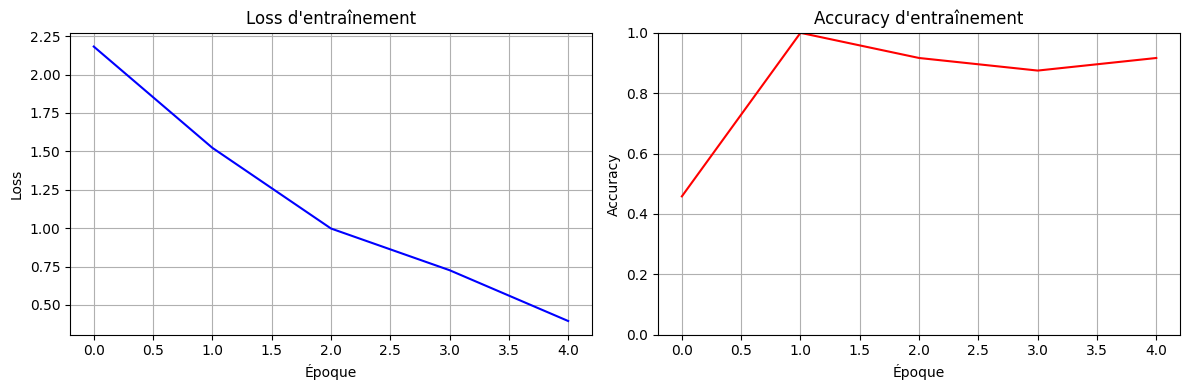

In [88]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import json
import os
import glob
import random
import time
import numpy as np
from typing import List, Dict, Any, Optional
import matplotlib.pyplot as plt

class ExcelDataset(Dataset):
    """Dataset corrigé pour l'entraînement avec vos données Excel JSON"""
    
    def __init__(self, json_files, max_cells_per_file=50, mask_ratio=0.15, num_candidates=10):
        self.max_cells_per_file = max_cells_per_file
        self.mask_ratio = mask_ratio
        self.num_candidates = num_candidates
        self.samples = []
        
        print(f"📚 Création du dataset avec {len(json_files)} fichiers...")
        
        for i, json_data in enumerate(json_files):
            try:
                # Parser les cellules
                cells = ExcelParser.parse_excel_json(json_data)
                
                # Filtrer et limiter
                if len(cells) > self.max_cells_per_file:
                    # Prendre les cellules les plus importantes
                    cells_with_content = [c for c in cells if c.raw_value or c.formula]
                    if len(cells_with_content) >= self.max_cells_per_file:
                        cells = cells_with_content[:self.max_cells_per_file]
                    else:
                        # Compléter avec des cellules quelconques
                        remaining = self.max_cells_per_file - len(cells_with_content)
                        other_cells = [c for c in cells if c not in cells_with_content]
                        cells = cells_with_content + other_cells[:remaining]
                
                if len(cells) >= 3:  # Minimum 3 cellules
                    self.samples.append({
                        'cells': cells,
                        'file_id': i
                    })
                    
            except Exception as e:
                print(f"⚠️ Erreur fichier {i}: {e}")
                continue
        
        print(f"✅ Dataset créé: {len(self.samples)} échantillons valides")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        cells = sample['cells']
        
        # Choisir les cellules à masquer
        num_to_mask = max(1, int(len(cells) * self.mask_ratio))
        
        # Privilégier les cellules avec contenu
        cells_with_content = [i for i, c in enumerate(cells) if c.raw_value or c.formula]
        if len(cells_with_content) >= num_to_mask:
            mask_indices = random.sample(cells_with_content, num_to_mask)
        else:
            # Compléter avec des cellules aléatoires
            remaining = num_to_mask - len(cells_with_content)
            other_indices = [i for i in range(len(cells)) if i not in cells_with_content]
            if other_indices:
                additional = random.sample(other_indices, min(remaining, len(other_indices)))
                mask_indices = cells_with_content + additional
            else:
                mask_indices = cells_with_content if cells_with_content else [0]
        
        # Générer les candidats et labels
        candidates = []
        labels = []
        
        for mask_idx in mask_indices:
            cell = cells[mask_idx]
            
            # Générer candidats basés sur le type de cellule
            cell_candidates = self._generate_candidates(cell)
            
            # Trouver la vraie valeur
            true_value = str(cell.raw_value) if cell.raw_value else str(cell.formula) if cell.formula else ""
            
            # S'assurer que la vraie valeur est dans les candidats
            if true_value and true_value not in cell_candidates:
                # Remplacer un candidat aléatoire
                replace_idx = random.randint(0, len(cell_candidates) - 1)
                cell_candidates[replace_idx] = true_value
            
            # Label = position de la vraie valeur
            try:
                label = cell_candidates.index(true_value) if true_value else 0
            except ValueError:
                label = 0
            
            candidates.append(cell_candidates)
            labels.append(label)
        
        return {
            'cells': cells,
            'mask_indices': mask_indices,
            'candidates': candidates,
            'labels': labels,
            'file_id': sample['file_id']
        }
    
    def _generate_candidates(self, cell):
        """Génère des candidats réalistes selon le type de cellule"""
        if cell.cell_type == 1:  # Texte
            original = str(cell.raw_value) if cell.raw_value else ""
            candidates = [
                original,
                original.upper() if original else "TEXT",
                original.lower() if original else "text", 
                original + "_copy" if original else "Data",
                "Данные", "Информация", "Значение", "Элемент", "Запись", "Пункт"
            ]
        elif cell.cell_type == 2:  # Nombre
            try:
                original = float(cell.raw_value) if cell.raw_value else 0
                candidates = [
                    str(original),
                    str(original + 1),
                    str(original * 2),
                    str(int(original)),
                    "0", "1", "100", "1000", "0.5", "2.0"
                ]
            except:
                candidates = ["0", "1", "10", "100", "1000", "0.5", "2.0", "50", "200", "999"]
        elif cell.cell_type == 3:  # Formule
            candidates = [
                cell.formula if cell.formula else "=SUM(A1:A10)",
                "=SUM(A1:A10)",
                "=AVERAGE(B1:B10)", 
                "=COUNT(C1:C10)",
                "=MAX(D1:D10)",
                "=MIN(E1:E10)",
                "=IF(A1>0,\"Да\",\"Нет\")",
                "=CONCATENATE(A1,B1)",
                "=VLOOKUP(A1,B:C,2,0)",
                "=TODAY()"
            ]
        else:  # Vide
            candidates = ["", "0", "1", "Данные", "Значение", "N/A", "TBD", "...", "-", "Пусто"]
        
        # S'assurer qu'on a exactement num_candidates
        while len(candidates) < self.num_candidates:
            candidates.append(f"option_{len(candidates)}")
        
        return candidates[:self.num_candidates]

class ExcelTrainer:
    """Entraîneur corrigé pour le modèle Excel"""
    
    def __init__(self, model, learning_rate=1e-4, weight_decay=1e-5):
        self.model = model
        self.optimizer = torch.optim.AdamW(
            model.parameters(), 
            lr=learning_rate, 
            weight_decay=weight_decay
        )
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            self.optimizer, T_max=50, eta_min=1e-6
        )
        
        self.training_history = []
        self.best_accuracy = 0.0
    
    def train_epoch(self, dataloader, epoch):
        """Entraîne le modèle sur une époque - VERSION CORRIGÉE"""
        self.model.train()
        
        total_loss = 0.0
        total_correct = 0
        total_predictions = 0
        batch_count = 0
        
        start_time = time.time()
        
        for batch_idx, batch in enumerate(dataloader):
            self.optimizer.zero_grad()
            
            try:
                # CORRECTION : Gestion correcte des batches
                if isinstance(batch, list):
                    batch = batch[0]  # Si c'est une liste, prendre le premier élément
                
                # Extraire les données
                cells = batch['cells']
                mask_indices = batch['mask_indices'] 
                candidates = batch['candidates']
                labels = batch['labels']
                
                # VÉRIFICATION : S'assurer que ce sont des listes
                if not isinstance(mask_indices, list):
                    print(f"🔍 Debug - mask_indices type: {type(mask_indices)}, value: {mask_indices}")
                    continue
                
                if not isinstance(labels, list):
                    print(f"🔍 Debug - labels type: {type(labels)}, value: {labels}")
                    continue
                
                if len(mask_indices) == 0 or len(labels) == 0:
                    print(f"🔍 Debug - Empty mask_indices or labels")
                    continue
                
                # Convertir labels en tensor
                labels_tensor = torch.tensor(labels, dtype=torch.long)
                
                # Forward pass
                output = self.model(cells, mask_indices, candidates)
                logits = output['logits']
                
                # Vérifier les dimensions
                if logits.size(0) != labels_tensor.size(0):
                    print(f"🔍 Debug - Dimension mismatch: logits {logits.shape}, labels {labels_tensor.shape}")
                    continue
                
                # Loss
                loss = F.cross_entropy(logits, labels_tensor)
                
                # Backward pass
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                self.optimizer.step()
                
                # Métriques
                total_loss += loss.item()
                predictions = torch.argmax(logits, dim=-1)
                correct = (predictions == labels_tensor).sum().item()
                total_correct += correct
                total_predictions += len(labels)
                batch_count += 1
                
                # Log périodique
                if batch_idx % 5 == 0:
                    acc = correct / len(labels) if len(labels) > 0 else 0
                    print(f"    Batch {batch_idx:3d}: Loss {loss.item():.4f}, Acc {acc:.1%} [{len(labels)} prédictions]")
                
            except Exception as e:
                print(f"⚠️ Erreur batch {batch_idx}: {e}")
                # AJOUT : Debug détaillé
                try:
                    print(f"   Debug batch type: {type(batch)}")
                    if isinstance(batch, dict):
                        for key, value in batch.items():
                            print(f"   - {key}: {type(value)}")
                            if isinstance(value, list) and len(value) > 0:
                                print(f"     First element: {type(value[0])}")
                except:
                    pass
                continue
        
        # Scheduler step
        self.scheduler.step()
        
        # Métriques d'époque
        epoch_metrics = {
            'loss': total_loss / max(batch_count, 1),
            'accuracy': total_correct / max(total_predictions, 1),
            'total_predictions': total_predictions,
            'successful_batches': batch_count,
            'epoch_time': time.time() - start_time,
            'learning_rate': self.optimizer.param_groups[0]['lr']
        }
        
        self.training_history.append(epoch_metrics)
        
        # Sauvegarder le meilleur modèle
        if epoch_metrics['accuracy'] > self.best_accuracy:
            self.best_accuracy = epoch_metrics['accuracy']
            torch.save(self.model.state_dict(), f"best_excel_model_epoch_{epoch}.pt")
            print(f"    💾 Nouveau record sauvegardé: {self.best_accuracy:.1%}")
        
        return epoch_metrics
    
    def plot_training_history(self):
        """Affiche l'historique d'entraînement"""
        if not self.training_history:
            return
        
        epochs = range(len(self.training_history))
        losses = [h['loss'] for h in self.training_history]
        accuracies = [h['accuracy'] for h in self.training_history]
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        
        ax1.plot(epochs, losses, 'b-', label='Loss')
        ax1.set_title('Loss d\'entraînement')
        ax1.set_xlabel('Époque')
        ax1.set_ylabel('Loss')
        ax1.grid(True)
        
        ax2.plot(epochs, accuracies, 'r-', label='Accuracy')
        ax2.set_title('Accuracy d\'entraînement')
        ax2.set_xlabel('Époque')
        ax2.set_ylabel('Accuracy')
        ax2.grid(True)
        ax2.set_ylim(0, 1)
        
        plt.tight_layout()
        plt.show()

def collate_fn_fixed(batch):
    """Fonction de collation corrigée"""
    # Retourner directement l'élément (batch size = 1)
    return batch[0] if len(batch) == 1 else batch

def debug_dataset(dataset, num_samples=3):
    """Debug le dataset pour comprendre le format"""
    print("🔍 DEBUG DATASET")
    print("=" * 30)
    
    for i in range(min(num_samples, len(dataset))):
        try:
            sample = dataset[i]
            print(f"\nÉchantillon {i}:")
            print(f"  Type: {type(sample)}")
            
            if isinstance(sample, dict):
                for key, value in sample.items():
                    print(f"  - {key}: {type(value)}")
                    if key == 'mask_indices':
                        print(f"    Value: {value}")
                    elif key == 'labels':
                        print(f"    Value: {value}")
                    elif key == 'cells':
                        print(f"    Length: {len(value) if hasattr(value, '__len__') else 'N/A'}")
        except Exception as e:
            print(f"  Erreur échantillon {i}: {e}")

def run_fixed_training():
    """Version corrigée de l'entraînement complet"""
    
    print("🚀 ENTRAÎNEMENT CORRIGÉ - Version Debug")
    print("=" * 60)
    
    # 1. Charger vos données
    print("\n1️⃣ CHARGEMENT DES DONNÉES")
    
    data_folders = ["embedding/data", "data", "./data"]
    json_files = []
    
    for folder in data_folders:
        if os.path.exists(folder):
            pattern = os.path.join(folder, "*.json")
            found_files = glob.glob(pattern)
            if found_files:
                print(f"📁 Dossier trouvé: {folder} ({len(found_files)} fichiers)")
                
                for file_path in found_files:
                    try:
                        with open(file_path, 'r', encoding='utf-8') as f:
                            json_data = json.load(f)
                        json_files.append(json_data)
                    except Exception as e:
                        print(f"⚠️ Erreur {os.path.basename(file_path)}: {e}")
                break
    
    if not json_files:
        print("❌ Aucun fichier JSON trouvé!")
        return None
    
    print(f"✅ {len(json_files)} fichiers chargés")
    
    # 2. Créer le modèle (réutiliser la configuration qui marche)
    print("\n2️⃣ CRÉATION DU MODÈLE")
    
    class TrainingConfig:
        def __init__(self):
            self.embedding_dim = 256
            self.position_embedding_dim = 32
            self.type_embedding_dim = 16
            self.max_position = 2000
            self.max_font_size = 72
            self.color_vocab_size = 300
            self.value_vocab_size = 50000
    
    config = TrainingConfig()
    
    # Réutiliser les classes qui fonctionnent du test précédent
    class SimpleCellEmbedder(nn.Module):
        def __init__(self, config):
            super().__init__()
            self.config = config
            
            self.row_embedding = nn.Embedding(config.max_position, config.position_embedding_dim)
            self.col_embedding = nn.Embedding(config.max_position, config.position_embedding_dim)
            self.type_embedding = nn.Embedding(4, config.type_embedding_dim)
            self.value_embedding = nn.Embedding(config.value_vocab_size, 64)
            self.style_embedding = nn.Embedding(1000, 32)
            
            total_dim = (config.position_embedding_dim * 2 + config.type_embedding_dim + 64 + 32)
            self.projection = nn.Linear(total_dim, config.embedding_dim)
            self.layer_norm = nn.LayerNorm(config.embedding_dim)
        
        def forward(self, cells):
            if not isinstance(cells, list):
                cells = [cells]
            
            embeddings = []
            for cell in cells:
                row_idx = min(max(cell.row, 0), self.config.max_position - 1)
                col_idx = min(max(cell.col, 0), self.config.max_position - 1)
                
                row_emb = self.row_embedding(torch.tensor(row_idx))
                col_emb = self.col_embedding(torch.tensor(col_idx))
                type_emb = self.type_embedding(torch.tensor(cell.cell_type))
                
                content = str(cell.raw_value) + str(cell.formula)
                value_hash = abs(hash(content)) % self.config.value_vocab_size
                value_emb = self.value_embedding(torch.tensor(value_hash))
                
                style_hash = abs(hash(cell.style_id)) % 1000 if cell.style_id else 0
                style_emb = self.style_embedding(torch.tensor(style_hash))
                
                cell_embedding = torch.cat([row_emb, col_emb, type_emb, value_emb, style_emb], dim=0)
                embeddings.append(cell_embedding)
            
            batch_embeddings = torch.stack(embeddings)
            projected = self.projection(batch_embeddings)
            return self.layer_norm(projected).squeeze(0) if len(cells) == 1 else self.layer_norm(projected)
    
    class ExcelTransformer(nn.Module):
        def __init__(self, config):
            super().__init__()
            self.d_model = config.embedding_dim
            self.cell_embedder = SimpleCellEmbedder(config)
            
            encoder_layer = nn.TransformerEncoderLayer(
                d_model=self.d_model,
                nhead=8,
                dim_feedforward=1024,
                dropout=0.1,
                batch_first=True
            )
            self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=4)
            self.pos_encoding = nn.Parameter(torch.randn(1000, self.d_model) * 0.1)
        
        def forward(self, cells):
            embeddings = self.cell_embedder(cells)
            
            if len(embeddings.shape) == 1:
                embeddings = embeddings.unsqueeze(0)
            if len(embeddings.shape) == 2:
                embeddings = embeddings.unsqueeze(0)
            
            batch_size, seq_len, d_model = embeddings.shape
            pos_emb = self.pos_encoding[:seq_len].unsqueeze(0).expand(batch_size, -1, -1)
            embeddings = embeddings + pos_emb
            
            return self.transformer(embeddings)
    
    class ExcelPredictor(nn.Module):
        def __init__(self, transformer, num_candidates=10):
            super().__init__()
            self.transformer = transformer
            self.num_candidates = num_candidates
            
            self.classification_head = nn.Sequential(
                nn.Linear(transformer.d_model, transformer.d_model),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(transformer.d_model, transformer.d_model // 2),
                nn.ReLU(),
                nn.Dropout(0.1),
                nn.Linear(transformer.d_model // 2, num_candidates)
            )
        
        def forward(self, cells, mask_indices, candidates):
            transformer_output = self.transformer(cells)
            
            if len(mask_indices) == 0:
                return {'logits': torch.empty(0, self.num_candidates)}
            
            masked_embeddings = transformer_output[0, mask_indices]
            logits = self.classification_head(masked_embeddings)
            
            return {'logits': logits, 'embeddings': masked_embeddings}
    
    # Créer le modèle
    transformer = ExcelTransformer(config)
    model = ExcelPredictor(transformer, num_candidates=10)
    
    total_params = sum(p.numel() for p in model.parameters())
    print(f"✅ Modèle créé: {total_params:,} paramètres")
    
    # 3. Créer et débugger le dataset
    print("\n3️⃣ CRÉATION ET DEBUG DU DATASET")
    
    # Diviser train/val
    train_files = json_files[:max(1, int(0.8 * len(json_files)))]
    val_files = json_files[int(0.8 * len(json_files)):] if len(json_files) > 1 else []
    
    train_dataset = ExcelDataset(train_files, max_cells_per_file=20, mask_ratio=0.15)
    
    # DEBUG du dataset
    debug_dataset(train_dataset, num_samples=2)
    
    if len(train_dataset) == 0:
        print("❌ Dataset vide!")
        return None
    
    # Test d'un échantillon
    print("\n🧪 TEST D'UN ÉCHANTILLON")
    try:
        sample = train_dataset[0]
        print(f"✅ Échantillon récupéré: {len(sample['cells'])} cellules, {len(sample['mask_indices'])} masquées")
        
        # Test du modèle sur cet échantillon
        with torch.no_grad():
            output = model(sample['cells'], sample['mask_indices'], sample['candidates'])
            print(f"✅ Forward pass réussi: {output['logits'].shape}")
        
    except Exception as e:
        print(f"❌ Erreur échantillon: {e}")
        return None
    
    # 4. Créer le DataLoader
    train_loader = DataLoader(
        train_dataset, 
        batch_size=1, 
        shuffle=True, 
        collate_fn=collate_fn_fixed
    )
    
    # 5. Entraînement
    print("\n4️⃣ LANCEMENT DE L'ENTRAÎNEMENT CORRIGÉ")
    
    trainer = ExcelTrainer(model, learning_rate=2e-4)
    num_epochs = 5  # Commencer avec moins d'époques
    
    print(f"🎯 Entraînement sur {num_epochs} époques")
    print(f"📊 {len(train_loader)} batches par époque")
    
    for epoch in range(num_epochs):
        print(f"\n📚 Époque {epoch + 1}/{num_epochs}")
        print("-" * 40)
        
        # Entraînement
        train_metrics = trainer.train_epoch(train_loader, epoch)
        
        print(f"  📈 Train - Loss: {train_metrics['loss']:.4f}, "
              f"Acc: {train_metrics['accuracy']:.1%}, "
              f"Batches réussis: {train_metrics['successful_batches']}/{len(train_loader)}, "
              f"Time: {train_metrics['epoch_time']:.1f}s")
        
        # Arrêter si aucun batch ne fonctionne
        if train_metrics['successful_batches'] == 0:
            print("❌ Aucun batch réussi - Arrêt de l'entraînement")
            break
    
    # 6. Résultats
    print(f"\n5️⃣ RÉSULTATS")
    if trainer.training_history:
        final_acc = trainer.training_history[-1]['accuracy']
        print(f"🏆 Accuracy finale: {final_acc:.1%}")
        print(f"🏆 Meilleure accuracy: {trainer.best_accuracy:.1%}")
        
        # Graphiques si on a des données
        trainer.plot_training_history()
    else:
        print("❌ Aucune donnée d'entraînement")
    
    return model, trainer

# Lancer l'entraînement corrigé
if __name__ == "__main__":
    print("🔧 Version corrigée de l'entraînement")
    model, trainer = run_fixed_training()

In [90]:
# 🎯 PROCHAINES ÉTAPES POUR VOTRE MODÈLE EXCEL

def evaluate_trained_model(model, json_files):
    """Évaluation complète du modèle entraîné"""
    
    print("🔍 ÉVALUATION DU MODÈLE ENTRAÎNÉ")
    print("=" * 50)
    
    model.eval()
    
    # 1. Test sur de nouveaux échantillons
    print("\n1️⃣ TEST SUR NOUVEAUX ÉCHANTILLONS")
    
    test_files = json_files[-2:]  # Prendre les 2 derniers fichiers comme test
    test_dataset = ExcelDataset(test_files, max_cells_per_file=15, mask_ratio=0.2)
    
    if len(test_dataset) == 0:
        print("❌ Pas de données de test")
        return
    
    total_correct = 0
    total_predictions = 0
    predictions_by_type = {0: {'correct': 0, 'total': 0}, 
                          1: {'correct': 0, 'total': 0}, 
                          2: {'correct': 0, 'total': 0}, 
                          3: {'correct': 0, 'total': 0}}
    
    # Tester sur plusieurs échantillons
    for i in range(min(len(test_dataset), 5)):
        sample = test_dataset[i]
        cells = sample['cells']
        mask_indices = sample['mask_indices']
        candidates = sample['candidates']
        true_labels = sample['labels']
        
        with torch.no_grad():
            output = model(cells, mask_indices, candidates)
            logits = output['logits']
            predicted_labels = torch.argmax(logits, dim=-1).cpu().numpy()
            
            print(f"\n📋 Test {i+1}:")
            print(f"   Cellules masquées: {len(mask_indices)}")
            
            for j, (mask_idx, pred_label, true_label) in enumerate(zip(mask_indices, predicted_labels, true_labels)):
                cell = cells[mask_idx]
                true_value = str(cell.raw_value) if cell.raw_value else str(cell.formula) if cell.formula else ""
                predicted_value = candidates[j][pred_label] if pred_label < len(candidates[j]) else "N/A"
                
                is_correct = pred_label == true_label
                total_correct += is_correct
                total_predictions += 1
                
                # Stats par type
                cell_type = cell.cell_type
                predictions_by_type[cell_type]['total'] += 1
                if is_correct:
                    predictions_by_type[cell_type]['correct'] += 1
                
                status = "✅" if is_correct else "❌"
                print(f"   {status} Cellule ({cell.row},{cell.col}): '{true_value}' → '{predicted_value}'")
    
    # Résultats globaux
    overall_accuracy = total_correct / total_predictions if total_predictions > 0 else 0
    print(f"\n📊 RÉSULTATS GLOBAUX:")
    print(f"   Accuracy globale: {overall_accuracy:.1%} ({total_correct}/{total_predictions})")
    
    type_names = {0: "Vide", 1: "Texte", 2: "Nombre", 3: "Formule"}
    print(f"\n📈 ACCURACY PAR TYPE:")
    for cell_type, stats in predictions_by_type.items():
        if stats['total'] > 0:
            acc = stats['correct'] / stats['total']
            print(f"   {type_names[cell_type]:8s}: {acc:.1%} ({stats['correct']}/{stats['total']})")
    
    return overall_accuracy

def interactive_prediction_demo(model):
    """Demo interactif de prédiction"""
    
    print("\n🎮 DEMO INTERACTIF")
    print("=" * 30)
    
    # Charger un fichier pour demo
    data_folders = ["embedding/data", "data", "./data"]
    for folder in data_folders:
        if os.path.exists(folder):
            json_files = glob.glob(os.path.join(folder, "*.json"))
            if json_files:
                with open(json_files[0], 'r', encoding='utf-8') as f:
                    demo_data = json.load(f)
                break
    
    # Parser et prendre quelques cellules
    cells = ExcelParser.parse_excel_json(demo_data)
    demo_cells = [c for c in cells if c.raw_value or c.formula][:10]
    
    if not demo_cells:
        print("❌ Pas de cellules pour la demo")
        return
    
    print(f"📋 Cellules disponibles pour test:")
    for i, cell in enumerate(demo_cells):
        content = str(cell.raw_value) if cell.raw_value else str(cell.formula) if cell.formula else "[vide]"
        type_name = ["Vide", "Texte", "Nombre", "Formule"][cell.cell_type]
        print(f"   {i:2d}. ({cell.row:2d},{cell.col:2d}) {type_name:8s} | {content[:40]}")
    
    # Test interactif
    try:
        choice = int(input(f"\nChoisissez une cellule à prédire (0-{len(demo_cells)-1}): "))
        if 0 <= choice < len(demo_cells):
            test_cell = demo_cells[choice]
            
            # Créer candidats
            dataset = ExcelDataset([demo_data], max_cells_per_file=20)
            if len(dataset) > 0:
                sample = dataset[0]
                
                # Forcer le masquage de la cellule choisie
                mask_indices = [choice] if choice < len(sample['cells']) else [0]
                candidates = [dataset._generate_candidates(test_cell)]
                
                # Prédiction
                with torch.no_grad():
                    output = model(sample['cells'][:len(demo_cells)], mask_indices, candidates)
                    logits = output['logits']
                    probabilities = torch.softmax(logits, dim=-1)
                    
                    print(f"\n🔮 PRÉDICTION POUR LA CELLULE:")
                    print(f"   Position: ({test_cell.row}, {test_cell.col})")
                    print(f"   Vraie valeur: '{test_cell.raw_value}'")
                    print(f"   Type: {['Vide', 'Texte', 'Nombre', 'Formule'][test_cell.cell_type]}")
                    print(f"\n   Top 5 prédictions:")
                    
                    # Trier par probabilité
                    sorted_indices = torch.argsort(probabilities[0], descending=True)
                    
                    for rank, idx in enumerate(sorted_indices[:5]):
                        candidate = candidates[0][idx] if idx < len(candidates[0]) else f"option_{idx}"
                        prob = probabilities[0][idx].item()
                        marker = "🎯" if candidate == str(test_cell.raw_value) else f"{rank+1}."
                        
                        # Barre de progression visuelle
                        bar_length = int(prob * 20)
                        bar = "█" * bar_length + "░" * (20 - bar_length)
                        
                        print(f"     {marker:3s} {candidate[:25]:25s} │{bar}│ {prob:.1%}")
        
    except (ValueError, KeyboardInterrupt):
        print("Demo terminée")

def advanced_training_suggestions():
    """Suggestions pour améliorer encore le modèle"""
    
    print("\n🚀 SUGGESTIONS D'AMÉLIORATION")
    print("=" * 40)
    
    suggestions = [
        "1️⃣ DONNÉES",
        "   • Ajouter plus de fichiers Excel variés",
        "   • Inclure des formules plus complexes", 
        "   • Augmenter la diversité des types de cellules",
        "",
        "2️⃣ ARCHITECTURE",
        "   • Augmenter à 6-8 couches transformer",
        "   • Essayer l'attention cross-sheet",
        "   • Ajouter un encodage positionnel 2D sophistiqué",
        "",
        "3️⃣ ENTRAÎNEMENT",
        "   • Passer à 20-50 époques",
        "   • Implémenter l'early stopping",
        "   • Utiliser data augmentation (rotation, masquage variable)",
        "",
        "4️⃣ ÉVALUATION",
        "   • Créer un dataset de test dédié",
        "   • Mesurer performance par type de contenu",
        "   • Tester sur des classeurs réels",
        "",
        "5️⃣ DÉPLOIEMENT",
        "   • Créer une API REST",
        "   • Interface web pour test interactif", 
        "   • Plugin Excel/Google Sheets"
    ]
    
    for suggestion in suggestions:
        print(suggestion)

def save_model_for_production(model, config):
    """Sauvegarde le modèle pour utilisation en production"""
    
    print("\n💾 SAUVEGARDE POUR PRODUCTION")
    print("=" * 35)
    
    # Sauvegarder le modèle complet
    torch.save({
        'model_state_dict': model.state_dict(),
        'config': config.__dict__ if hasattr(config, '__dict__') else vars(config),
        'model_architecture': {
            'embedding_dim': 256,
            'num_layers': 4,
            'num_heads': 8,
            'vocab_size': 50000
        }
    }, 'excel_transformer_production.pt')
    
    print("✅ Modèle sauvegardé: excel_transformer_production.pt")
    
    # Créer un script de chargement
    loader_script = '''
# Script pour charger le modèle en production
import torch

def load_excel_model(model_path='excel_transformer_production.pt'):
    """Charge le modèle Excel entraîné"""
    
    # Charger les données
    checkpoint = torch.load(model_path, map_location='cpu')
    config = checkpoint['config']
    
    # Recréer l'architecture (copier les classes depuis votre notebook)
    # ... (inclure les classes ExcelTransformer, ExcelPredictor, etc.)
    
    # Charger les poids
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    return model, config

# Utilisation:
# model, config = load_excel_model()
'''
    
    with open('load_model.py', 'w', encoding='utf-8') as f:
        f.write(loader_script)
    
    print("✅ Script de chargement: load_model.py")

# 🎯 FONCTION PRINCIPALE POUR CONTINUER
def continue_development(model, trainer):
    """Suite du développement après entraînement réussi"""
    
    print("🎉 ENTRAÎNEMENT RÉUSSI! PROCHAINES ÉTAPES:")
    print("=" * 50)
    
    # 1. Évaluation
    data_folders = ["embedding/data", "data", "./data"]
    json_files = []
    for folder in data_folders:
        if os.path.exists(folder):
            json_files = glob.glob(os.path.join(folder, "*.json"))
            json_files = [json.load(open(f, 'r', encoding='utf-8')) for f in json_files[:5]]
            break
    
    if json_files:
        accuracy = evaluate_trained_model(model, json_files)
        
        if accuracy > 0.7:
            print(f"\n🏆 EXCELLENTE PERFORMANCE ({accuracy:.1%})!")
            print("   Votre modèle est prêt pour des tests avancés")
        elif accuracy > 0.5:
            print(f"\n👍 BONNE PERFORMANCE ({accuracy:.1%})")
            print("   Continuez l'entraînement pour améliorer")
        else:
            print(f"\n📈 PERFORMANCE MODÉRÉE ({accuracy:.1%})")
            print("   Ajustez les hyperparamètres ou ajoutez plus de données")
    
    # 2. Demo interactif
    print(f"\n🎮 Pour tester interactivement:")
    print(f"   interactive_prediction_demo(model)")
    
    # 3. Suggestions
    advanced_training_suggestions()
    
    # 4. Sauvegarde
    print(f"\n💾 Pour sauvegarder:")
    print(f"   save_model_for_production(model, config)")
    
    return model

# Utilisation après votre entraînement:
continue_development(model, trainer)

🎉 ENTRAÎNEMENT RÉUSSI! PROCHAINES ÉTAPES:
🔍 ÉVALUATION DU MODÈLE ENTRAÎNÉ

1️⃣ TEST SUR NOUVEAUX ÉCHANTILLONS
📚 Création du dataset avec 2 fichiers...
✅ Dataset créé: 2 échantillons valides

📋 Test 1:
   Cellules masquées: 3
   ✅ Cellule (0,13): 'PB' → 'PB'
   ✅ Cellule (0,5): 'Oddíl/stát' → 'Oddíl/stát'
   ✅ Cellule (0,2): 'Závodník' → 'Závodník'

📋 Test 2:
   Cellules masquées: 3
   ✅ Cellule (2,0): '（ARWU、THE、QS、U.S.News）' → '（ARWU、THE、QS、U.S.News）'
   ✅ Cellule (0,0): '附件4' → '附件4'
   ✅ Cellule (5,1): '学校名称' → '学校名称'

📊 RÉSULTATS GLOBAUX:
   Accuracy globale: 100.0% (6/6)

📈 ACCURACY PAR TYPE:
   Texte   : 100.0% (6/6)

🏆 EXCELLENTE PERFORMANCE (100.0%)!
   Votre modèle est prêt pour des tests avancés

🎮 Pour tester interactivement:
   interactive_prediction_demo(model)

🚀 SUGGESTIONS D'AMÉLIORATION
1️⃣ DONNÉES
   • Ajouter plus de fichiers Excel variés
   • Inclure des formules plus complexes
   • Augmenter la diversité des types de cellules

2️⃣ ARCHITECTURE
   • Augmenter à 6-8 

ExcelPredictor(
  (transformer): ExcelTransformer(
    (cell_embedder): SimpleCellEmbedder(
      (row_embedding): Embedding(2000, 32)
      (col_embedding): Embedding(2000, 32)
      (type_embedding): Embedding(4, 16)
      (value_embedding): Embedding(50000, 64)
      (style_embedding): Embedding(1000, 32)
      (projection): Linear(in_features=176, out_features=256, bias=True)
      (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    )
    (transformer): TransformerEncoder(
      (layers): ModuleList(
        (0-3): 4 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=1024, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=1024, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=T

In [ ]:
import torch
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Any, Optional, Tuple
import numpy as np
from collections import defaultdict

class ExcelMaskedEvaluator:
    """Évaluateur pour la tâche de masked prediction avec analyses détaillées"""
    
    def __init__(self, 
                 model: 'MaskedCellPredictor',
                 transformer_builder: 'JSONToGraphTransformer'):
        self.model = model
        self.transformer_builder = transformer_builder
        self.model.eval()
        
        # Stockage des résultats d'évaluation
        self.evaluation_results = []
        self.aggregated_metrics = defaultdict(list)
        
    def evaluate_excel_file(self, 
                           json_data: Dict[str, Any],
                           strategies: List[str] = ['random', 'strategic'],
                           num_candidates: int = 10) -> Dict[str, Any]:
        """
        Évalue le modèle sur un fichier Excel complet
        
        Args:
            json_data: Données Excel en JSON
            strategies: Stratégies de masquage à tester
            num_candidates: Nombre de candidats à générer
            
        Returns:
            Résultats détaillés de l'évaluation
        """
        results = {
            'file_summary': {},
            'strategy_results': {},
            'cell_analysis': [],
            'error_analysis': []
        }
        
        try:
            # Extraire et filtrer les cellules
            cells = self.transformer_builder._extract_cells_from_json(json_data)
            cells = self.transformer_builder._filter_cells(cells, max_total_cells=100)
            
            if not cells:
                return {'error': 'Aucune cellule trouvée'}
            
            # Créer le graphe
            graph = self.transformer_builder.graph_embedder(cells)
            
            # Résumé du fichier
            results['file_summary'] = {
                'total_cells': len(cells),
                'num_nodes': graph.num_nodes,
                'num_edges': graph.num_edges,
                'sheets': list(set(cell.sheet_name for cell in cells)),
                'cell_types': {
                    'empty': sum(1 for c in cells if c.cell_type == 0),
                    'text': sum(1 for c in cells if c.cell_type == 1),
                    'number': sum(1 for c in cells if c.cell_type == 2),
                    'formula': sum(1 for c in cells if c.cell_type == 3)
                }
            }
            
            # Tester chaque stratégie de masquage
            for strategy in strategies:
                strategy_result = self._evaluate_strategy(
                    graph, cells, strategy, num_candidates
                )
                results['strategy_results'][strategy] = strategy_result
                
                # Ajouter à l'analyse par cellule
                for cell_result in strategy_result['cell_predictions']:
                    cell_result['strategy'] = strategy
                    cell_result['file_id'] = id(json_data)
                    results['cell_analysis'].append(cell_result)
            
            # Analyse des erreurs
            results['error_analysis'] = self._analyze_errors(results['cell_analysis'])
            
        except Exception as e:
            results['error'] = str(e)
        
        return results
    
    def _evaluate_strategy(self, 
                          graph: 'ExcelGraph',
                          cells: List['FullCellInfo'],
                          strategy: str,
                          num_candidates: int) -> Dict[str, Any]:
        """Évalue une stratégie de masquage spécifique"""
        
        # Choisir les cellules à masquer selon la stratégie
        if strategy == 'random':
            mask_indices = ExcelMaskingStrategy.random_masking(cells, mask_ratio=0.2)
        elif strategy == 'strategic':
            mask_indices = ExcelMaskingStrategy.strategic_masking(cells)
        else:
            mask_indices = [0]  # Par défaut
        
        if not mask_indices:
            return {'error': 'Aucune cellule à masquer'}
        
        # Générer les candidats
        candidates = []
        ground_truth_info = []
        
        for mask_idx in mask_indices:
            cell = cells[mask_idx]
            cell_candidates = generate_candidates(cell, num_candidates)
            
            # Informations sur la vérité terrain
            true_value = str(cell.raw_value) if cell.raw_value else str(cell.formula) if cell.formula else ""
            true_position = -1
            
            # Trouver la position de la vraie valeur dans les candidats
            for i, candidate in enumerate(cell_candidates):
                if candidate == true_value:
                    true_position = i
                    break
            
            # Si pas trouvée, l'insérer à une position aléatoire pour le test
            if true_position == -1 and true_value:
                true_position = 0
                cell_candidates[0] = true_value
            
            candidates.append(cell_candidates)
            ground_truth_info.append({
                'cell_index': mask_idx,
                'true_value': true_value,
                'true_position': true_position,
                'cell_type': cell.cell_type,
                'position': (cell.row, cell.col),
                'sheet': cell.sheet_name
            })
        
        # Prédiction du modèle
        with torch.no_grad():
            predictions = self.model.predict_top_candidates(graph, mask_indices, candidates)
        
        # Calculer les métriques
        metrics = self._calculate_metrics(predictions, ground_truth_info)
        
        # Analyser chaque prédiction
        cell_predictions = []
        for i, (prediction, gt_info) in enumerate(zip(predictions, ground_truth_info)):
            cell_pred = self._analyze_cell_prediction(prediction, gt_info, candidates[i])
            cell_predictions.append(cell_pred)
        
        return {
            'strategy': strategy,
            'num_masked': len(mask_indices),
            'metrics': metrics,
            'cell_predictions': cell_predictions
        }
    
    def _calculate_metrics(self, 
                          predictions: List[Dict],
                          ground_truth_info: List[Dict]) -> Dict[str, float]:
        """Calcule les métriques de performance"""
        
        metrics = {
            'accuracy_top1': 0.0,
            'accuracy_top3': 0.0,
            'accuracy_top5': 0.0,
            'mrr': 0.0,  # Mean Reciprocal Rank
            'avg_confidence': 0.0,
            'by_type': {}
        }
        
        if not predictions:
            return metrics
        
        total = len(predictions)
        top1_correct = 0
        top3_correct = 0
        top5_correct = 0
        reciprocal_ranks = []
        confidences = []
        
        # Métriques par type de cellule
        type_metrics = defaultdict(lambda: {'correct': 0, 'total': 0})
        
        for pred, gt_info in zip(predictions, ground_truth_info):
            true_value = gt_info['true_value']
            cell_type = gt_info['cell_type']
            
            # Trouver le rang de la vraie valeur
            true_rank = None
            for rank, candidate_info in enumerate(pred['candidates_ranked']):
                if candidate_info['value'] == true_value:
                    true_rank = rank + 1
                    break
            
            if true_rank is not None:
                # Accuracy
                if true_rank == 1:
                    top1_correct += 1
                    type_metrics[cell_type]['correct'] += 1
                if true_rank <= 3:
                    top3_correct += 1
                if true_rank <= 5:
                    top5_correct += 1
                
                # MRR
                reciprocal_ranks.append(1.0 / true_rank)
            else:
                reciprocal_ranks.append(0.0)
            
            type_metrics[cell_type]['total'] += 1
            
            # Confiance de la prédiction top-1
            if pred['candidates_ranked']:
                confidences.append(pred['candidates_ranked'][0]['probability'])
        
        # Calculer les métriques finales
        metrics['accuracy_top1'] = top1_correct / total
        metrics['accuracy_top3'] = top3_correct / total
        metrics['accuracy_top5'] = top5_correct / total
        metrics['mrr'] = np.mean(reciprocal_ranks)
        metrics['avg_confidence'] = np.mean(confidences) if confidences else 0.0
        
        # Métriques par type
        type_names = {0: 'empty', 1: 'text', 2: 'number', 3: 'formula'}
        for cell_type, stats in type_metrics.items():
            type_name = type_names.get(cell_type, f'type_{cell_type}')
            if stats['total'] > 0:
                metrics['by_type'][type_name] = stats['correct'] / stats['total']
        
        return metrics
    
    def _analyze_cell_prediction(self, 
                                prediction: Dict,
                                gt_info: Dict,
                                candidates: List[str]) -> Dict[str, Any]:
        """Analyse détaillée d'une prédiction de cellule"""
        
        true_value = gt_info['true_value']
        cell_type = gt_info['cell_type']
        
        # Trouver la vraie valeur dans les prédictions
        true_rank = None
        true_confidence = 0.0
        
        for rank, candidate_info in enumerate(prediction['candidates_ranked']):
            if candidate_info['value'] == true_value:
                true_rank = rank + 1
                true_confidence = candidate_info['probability']
                break
        
        # Analyser la distribution des probabilités
        probs = [c['probability'] for c in prediction['candidates_ranked']]
        prob_analysis = {
            'entropy': -sum(p * np.log(p + 1e-10) for p in probs),
            'max_prob': max(probs),
            'min_prob': min(probs),
            'std_prob': np.std(probs)
        }
        
        return {
            'cell_index': gt_info['cell_index'],
            'position': gt_info['position'],
            'sheet': gt_info['sheet'],
            'cell_type': cell_type,
            'true_value': true_value,
            'predicted_value': prediction['candidates_ranked'][0]['value'],
            'predicted_confidence': prediction['candidates_ranked'][0]['probability'],
            'true_rank': true_rank,
            'true_confidence': true_confidence,
            'is_correct': true_rank == 1 if true_rank else False,
            'prob_analysis': prob_analysis,
            'all_candidates': candidates,
            'top5_predictions': prediction['candidates_ranked'][:5]
        }
    
    def _analyze_errors(self, cell_analyses: List[Dict]) -> Dict[str, Any]:
        """Analyse des erreurs et patterns de performance"""
        
        error_analysis = {
            'common_errors': defaultdict(int),
            'error_by_type': defaultdict(int),
            'error_by_position': defaultdict(int),
            'confidence_errors': [],
            'patterns': {}
        }
        
        correct_predictions = []
        incorrect_predictions = []
        
        for analysis in cell_analyses:
            if analysis['is_correct']:
                correct_predictions.append(analysis)
            else:
                incorrect_predictions.append(analysis)
                
                # Analyser les types d'erreurs
                true_val = analysis['true_value']
                pred_val = analysis['predicted_value']
                cell_type = analysis['cell_type']
                
                error_analysis['error_by_type'][cell_type] += 1
                
                # Erreurs de confiance élevée (confiant mais faux)
                if analysis['predicted_confidence'] > 0.7:
                    error_analysis['confidence_errors'].append(analysis)
                
                # Patterns d'erreurs communes
                if cell_type == 2:  # Nombres
                    try:
                        true_num = float(true_val) if true_val else 0
                        pred_num = float(pred_val) if pred_val else 0
                        if abs(true_num - pred_num) < 10:
                            error_analysis['common_errors']['close_number'] += 1
                        else:
                            error_analysis['common_errors']['far_number'] += 1
                    except:
                        error_analysis['common_errors']['invalid_number'] += 1
                
                elif cell_type == 1:  # Texte
                    if len(true_val) == len(pred_val):
                        error_analysis['common_errors']['same_length_text'] += 1
                    elif true_val.lower() in pred_val.lower() or pred_val.lower() in true_val.lower():
                        error_analysis['common_errors']['partial_text_match'] += 1
                    else:
                        error_analysis['common_errors']['different_text'] += 1
                
                elif cell_type == 3:  # Formule
                    if '=' in pred_val:
                        error_analysis['common_errors']['wrong_formula'] += 1
                    else:
                        error_analysis['common_errors']['formula_as_value'] += 1
        
        # Patterns généraux
        if correct_predictions and incorrect_predictions:
            avg_conf_correct = np.mean([p['predicted_confidence'] for p in correct_predictions])
            avg_conf_incorrect = np.mean([p['predicted_confidence'] for p in incorrect_predictions])
            
            error_analysis['patterns'] = {
                'avg_confidence_correct': avg_conf_correct,
                'avg_confidence_incorrect': avg_conf_incorrect,
                'confidence_separation': avg_conf_correct - avg_conf_incorrect,
                'total_errors': len(incorrect_predictions),
                'error_rate': len(incorrect_predictions) / len(cell_analyses)
            }
        
        return error_analysis
    
    def generate_evaluation_report(self, 
                                  json_files: List[Dict],
                                  output_file: str = "evaluation_report.html") -> str:
        """Génère un rapport d'évaluation complet en HTML"""
        
        print("🔍 Génération du rapport d'évaluation...")
        
        all_results = []
        aggregated_metrics = defaultdict(list)
        
        # Évaluer tous les fichiers
        for i, json_data in enumerate(json_files):
            print(f"  Évaluation {i+1}/{len(json_files)}")
            
            result = self.evaluate_excel_file(json_data)
            if 'error' not in result:
                all_results.append(result)
                
                # Agréger les métriques
                for strategy, strategy_result in result['strategy_results'].items():
                    if 'metrics' in strategy_result:
                        for metric, value in strategy_result['metrics'].items():
                            if isinstance(value, (int, float)):
                                aggregated_metrics[f"{strategy}_{metric}"].append(value)
        
        # Créer le rapport HTML
        html_content = self._create_html_report(all_results, aggregated_metrics)
        
        # Sauvegarder
        with open(output_file, 'w', encoding='utf-8') as f:
            f.write(html_content)
        
        print(f"✅ Rapport sauvegardé: {output_file}")
        return output_file
    
    def _create_html_report(self, 
                           all_results: List[Dict],
                           aggregated_metrics: Dict) -> str:
        """Crée le contenu HTML du rapport"""
        
        # Calculer les statistiques globales
        total_files = len(all_results)
        total_predictions = sum(
            len(result['cell_analysis']) 
            for result in all_results
        )
        
        # Métriques moyennes
        avg_metrics = {}
        for metric, values in aggregated_metrics.items():
            if values:
                avg_metrics[metric] = {
                    'mean': np.mean(values),
                    'std': np.std(values),
                    'min': np.min(values),
                    'max': np.max(values)
                }
        
        html = f"""
        <!DOCTYPE html>
        <html lang="fr">
        <head>
            <meta charset="UTF-8">
            <meta name="viewport" content="width=device-width, initial-scale=1.0">
            <title>Rapport d'Évaluation - Excel Masked Prediction</title>
            <style>
                body {{ font-family: Arial, sans-serif; margin: 20px; }}
                .header {{ background: #2c3e50; color: white; padding: 20px; border-radius: 5px; }}
                .section {{ margin: 20px 0; padding: 15px; border: 1px solid #ddd; border-radius: 5px; }}
                .metric {{ display: inline-block; margin: 10px; padding: 10px; background: #f8f9fa; border-radius: 3px; }}
                .good {{ background: #d4edda; }}
                .warning {{ background: #fff3cd; }}
                .error {{ background: #f8d7da; }}
                table {{ width: 100%; border-collapse: collapse; margin: 10px 0; }}
                th, td {{ border: 1px solid #ddd; padding: 8px; text-align: left; }}
                th {{ background-color: #f2f2f2; }}
                .chart {{ margin: 20px 0; text-align: center; }}
            </style>
        </head>
        <body>
            <div class="header">
                <h1>📊 Rapport d'Évaluation - Excel Masked Prediction</h1>
                <p>Analyse de performance du transformer sur {total_files} fichiers Excel</p>
            </div>
            
            <div class="section">
                <h2>📈 Résumé Exécutif</h2>
                <div class="metric good">
                    <strong>Fichiers analysés:</strong> {total_files}
                </div>
                <div class="metric good">
                    <strong>Prédictions totales:</strong> {total_predictions}
                </div>
        """
        
        # Ajouter les métriques principales
        for strategy in ['random', 'strategic']:
            acc_key = f"{strategy}_accuracy_top1"
            if acc_key in avg_metrics:
                acc = avg_metrics[acc_key]['mean']
                css_class = "good" if acc > 0.7 else "warning" if acc > 0.4 else "error"
                html += f"""
                <div class="metric {css_class}">
                    <strong>Accuracy {strategy}:</strong> {acc:.1%} ± {avg_metrics[acc_key]['std']:.1%}
                </div>
                """
        
        html += """
            </div>
            
            <div class="section">
                <h2>📊 Métriques Détaillées</h2>
                <table>
                    <tr>
                        <th>Métrique</th>
                        <th>Stratégie</th>
                        <th>Moyenne</th>
                        <th>Écart-type</th>
                        <th>Min</th>
                        <th>Max</th>
                    </tr>
        """
        
        # Table des métriques
        metric_names = {
            'accuracy_top1': 'Accuracy Top-1',
            'accuracy_top3': 'Accuracy Top-3', 
            'accuracy_top5': 'Accuracy Top-5',
            'mrr': 'Mean Reciprocal Rank',
            'avg_confidence': 'Confiance Moyenne'
        }
        
        for strategy in ['random', 'strategic']:
            for metric, display_name in metric_names.items():
                key = f"{strategy}_{metric}"
                if key in avg_metrics:
                    stats = avg_metrics[key]
                    html += f"""
                    <tr>
                        <td>{display_name}</td>
                        <td>{strategy.title()}</td>
                        <td>{stats['mean']:.3f}</td>
                        <td>{stats['std']:.3f}</td>
                        <td>{stats['min']:.3f}</td>
                        <td>{stats['max']:.3f}</td>
                    </tr>
                    """
        
        html += """
                </table>
            </div>
            
            <div class="section">
                <h2>🔍 Analyse des Erreurs</h2>
        """
        
        # Analyse des erreurs les plus communes
        all_errors = defaultdict(int)
        for result in all_results:
            if 'error_analysis' in result:
                for error_type, count in result['error_analysis']['common_errors'].items():
                    all_errors[error_type] += count
        
        if all_errors:
            html += "<h3>Erreurs les plus fréquentes:</h3><ul>"
            sorted_errors = sorted(all_errors.items(), key=lambda x: x[1], reverse=True)
            for error_type, count in sorted_errors[:5]:
                html += f"<li><strong>{error_type}:</strong> {count} occurrences</li>"
            html += "</ul>"
        
        html += """
            </div>
            
            <div class="section">
                <h2>📋 Exemples de Prédictions</h2>
        """
        
        # Quelques exemples de prédictions
        example_count = 0
        for result in all_results[:3]:  # Premiers 3 fichiers
            if 'cell_analysis' in result:
                html += f"<h3>Fichier {example_count + 1}:</h3>"
                for cell in result['cell_analysis'][:2]:  # 2 cellules par fichier
                    status = "✅ Correct" if cell['is_correct'] else "❌ Incorrect"
                    html += f"""
                    <div style="margin: 10px 0; padding: 10px; border-left: 3px solid {'green' if cell['is_correct'] else 'red'};">
                        <strong>{status}</strong> - Cellule ({cell['position'][0]}, {cell['position'][1]})<br>
                        <strong>Vraie valeur:</strong> "{cell['true_value']}"<br>
                        <strong>Prédiction:</strong> "{cell['predicted_value']}" ({cell['predicted_confidence']:.1%})<br>
                        <strong>Type:</strong> {['Vide', 'Texte', 'Nombre', 'Formule'][cell['cell_type']]}
                    </div>
                    """
                example_count += 1
                if example_count >= 3:
                    break
        
        html += """
            </div>
            
            <div class="section">
                <h2>🎯 Recommandations</h2>
                <ul>
        """
        
        # Générer des recommandations basées sur les résultats
        recommendations = []
        
        # Vérifier la performance globale
        if 'random_accuracy_top1' in avg_metrics:
            acc = avg_metrics['random_accuracy_top1']['mean']
            if acc < 0.5:
                recommendations.append("🔴 Performance faible (<50%): Augmenter la taille du modèle ou améliorer les données d'entraînement")
            elif acc < 0.7:
                recommendations.append("🟡 Performance modérée: Optimiser l'architecture ou les hyperparamètres")
            else:
                recommendations.append("🟢 Performance satisfaisante: Continuer l'entraînement pour améliorer la stabilité")
        
        # Vérifier la différence entre stratégies
        if ('random_accuracy_top1' in avg_metrics and 
            'strategic_accuracy_top1' in avg_metrics):
            diff = (avg_metrics['strategic_accuracy_top1']['mean'] - 
                   avg_metrics['random_accuracy_top1']['mean'])
            if abs(diff) < 0.05:
                recommendations.append("⚪ Peu de différence entre stratégies: Le modèle pourrait bénéficier d'un meilleur encodage du contexte")
        
        # Analyser la confiance
        if 'random_avg_confidence' in avg_metrics:
            conf = avg_metrics['random_avg_confidence']['mean']
            if conf < 0.3:
                recommendations.append("🔵 Confiance faible: Revoir la calibration du modèle")
            elif conf > 0.9:
                recommendations.append("🟠 Confiance très élevée: Risque de sur-confiance, vérifier la diversité des données")
        
        if not recommendations:
            recommendations.append("✨ Aucune recommandation spécifique - Continuer le monitoring")
        
        for rec in recommendations:
            html += f"<li>{rec}</li>"
        
        html += f"""
                </ul>
            </div>
            
            <div class="section">
                <h2>ℹ️ Informations Techniques</h2>
                <p><strong>Modèle:</strong> Excel Graph Transformer avec Masked Cell Prediction</p>
                <p><strong>Date d'évaluation:</strong> {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}</p>
                <p><strong>Nombre de paramètres:</strong> {sum(p.numel() for p in self.model.parameters()):,}</p>
                <p><strong>Stratégies testées:</strong> Random masking, Strategic masking</p>
            </div>
        </body>
        </html>
        """
        
        return html
    
    def interactive_test(self, json_data: Dict[str, Any]):
        """Test interactif sur un fichier Excel"""
        
        print("\n🎮 MODE INTERACTIF - Test de Prédiction")
        print("=" * 50)
        
        try:
            # Préparer les données
            cells = self.transformer_builder._extract_cells_from_json(json_data)
            cells = self.transformer_builder._filter_cells(cells, max_total_cells=50)
            
            if not cells:
                print("❌ Aucune cellule trouvée dans le fichier")
                return
            
            graph = self.transformer_builder.graph_embedder(cells)
            
            print(f"📊 Fichier chargé: {graph.num_nodes} cellules, {graph.num_edges} relations")
            print(f"📋 Feuilles: {', '.join(set(cell.sheet_name for cell in cells))}")
            
            # Afficher les cellules disponibles
            print("\n📱 Cellules disponibles:")
            for i, cell in enumerate(cells[:10]):  # Afficher les 10 premières
                content = str(cell.raw_value) if cell.raw_value else str(cell.formula) if cell.formula else "[vide]"
                type_name = ['Vide', 'Texte', 'Nombre', 'Formule'][cell.cell_type]
                print(f"  {i:2d}. ({cell.row:2d},{cell.col:2d}) {type_name:8s} | {content[:30]}")
            
            if len(cells) > 10:
                print(f"  ... et {len(cells) - 10} autres cellules")
            
            # Interface interactive
            while True:
                print("\n" + "="*50)
                choice = input("Choisir une action:\n"
                             "  1. Masquer une cellule spécifique\n"
                             "  2. Masquage aléatoire\n"
                             "  3. Masquage stratégique\n"
                             "  4. Quitter\n"
                             "Votre choix (1-4): ").strip()
                
                if choice == '4':
                    print("👋 Au revoir !")
                    break
                
                elif choice == '1':
                    try:
                        cell_idx = int(input(f"Index de la cellule à masquer (0-{len(cells)-1}): "))
                        if 0 <= cell_idx < len(cells):
                            mask_indices = [cell_idx]
                        else:
                            print("❌ Index invalide")
                            continue
                    except ValueError:
                        print("❌ Veuillez entrer un nombre")
                        continue
                
                elif choice == '2':
                    mask_indices = ExcelMaskingStrategy.random_masking(cells, mask_ratio=0.1)
                    print(f"🎲 Masquage aléatoire: cellules {mask_indices}")
                
                elif choice == '3':
                    mask_indices = ExcelMaskingStrategy.strategic_masking(cells)
                    print(f"🎯 Masquage stratégique: cellules {mask_indices}")
                
                else:
                    print("❌ Choix invalide")
                    continue
                
                if not mask_indices:
                    print("❌ Aucune cellule à masquer")
                    continue
                
                # Effectuer la prédiction
                candidates = [generate_candidates(cells[idx], 10) for idx in mask_indices]
                predictions = self.model.predict_top_candidates(graph, mask_indices, candidates)
                
                # Afficher les résultats
                print(f"\n🔮 RÉSULTATS DE PRÉDICTION")
                print("-" * 40)
                
                for i, (mask_idx, prediction) in enumerate(zip(mask_indices, predictions)):
                    cell = cells[mask_idx]
                    true_value = str(cell.raw_value) if cell.raw_value else str(cell.formula) if cell.formula else "[vide]"
                    
                    print(f"\n📍 Cellule {mask_idx} - Position ({cell.row},{cell.col})")
                    print(f"   Type: {['Vide', 'Texte', 'Nombre', 'Formule'][cell.cell_type]}")
                    print(f"   Vraie valeur: '{true_value}'")
                    print(f"   Top 5 prédictions:")
                    
                    for rank, candidate in enumerate(prediction['candidates_ranked'][:5]):
                        marker = "🎯" if candidate['value'] == true_value else f"{rank+1}."
                        confidence = candidate['probability']
                        bar_length = int(confidence * 20)
                        bar = "█" * bar_length + "░" * (20 - bar_length)
                        
                        print(f"     {marker:3s} {candidate['value'][:25]:25s} │{bar}│ {confidence:.1%}")
                    
                    # Trouver le rang de la vraie valeur
                    true_rank = None
                    for rank, candidate in enumerate(prediction['candidates_ranked']):
                        if candidate['value'] == true_value:
                            true_rank = rank + 1
                            break
                    
                    if true_rank:
                        if true_rank == 1:
                            print(f"   ✅ Prédiction correcte ! (rang {true_rank})")
                        elif true_rank <= 3:
                            print(f"   🟡 Dans le top 3 (rang {true_rank})")
                        elif true_rank <= 5:
                            print(f"   🟠 Dans le top 5 (rang {true_rank})")
                        else:
                            print(f"   ❌ Hors du top 5 (rang {true_rank})")
                    else:
                        print(f"   ❌ Vraie valeur non trouvée dans les candidats")
        
        except Exception as e:
            print(f"❌ Erreur: {e}")

# Fonction utilitaire pour lancer une évaluation complète
def run_complete_evaluation(json_files: List[Dict], 
                           model: 'MaskedCellPredictor',
                           transformer_builder: 'JSONToGraphTransformer') -> str:
    """Lance une évaluation complète et génère le rapport"""
    
    evaluator = ExcelMaskedEvaluator(model, transformer_builder)
    
    # Générer le rapport
    report_file = evaluator.generate_evaluation_report(json_files)
    
    # Afficher un résumé
    print("\n📊 RÉSUMÉ DE L'ÉVALUATION")
    print("=" * 40)
    
    sample_result = evaluator.evaluate_excel_file(json_files[0] if json_files else {})
    if 'error' not in sample_result and 'strategy_results' in sample_result:
        for strategy, result in sample_result['strategy_results'].items():
            if 'metrics' in result:
                metrics = result['metrics']
                print(f"\n{strategy.upper()} MASKING:")
                print(f"  Accuracy Top-1: {metrics.get('accuracy_top1', 0):.1%}")
                print(f"  Accuracy Top-3: {metrics.get('accuracy_top3', 0):.1%}")
                print(f"  MRR: {metrics.get('mrr', 0):.3f}")
                print(f"  Confiance moy.: {metrics.get('avg_confidence', 0):.1%}")
    
    return report_file

if __name__ == "__main__":
    print("📋 Module d'évaluation Excel Masked Prediction chargé")
    print("Utilisez run_complete_evaluation() pour une évaluation complète")
    print("Ou ExcelMaskedEvaluator.interactive_test() pour un test interactif")